In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from   IPython.display import display, HTML
from collections import deque
import random
import os
import sys
import pathlib
from collections import deque
from tqdm.notebook import tqdm, trange
import datetime
from scipy import interpolate
import math

import matplotlib.ticker as mtick
import matplotlib.dates as md

from IPython.display import clear_output

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import gpytorch
import matplotlib.dates as md

/home/pierre/miniconda3/envs/exec/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parent_module_path = os.path.abspath(os.path.join('..'))
if parent_module_path not in sys.path:
    sys.path.append(parent_module_path)

In [3]:
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

# Load Data & Signals

In [4]:
from AOE.utils import get_LOB_data, get_LOB_features, get_meta_order_df, verbose_print
from AOE.plots import rescale_plot
from AOE.plots import hit_ratio_analysis, reward_distribution_analysis, regret_plots, analyze_meta_order

In [5]:
data_path     = pathlib.Path(os.path.abspath(os.path.join('..')), "data", "Market")
reward_path   = pathlib.Path(os.path.abspath(os.path.join('..')), "data", "Rewards")
feature_path  = pathlib.Path(os.path.abspath(os.path.join('..')), "data", "Features")

asset_name    = "MSFT"
tick_size     = 0.001

In [6]:
all_data = None

for trade_day in ('01', '02'):#, '03', '06', '07', '08', '09', '10', '13', '14', '16', '17', '21', '22', '23', '24', '27', '28', '29', '30'):
    trade_date    = f'2022-06-{trade_day}'
    print('Reading', trade_date)
    if False:
        LOB_data, LOB_messages     = get_LOB_data(data_path, asset_name, trade_date)
        LOB_features  = get_LOB_features(LOB_data,
                                         trade_date = trade_date,
                                         trend      = ({'w' : 25},),
                                         vol        = ({'w' : 500}, {'w' : 1000}, 
                                                       {'w' : 5000}, {'w' : 20000}),
                                         depth      = {'w' : 500},
                                         LOB_msg    = LOB_messages)
        LOB_features.to_pickle(f'../data/Features/LOB_features_{trade_date}.pkl')
    else:
        LOB_features = pd.read_pickle(f'../data/Features/LOB_features_{trade_date}.pkl')
    
    # take data every 10 trades
    LOB_features = LOB_features.iloc[::10,:].set_index('timestamp')
    
    if all_data is None: 
        all_data = LOB_features
    else:
        # LOB_features.index = LOB_features.index #+ (all_data.index.values[-1] - LOB_features.index.values[0])
        all_data = pd.concat((all_data, LOB_features))

Reading 2022-06-01
Reading 2022-06-02


# Optimal Strategies & Trading parameters

In [7]:
all_data['LT'] = (-(all_data['rsi_5_10000']-50)/6)
LOB_features   = all_data.dropna().sort_index()

In [8]:
strategies  = {'imbalance' : {'name'             : 'imbalance',
                              'params'           : {'feature_name'     : 'imbalance_1',
                                                      'estimation_period': '1min',
                                                      'use_interpolator' : False,
                                                      'alpha'            : 10, 
                                                      'phi'              : 0.001, 
                                                      'kappa'            : 9e-10},
                                'contextual_params': {'feature_name'  : 'vol_50_50000'}},
               
               'trend' : {'name'             : 'imbalance',
                            'params'           : {'feature_name'     : 'LT',
                                                  'estimation_period': '1min', 
                                                  'use_interpolator' : False,
                                                  'alpha'            : 10, 
                                                  'phi'              : 0.001, 
                                                  'kappa'            : 9e-10},
                            'contextual_params': {'feature_name'  : 'vol_50_50000'}},
               
               'twap'        : {'name'             : 'TWAP',
                                'params'           : {'feature_name'     : 'imbalance_3',
                                                      'estimation_period': '1min', 
                                                      'use_interpolator' : False,
                                                      'alpha'            : 10, 
                                                      'phi'              : 0.001, 
                                                      'kappa'            : 9e-10},
                                'contextual_params': {'feature_name'  : 'vol_50_50000'}}}

In [9]:
arrival_intensity   = 0.001 # in trade time
meta_order_size     = 100 # Fiwed size of every order
latency             = 0   # TODO: implement this
T                   = 60*10 # trading window for every order in seconds
trading_frequency   = 3  # in seconds

# GP bandits

In [10]:
from AOE.gp_bandit import gp_bandit

In [11]:
# Likelihood models & non stationarity params
likelihood              = gpytorch.likelihoods.GaussianLikelihood()
size_buffer             = 100 # in terms of number of rewards to sample from
size_buffer_nts         = 60*10 # in terms of seconds of oobservation
nb_intermediary_rewards = 5

# Bandit objects
bandits = {'TS'  : gp_bandit(strategies, likelihood, size_buffer, bandit_algo='TS'), 
           'UCB' : gp_bandit(strategies, likelihood, size_buffer, bandit_algo='UCB', bandit_params=0.1) }

bandits = {'TS'  : gp_bandit(strategies, likelihood, size_buffer, bandit_algo='TS')}



# Other control parameters and variables

In [12]:
# variables for historical bandit data
pending_rewards           = {bandit_k: {} for bandit_k in bandits.keys() }
pending_int_rewards       = {bandit_k: {} for bandit_k in bandits.keys() }
pending_rewards['oracle'] = {}
historical_rewards        = {bandit_k: [] for bandit_k in bandits.keys() }
historical_strats         = {bandit_k: [] for bandit_k in bandits.keys() }
historical_oracle_rewards = []
historical_oracle_strats  = []
historical_all_rewards    = []
historical_reward_times   = []
order_arrival_times       = []

# variables for historical trading data
tape_meta_orders          = deque(maxlen=None) # A tape with meta order objects
meta_order_id_c           = 0 # counter to flag meta orders with IDs
order_id_c                = 0 # counter to flag orders with IDs

i_order                   = 0
nb_added_rewards          = {bandit_k:0 for bandit_k in bandits.keys()}
order_arrival_times       = LOB_features.dropna().iloc[::5,:].index.values # .timestamp.values
tape_meta_orders          = deque(maxlen=None)

In [13]:
verbose_level             = 1

# Trading simulation

In [14]:
from AOE.order import order
from AOE.meta_order import meta_order
from AOE.strategy import strategy

from AOE.stats import get_meta_order_df
from AOE.stats import get_meta_order_details
from AOE.plots import plot_meta_order

from AOE.optimal_trading import execute_strategy
from AOE.bandit_utils import update_reward_variables, update_bandit_variables
from AOE.bandit_utils import pop_from_dict, execute_and_obtain_rewards, update_pending_rewards

In [15]:
#LOB_features.loc[order_arrival_time:].iloc[0,:].fillna(0.) # fillna should be controlled here ..

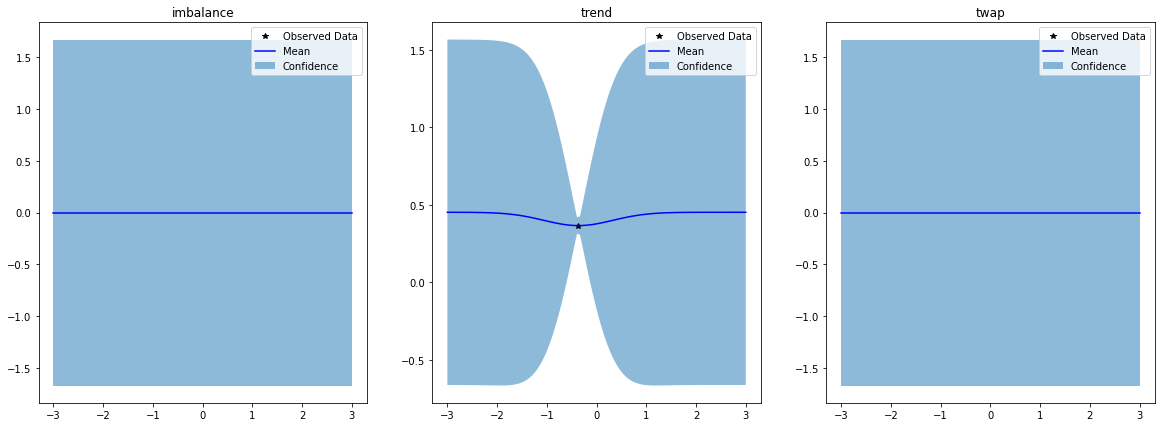

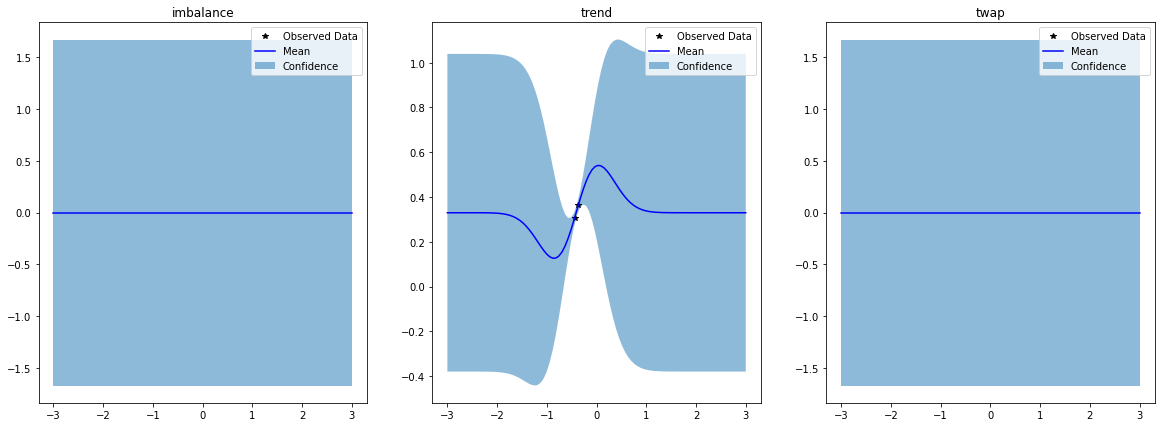

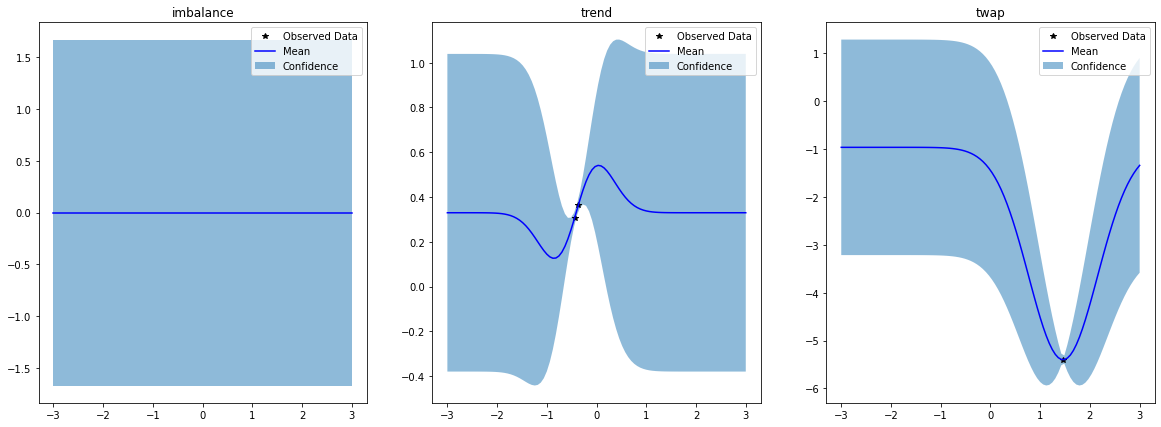

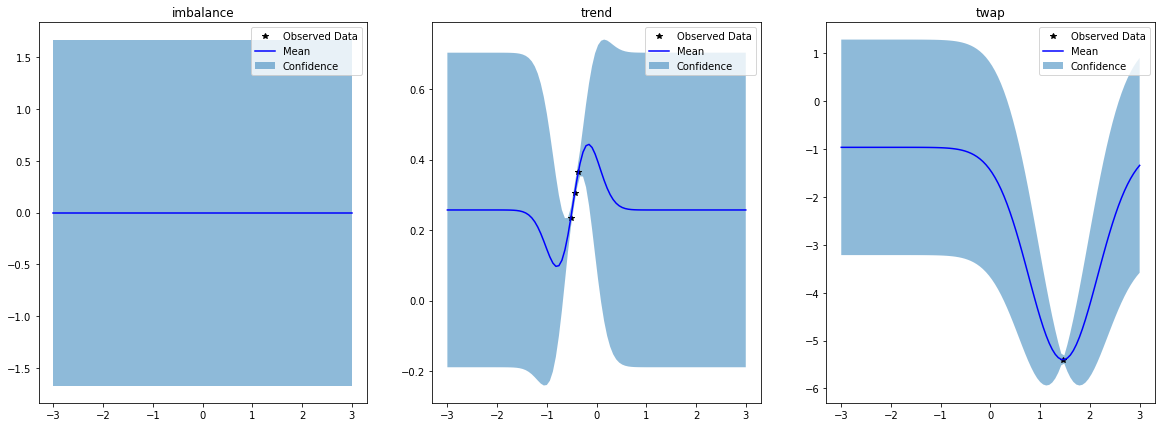

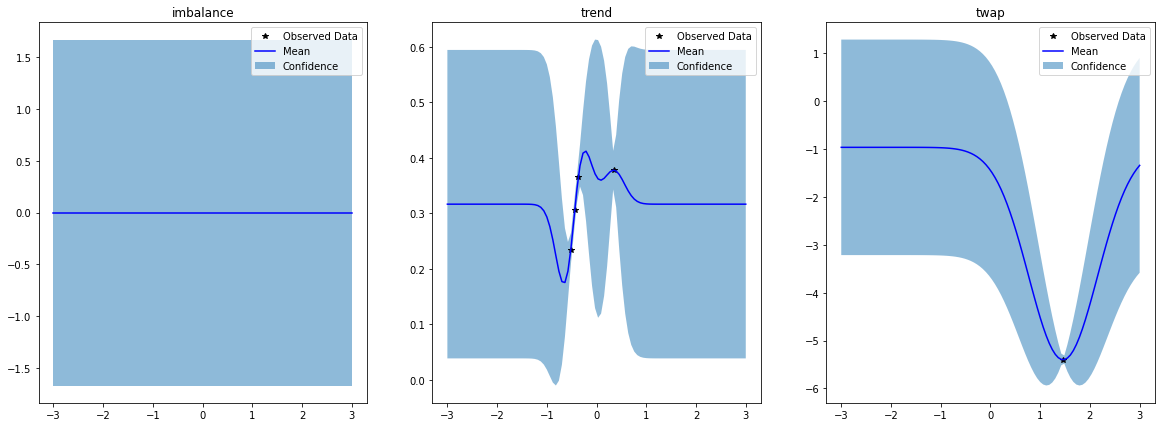

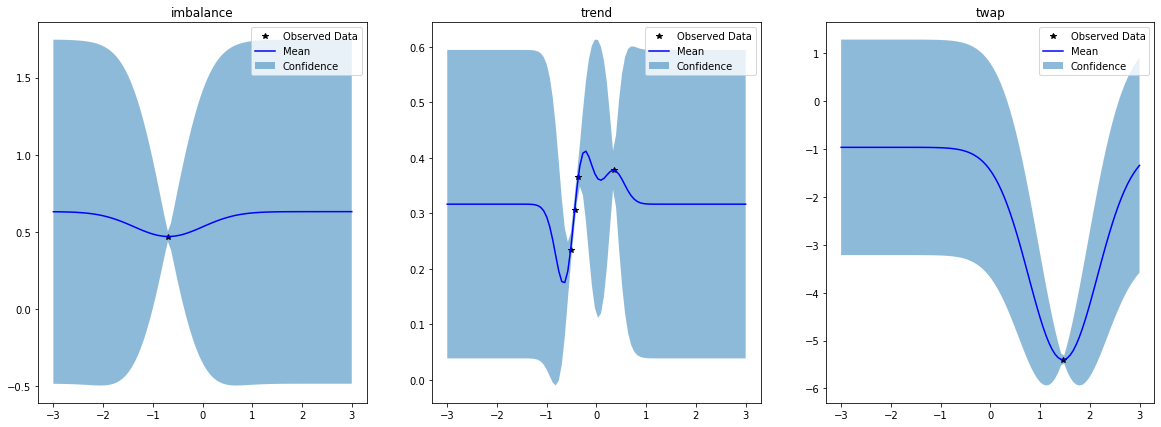

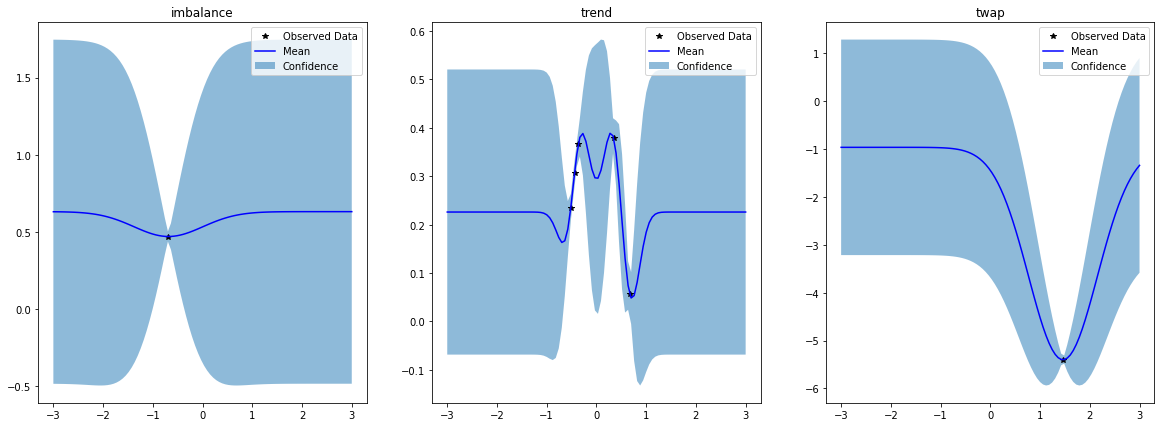

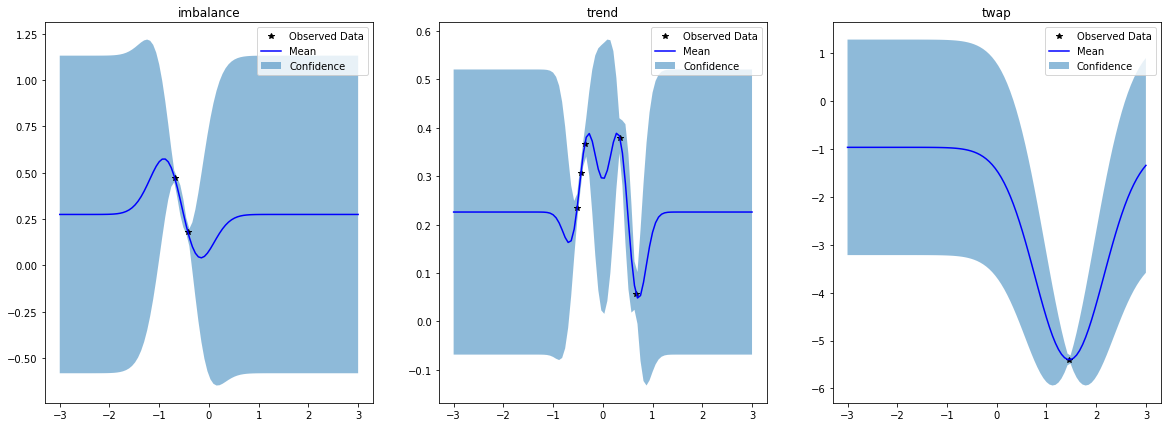

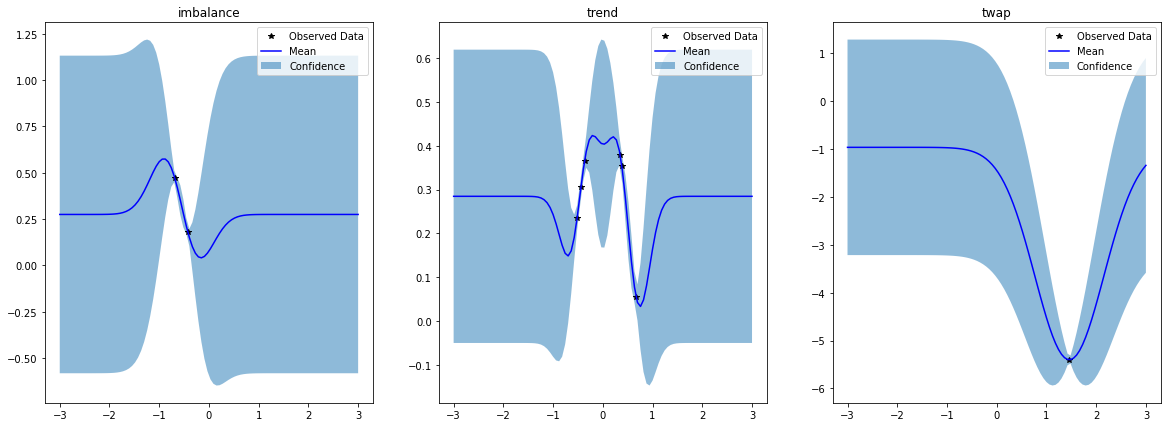

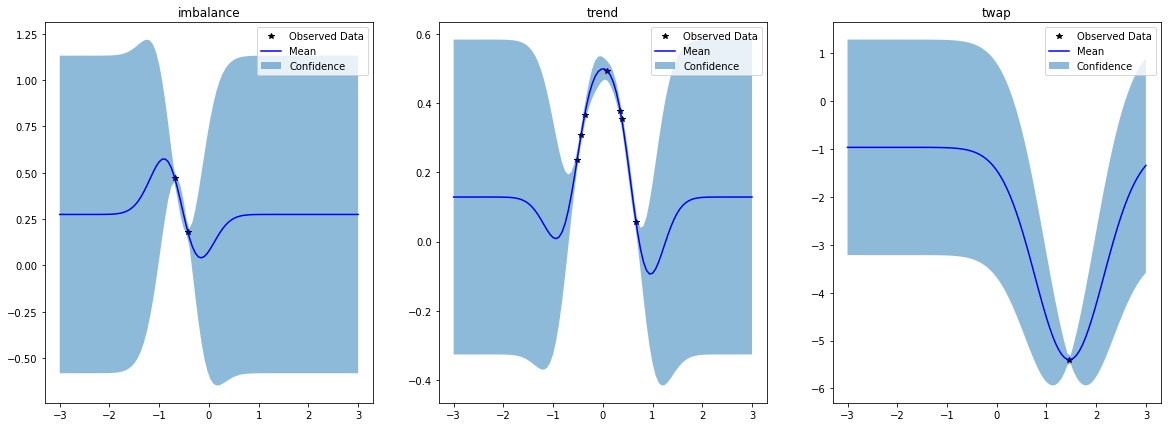

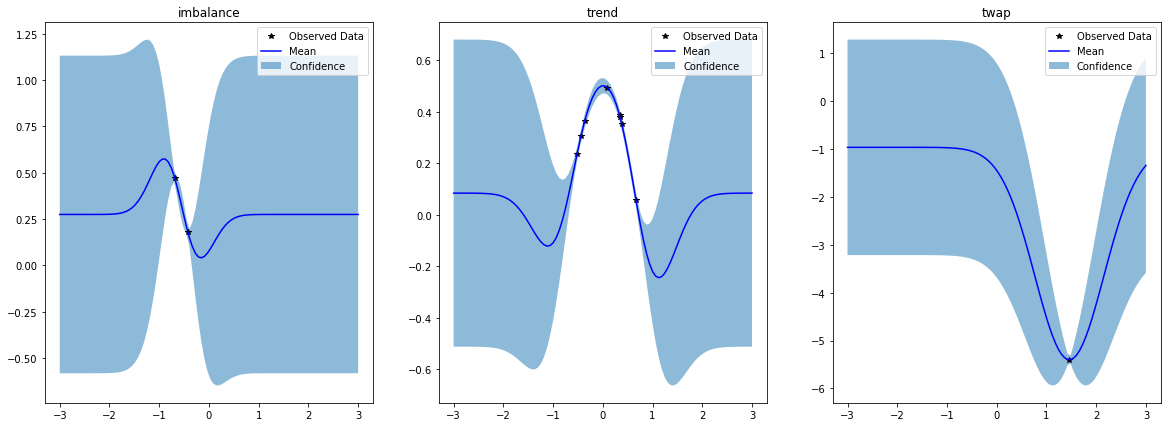

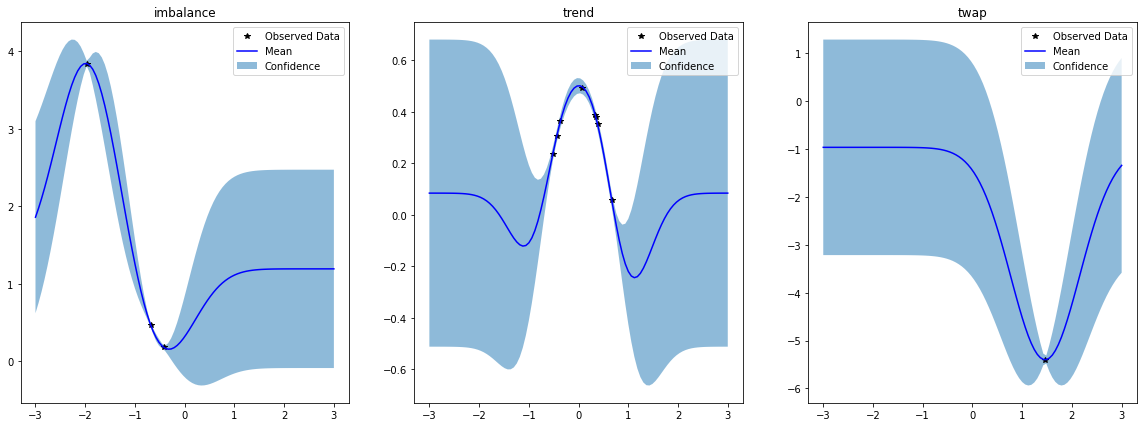

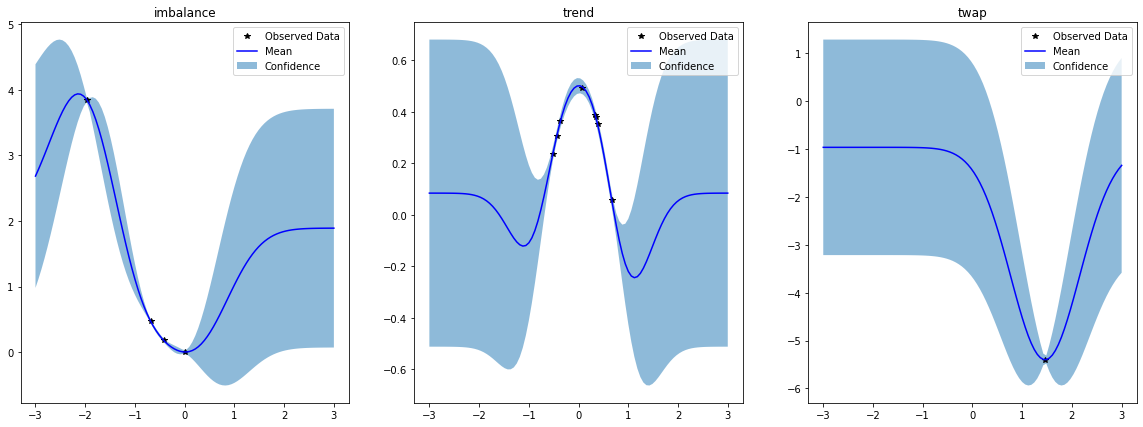

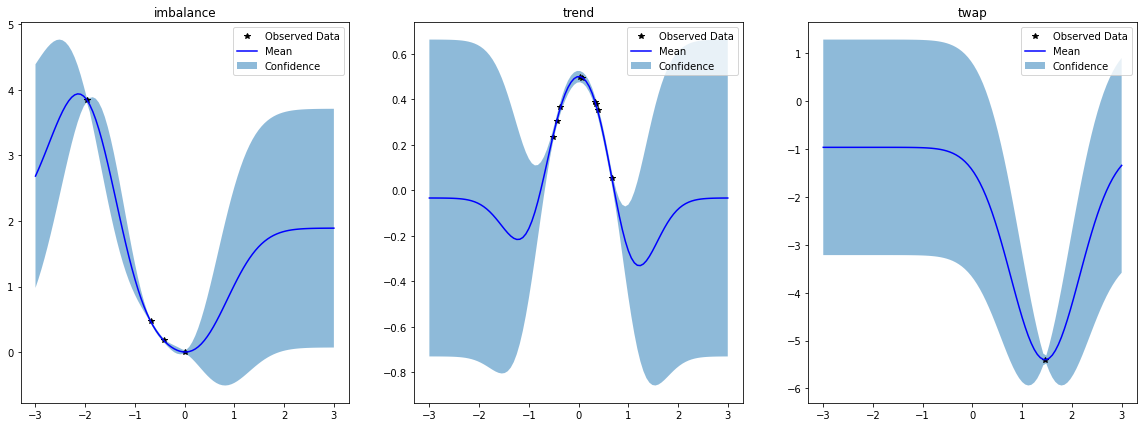

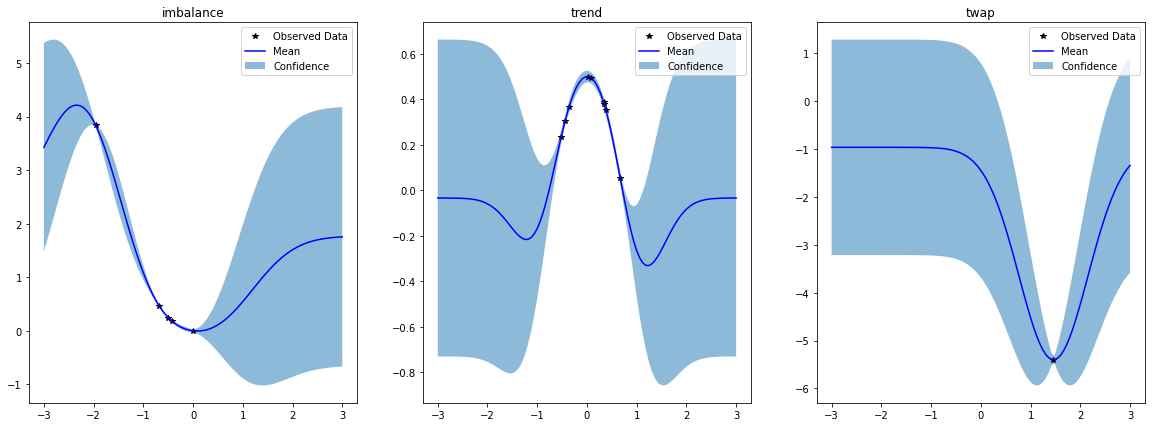

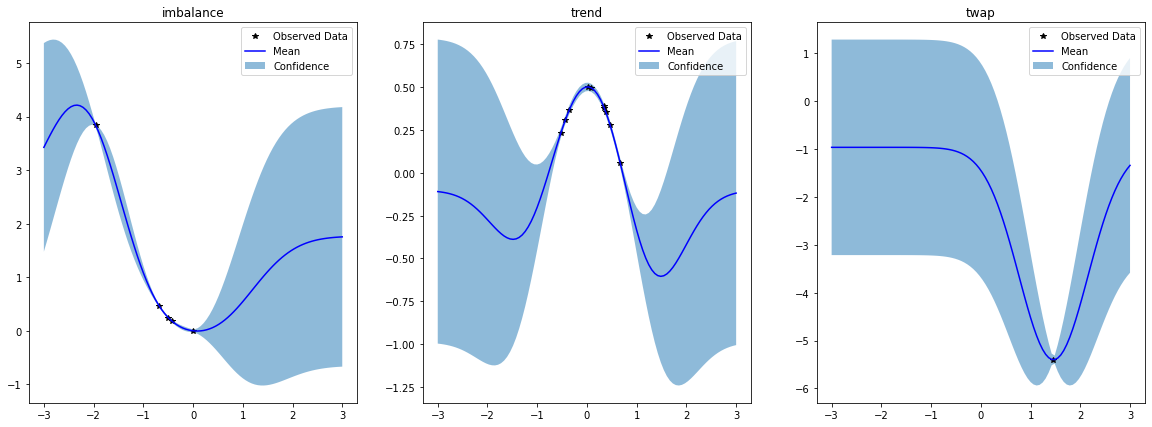

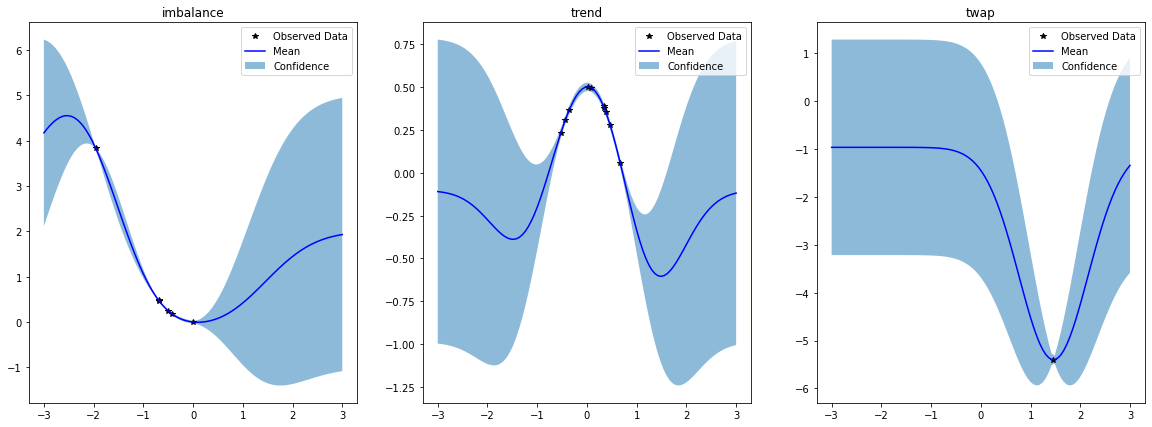

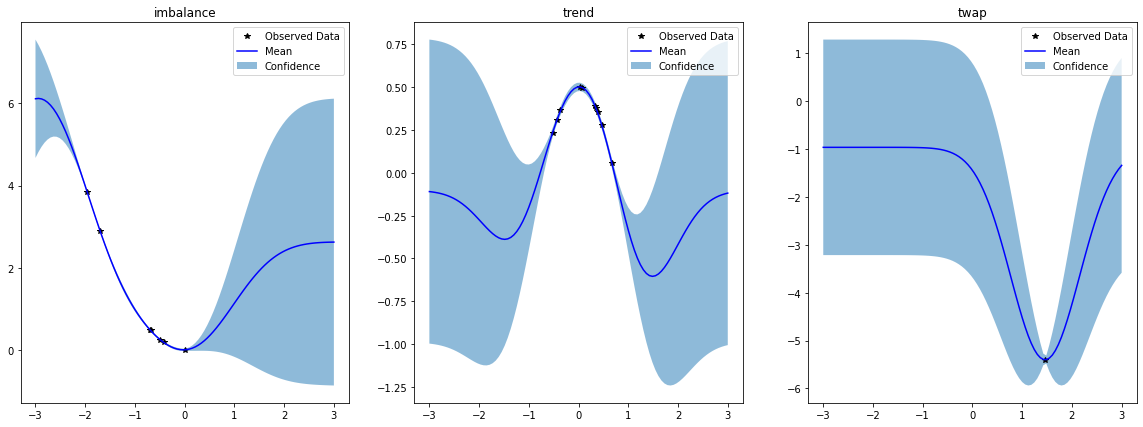

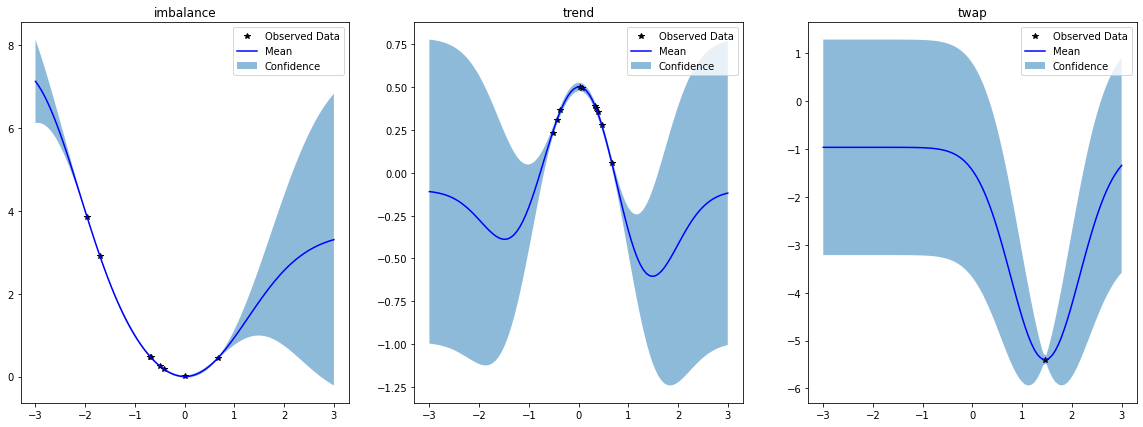

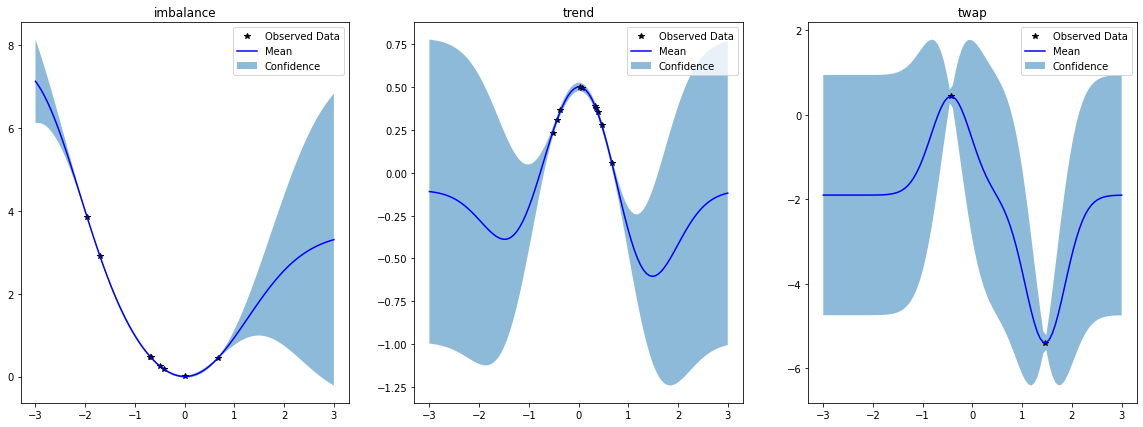

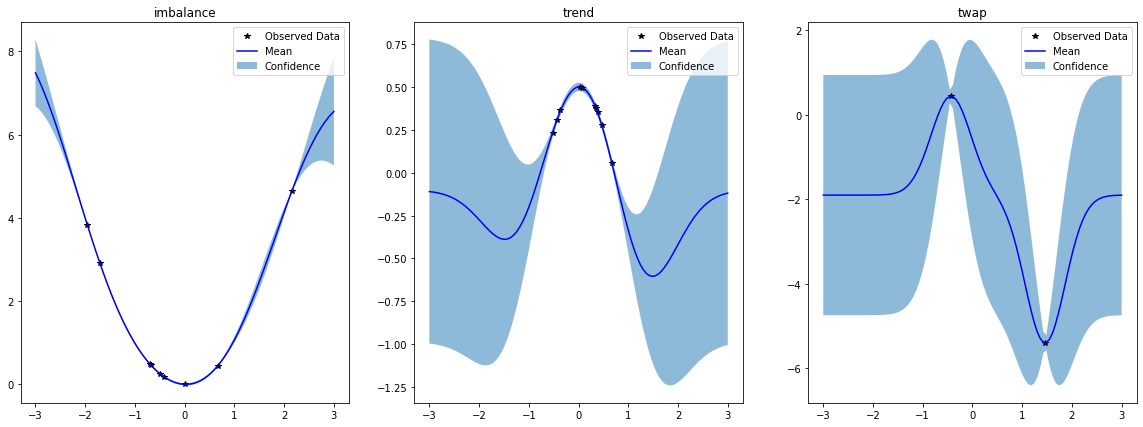

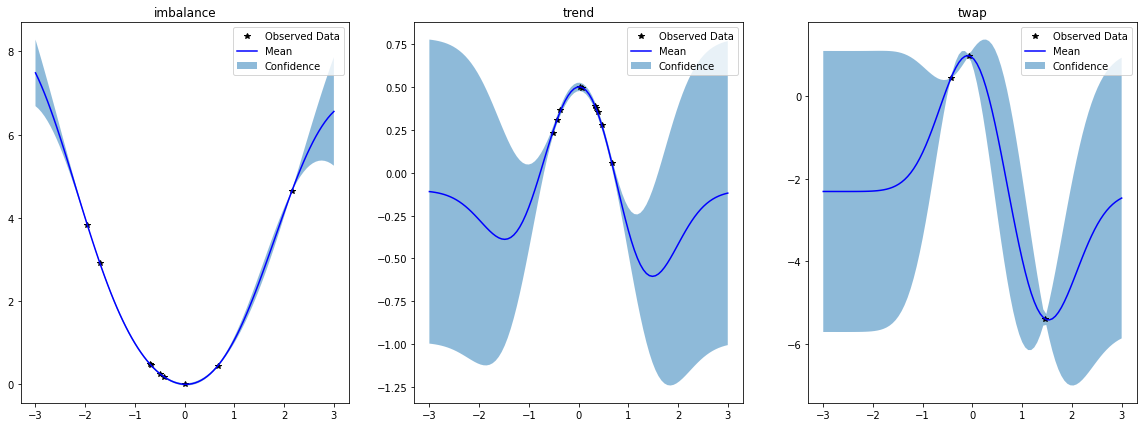

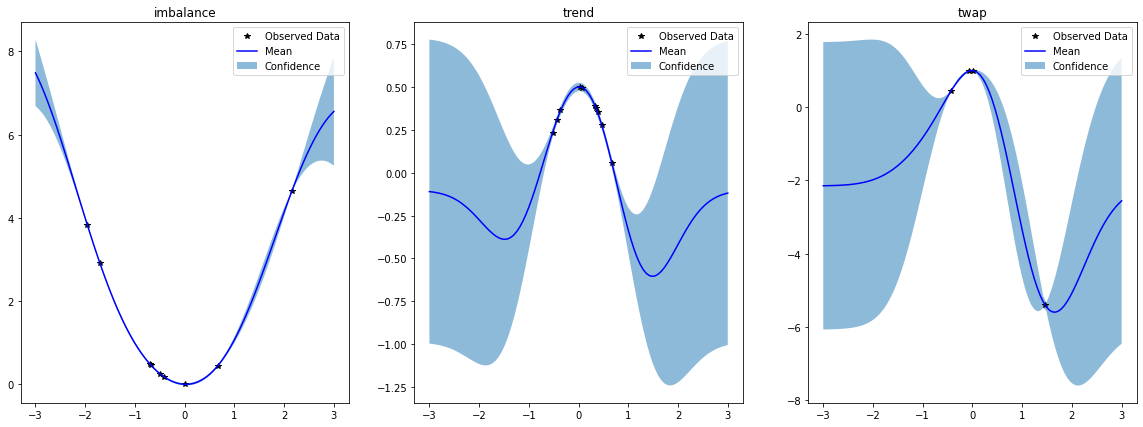

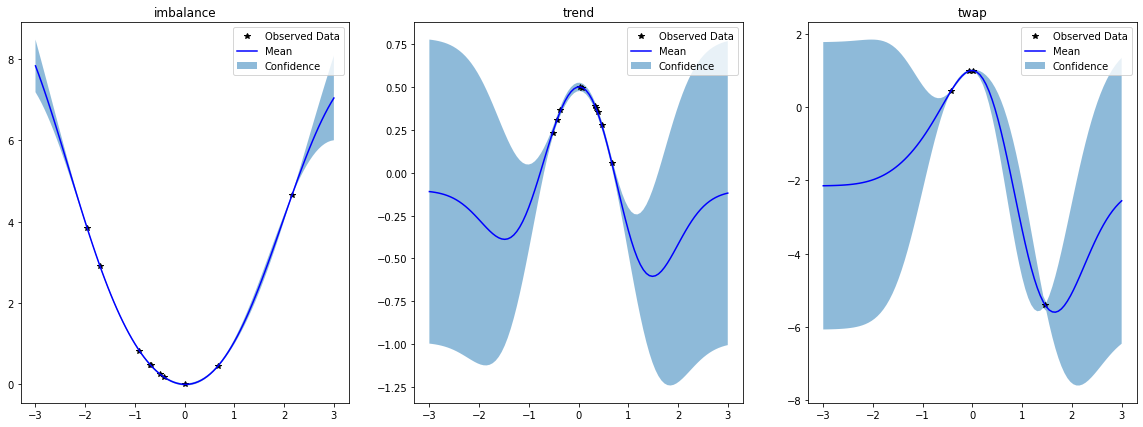

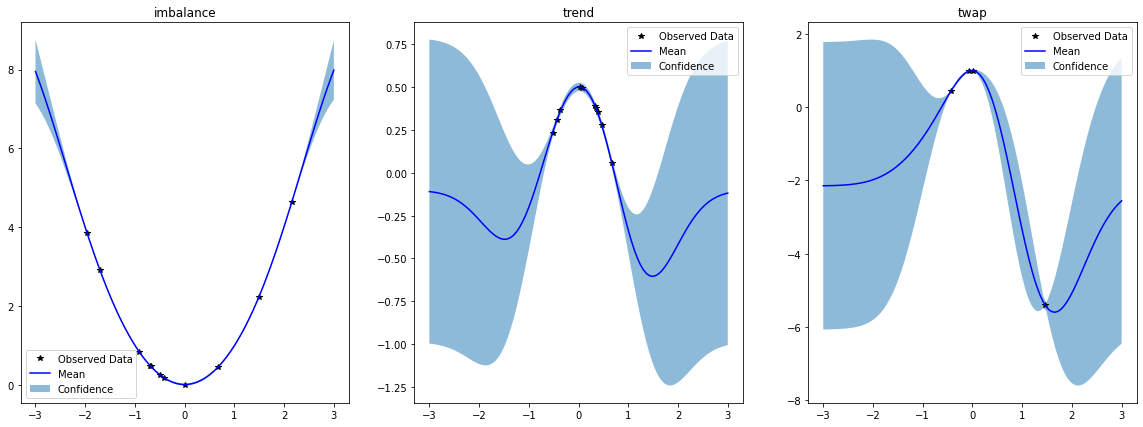

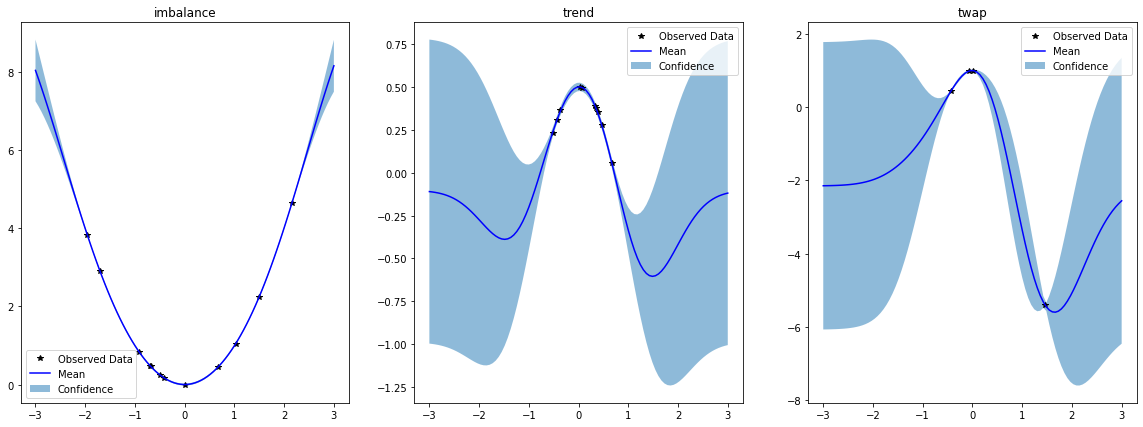

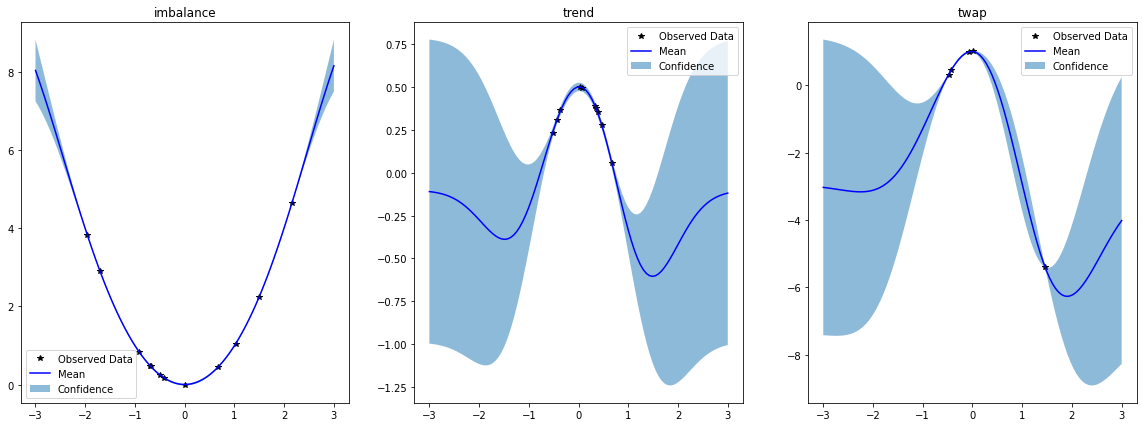

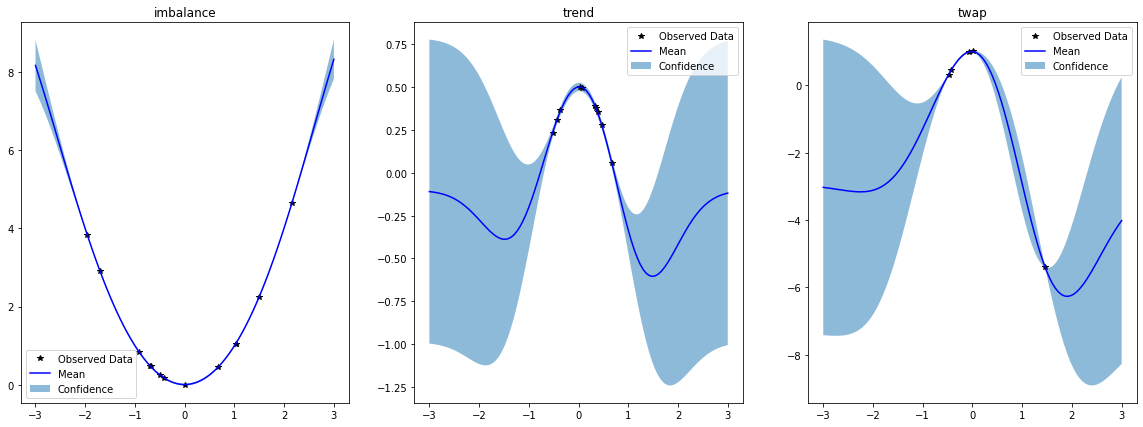

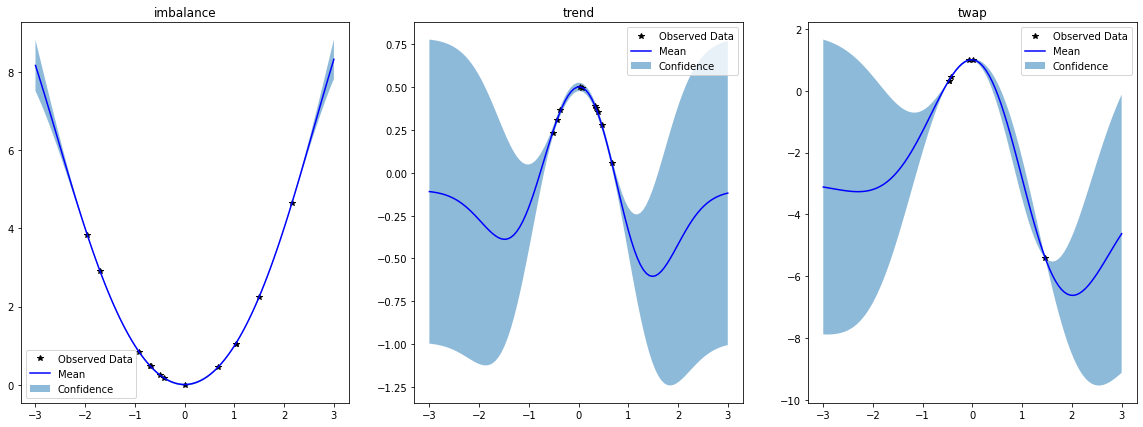

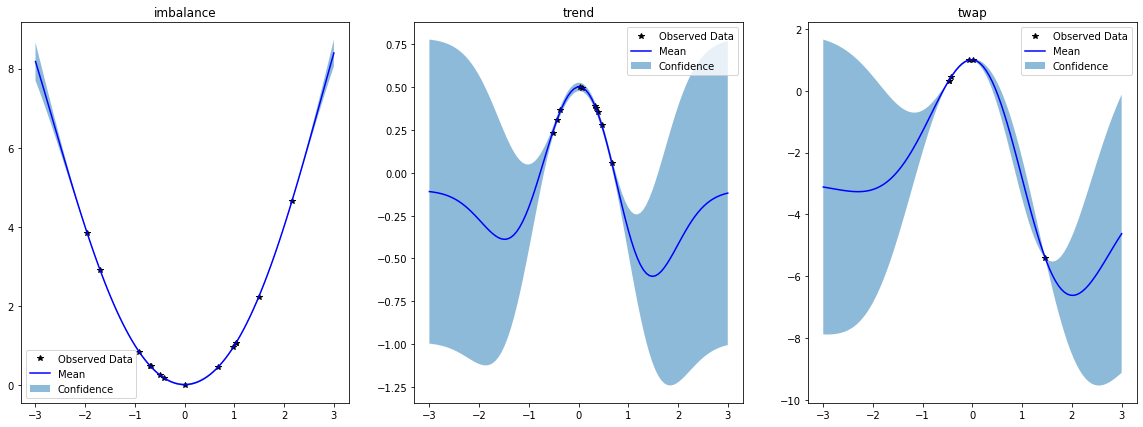

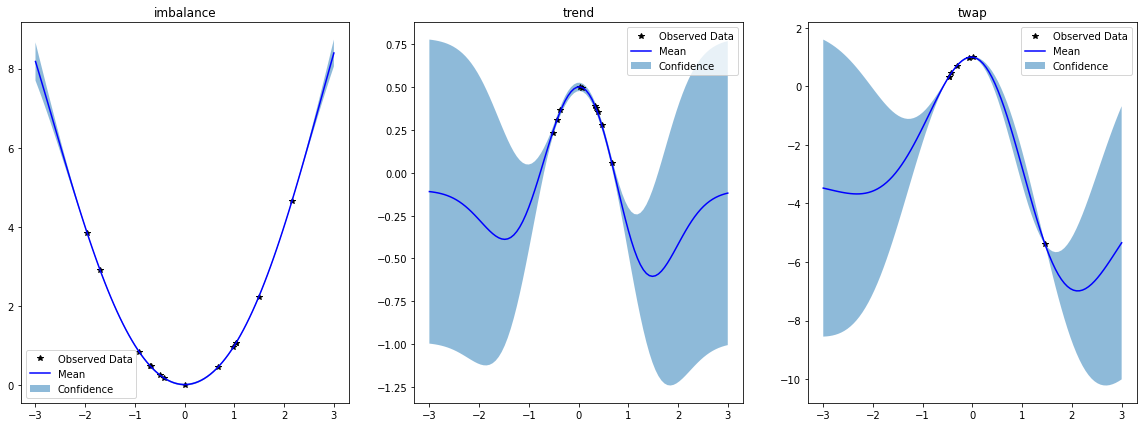

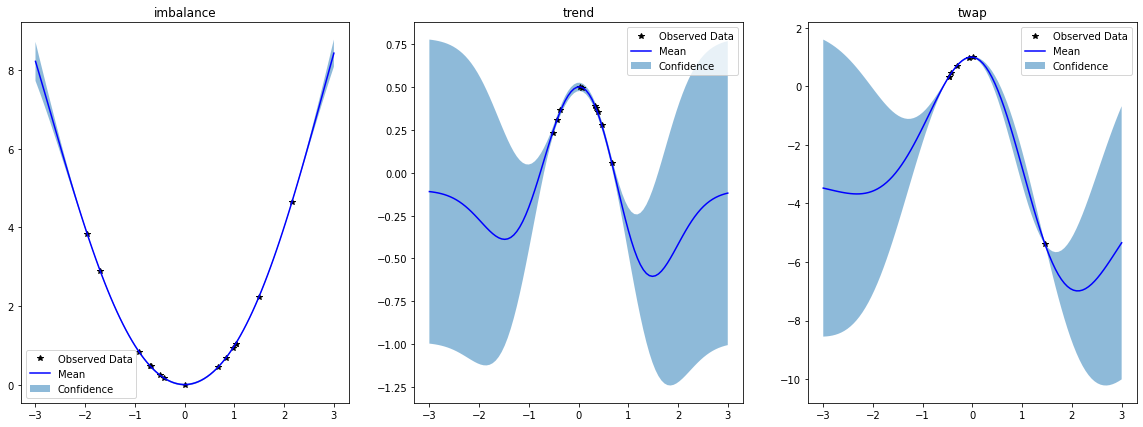

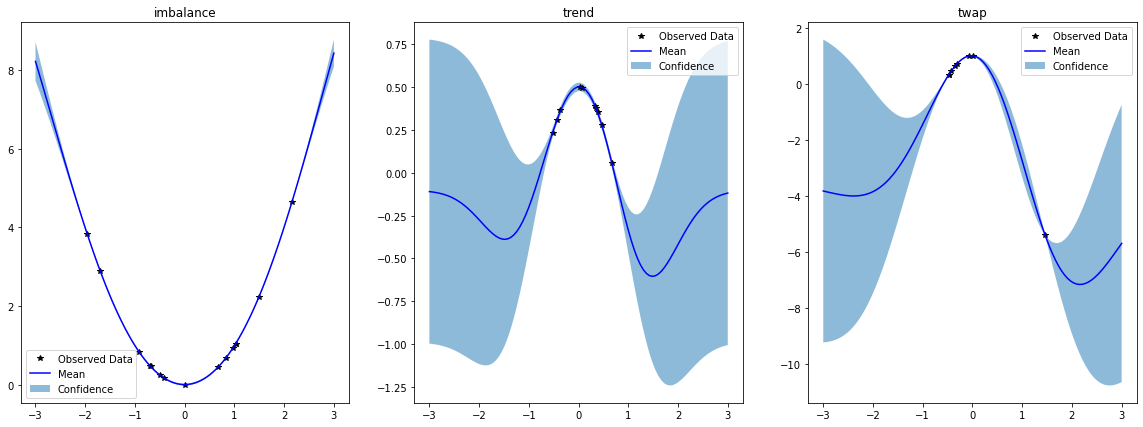

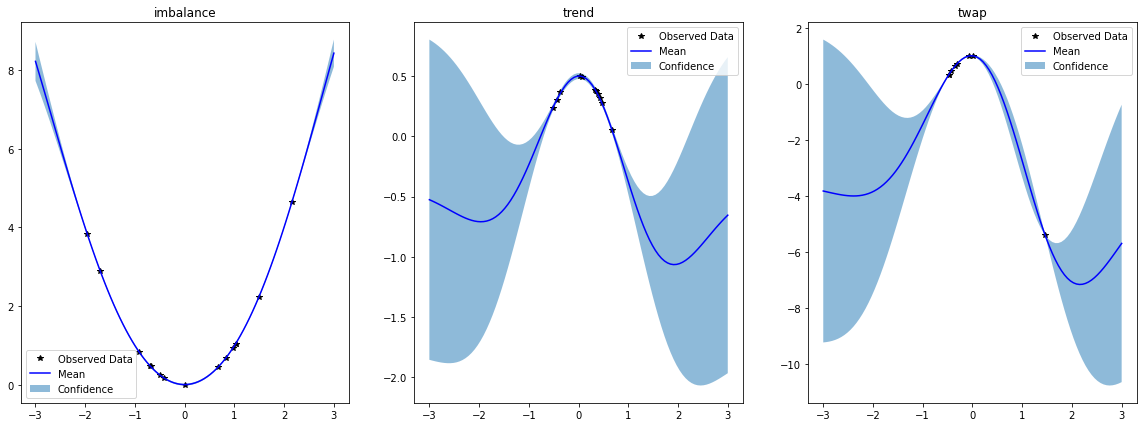

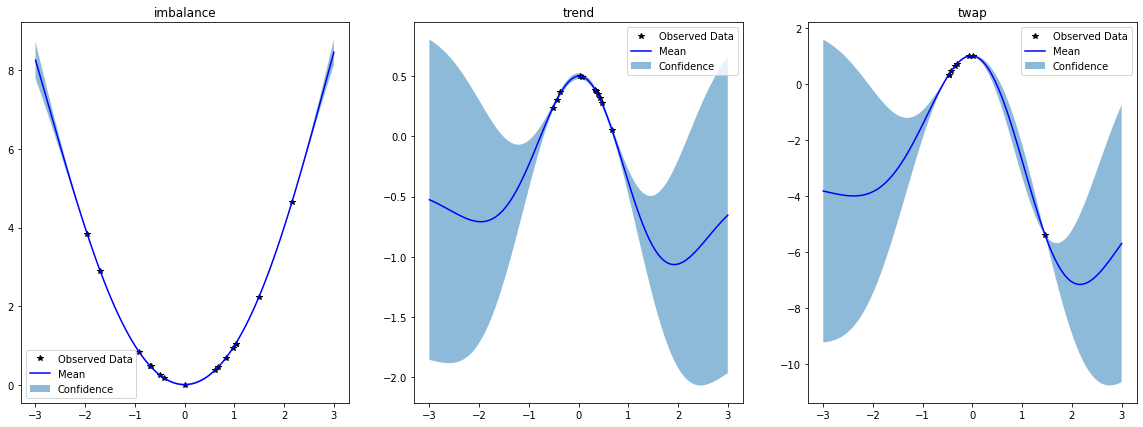

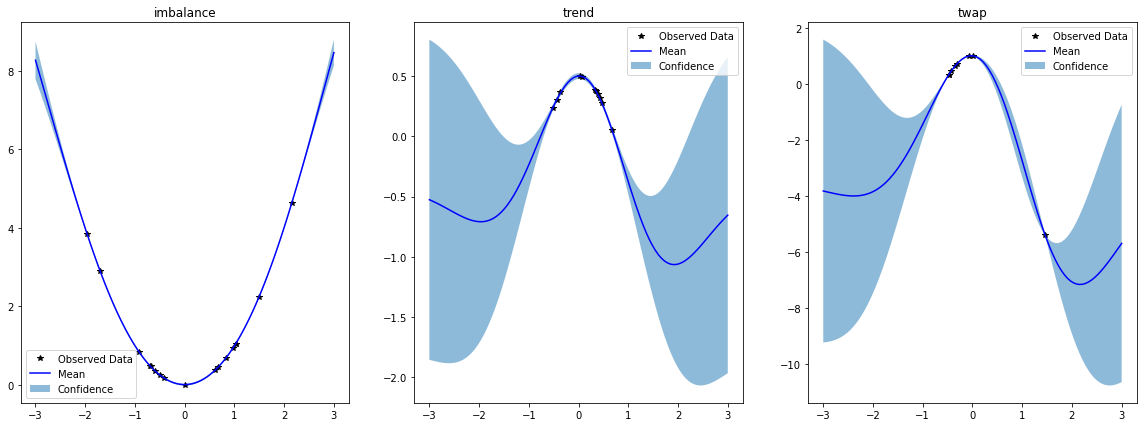

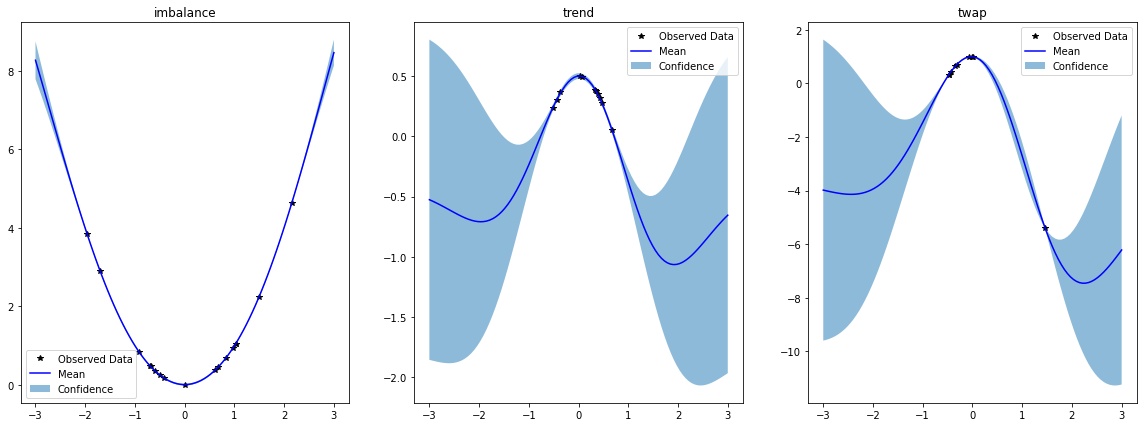

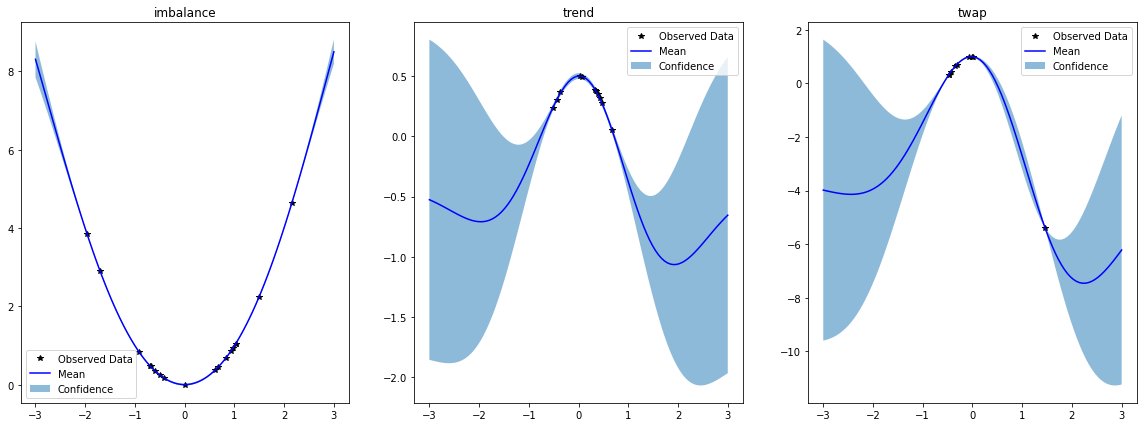

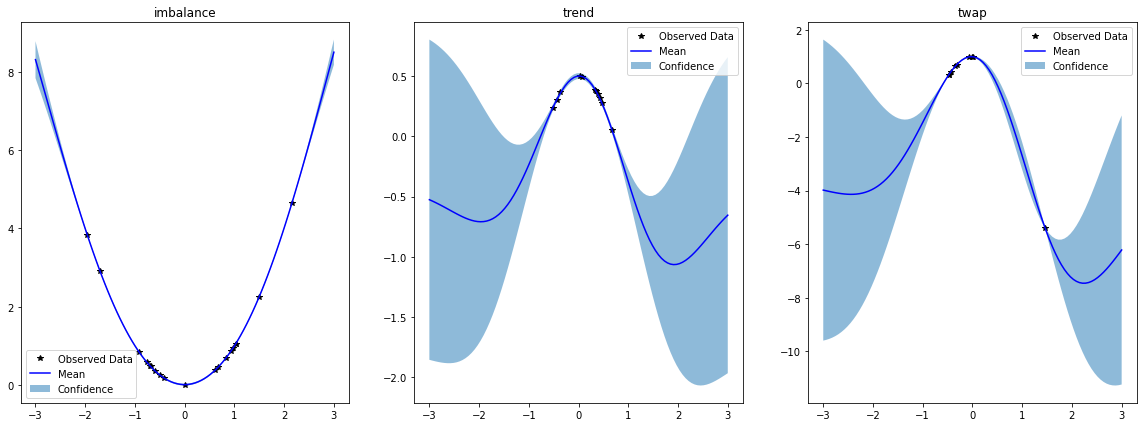

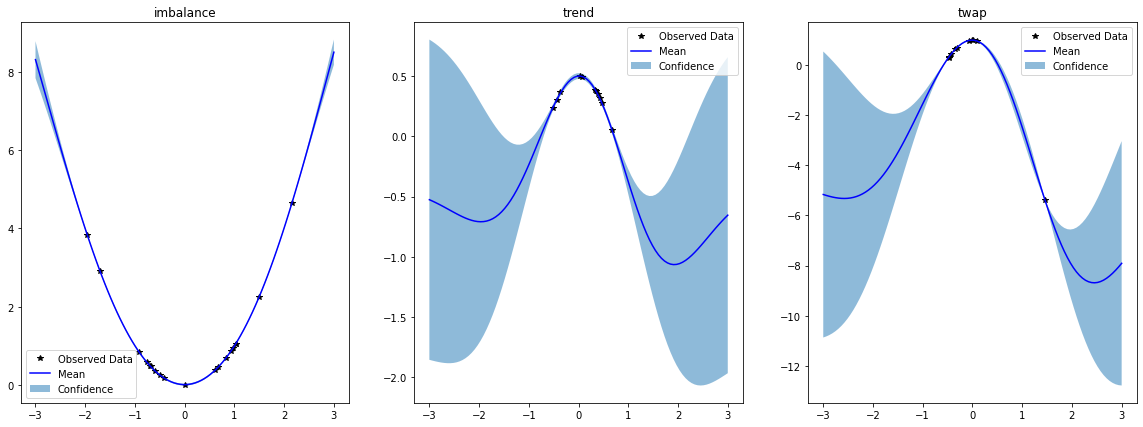

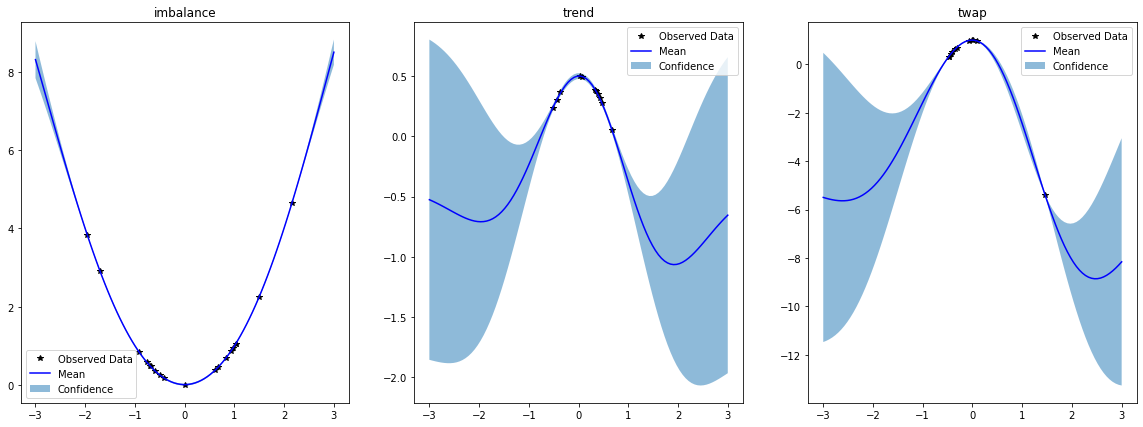

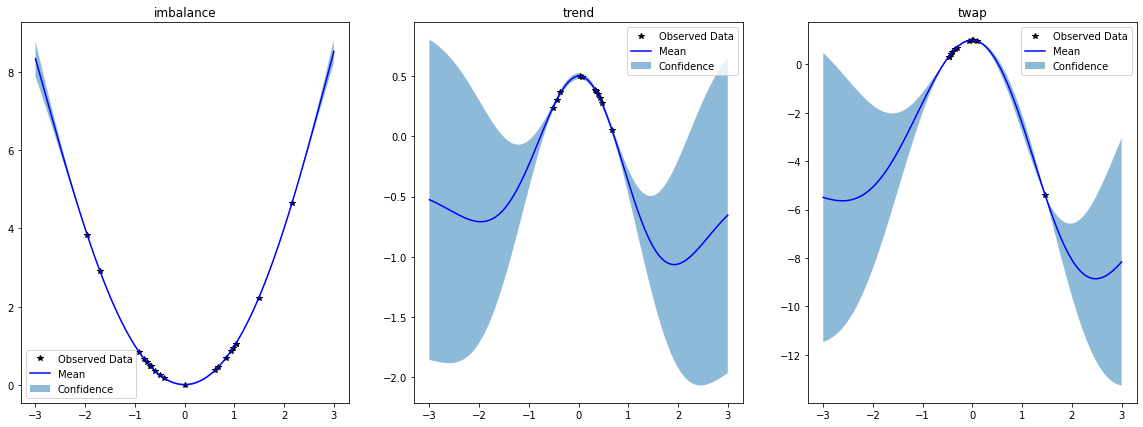

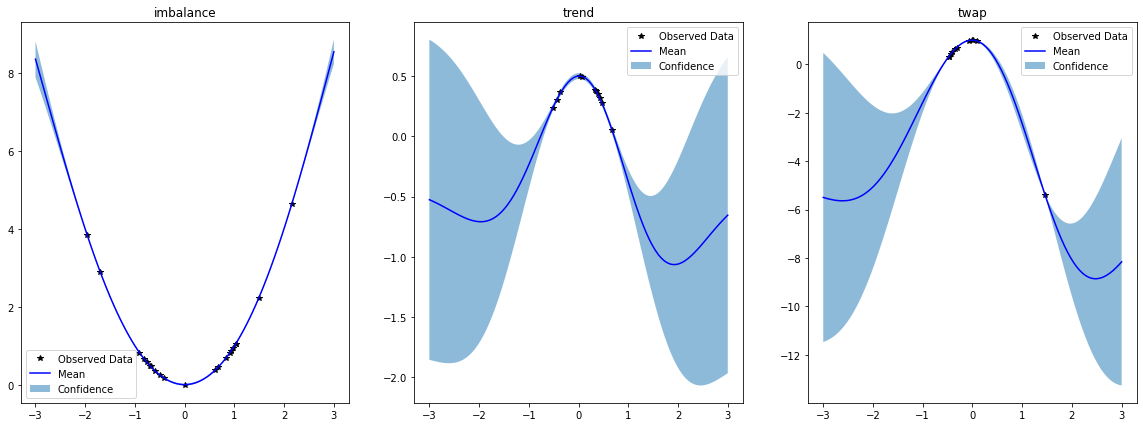

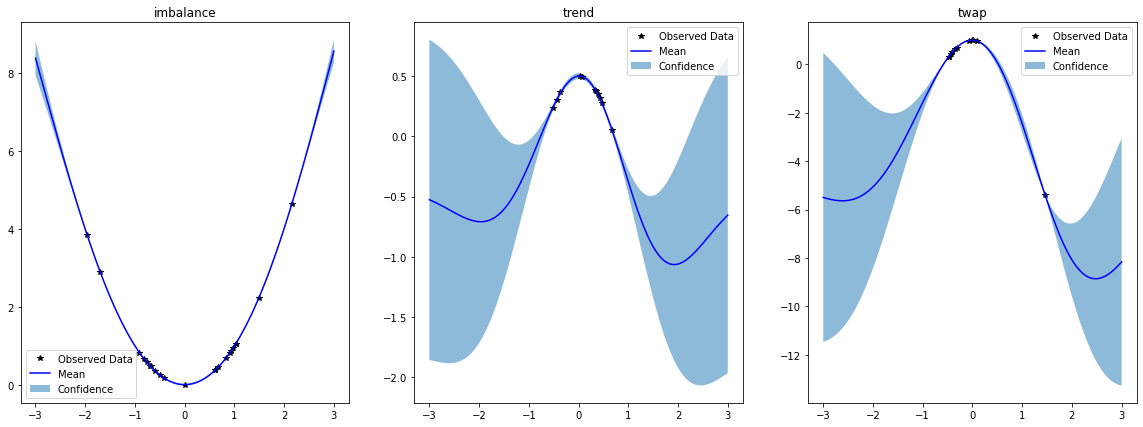

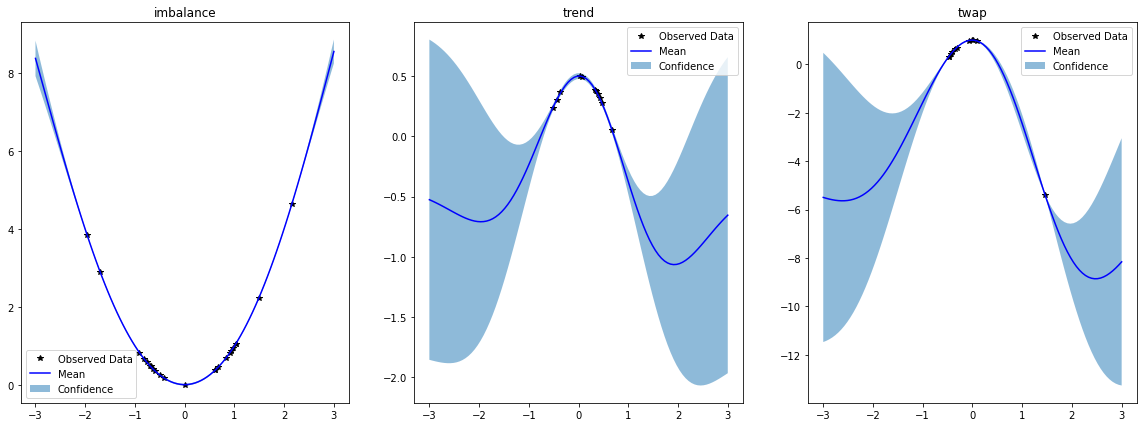

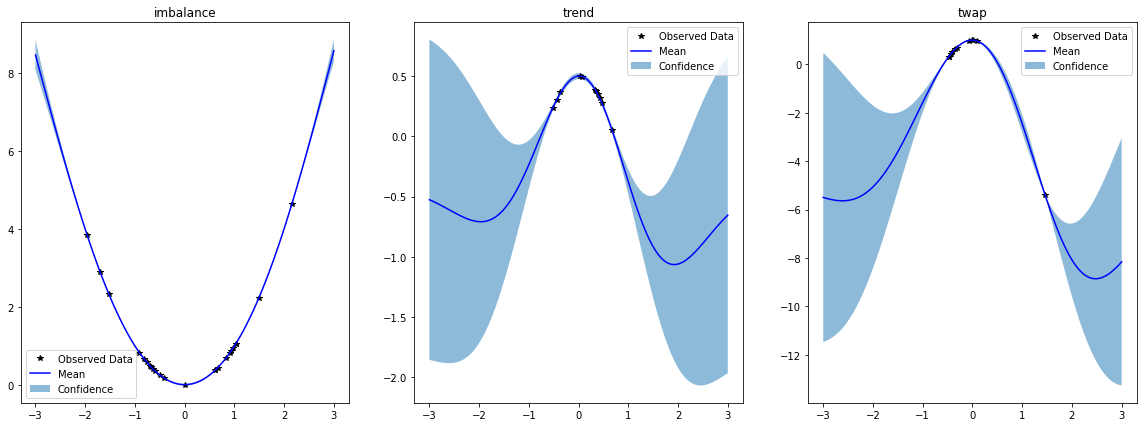

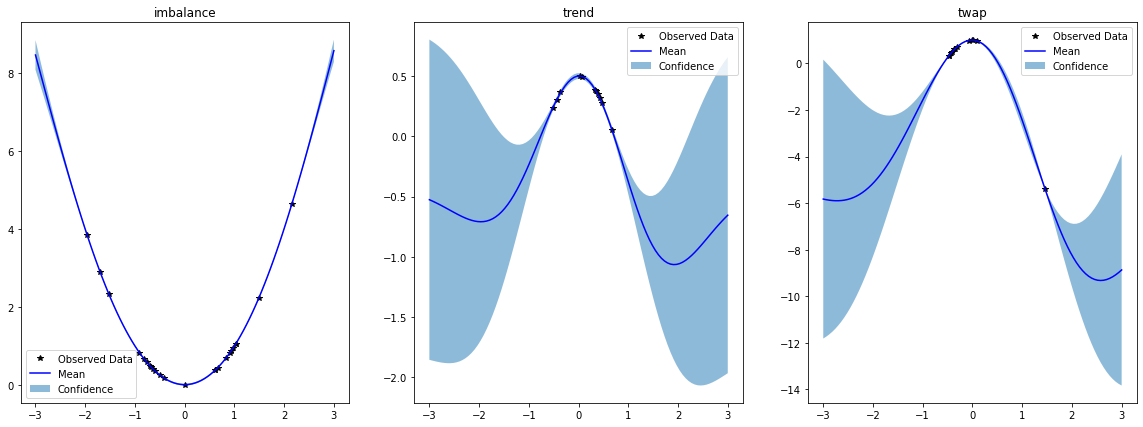

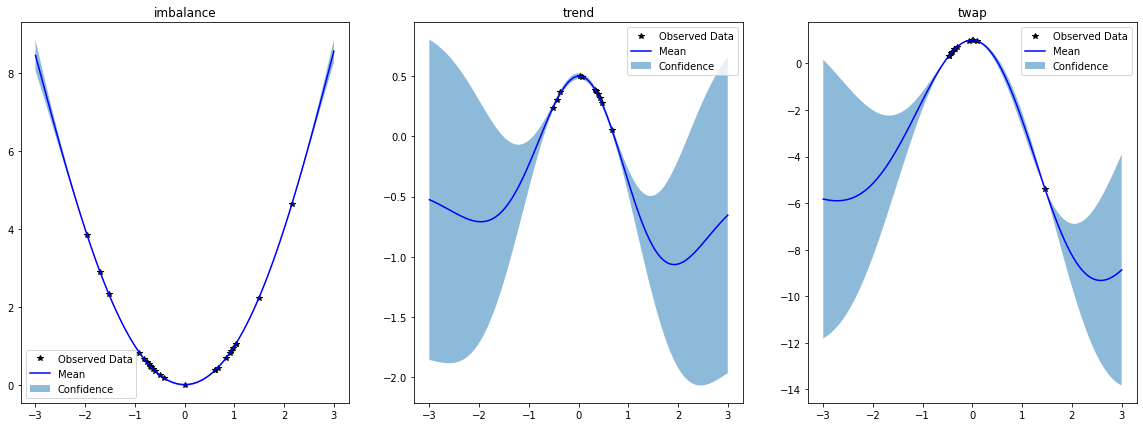

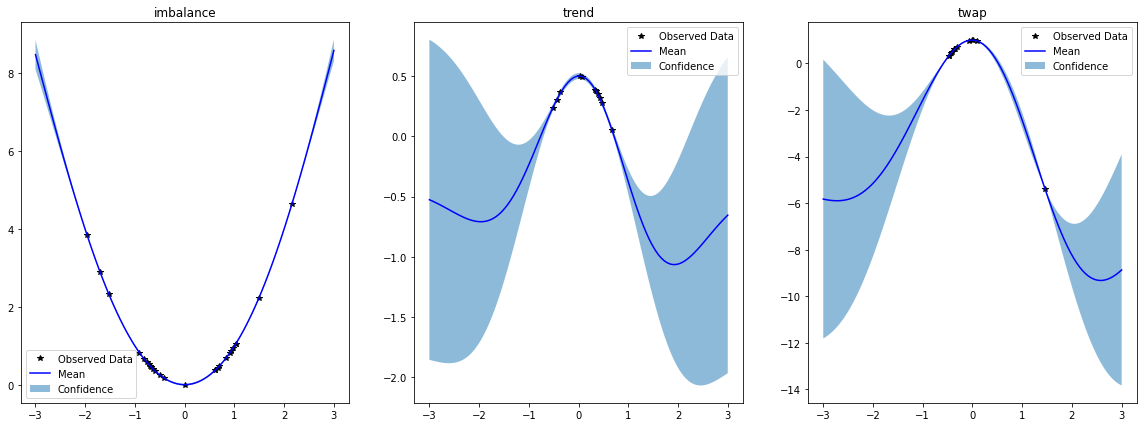

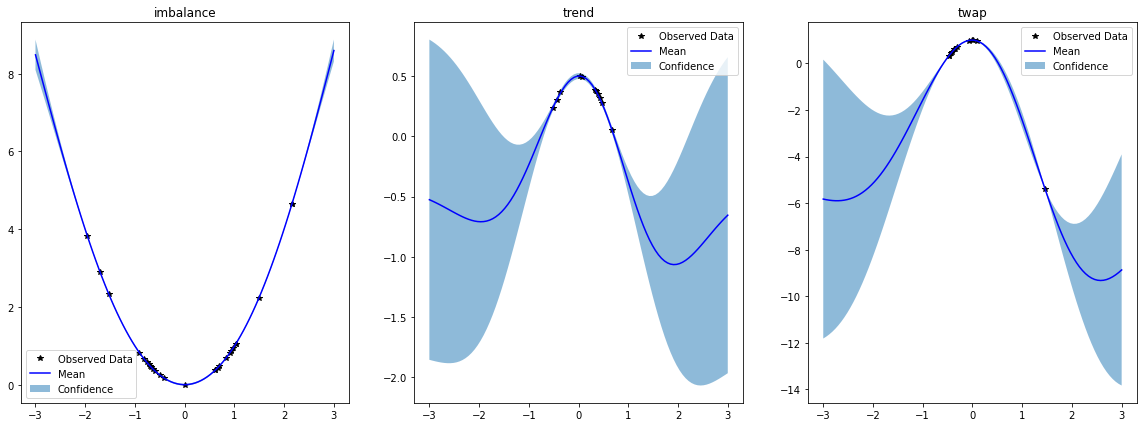

In [18]:
## Plot both gp and value ucb at each time step with data point
## Try non stationarity
## Create synthetic random datapoints
bandit = gp_bandit(strategies, likelihood, size_buffer, bandit_algo='TS')
reward_imbalance = lambda x: x**2
reward_trend = lambda x: -x**2 + 0.5
reward_twap = lambda x: -3*x**2 + 1
d = {'vol_50_50000': np.random.normal()}

for i in range(50):
    d['vol_50_50000'] = np.random.normal()
    feature_values = pd.Series(data=d, index=['vol_50_50000'])
    best_strategy_bandit  = bandit.select_best_strategy(feature_values)
    
    if best_strategy_bandit == "imbalance":
        reward = reward_imbalance(d['vol_50_50000'])
    elif best_strategy_bandit == "trend":
        reward = reward_trend(d['vol_50_50000'])
    else:
        reward = reward_twap(d['vol_50_50000']) 
    
    bandit.update_data(feature_values, best_strategy_bandit, reward, retrain_hyperparameters = True)
    
    bandit.plot_fit_all()

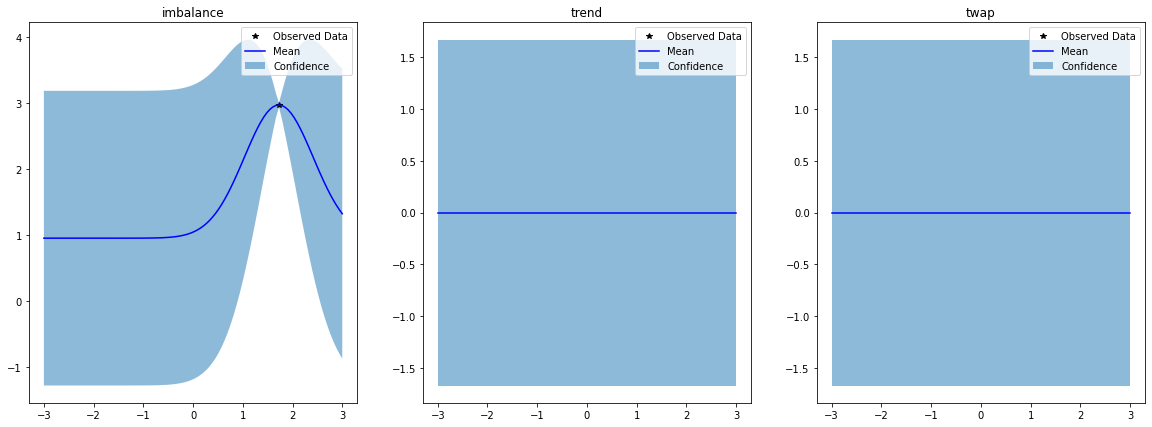

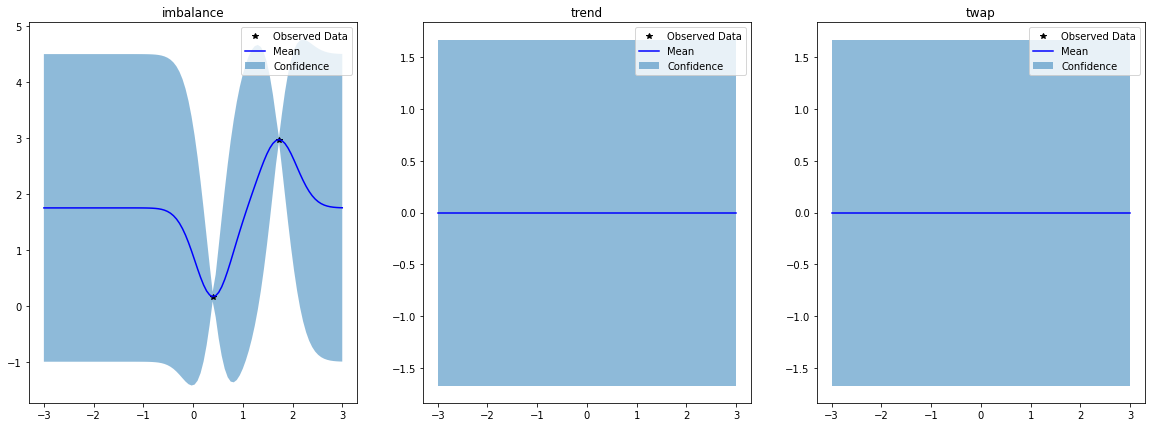

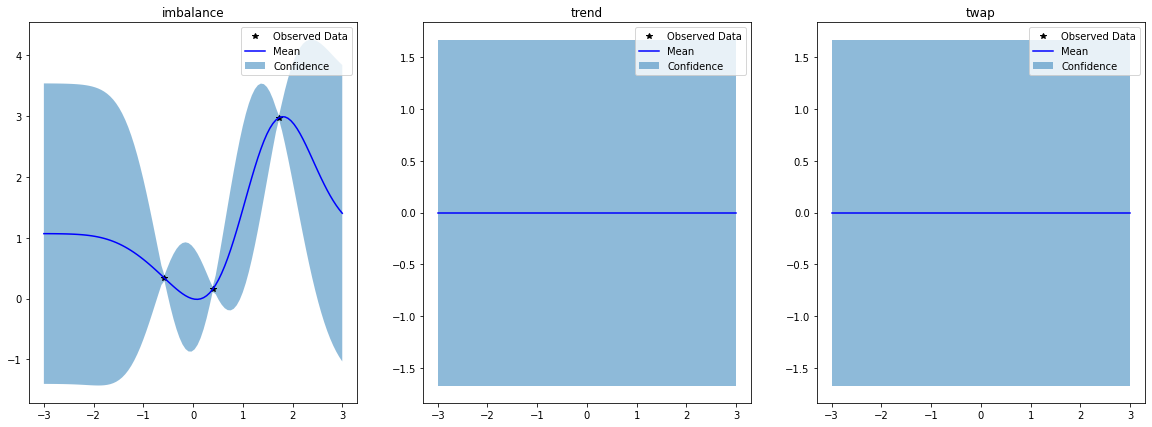

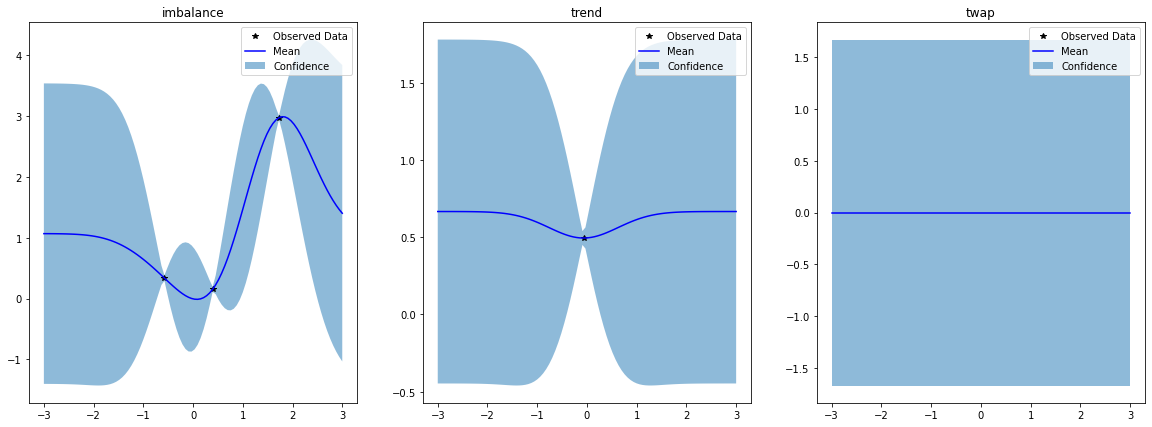

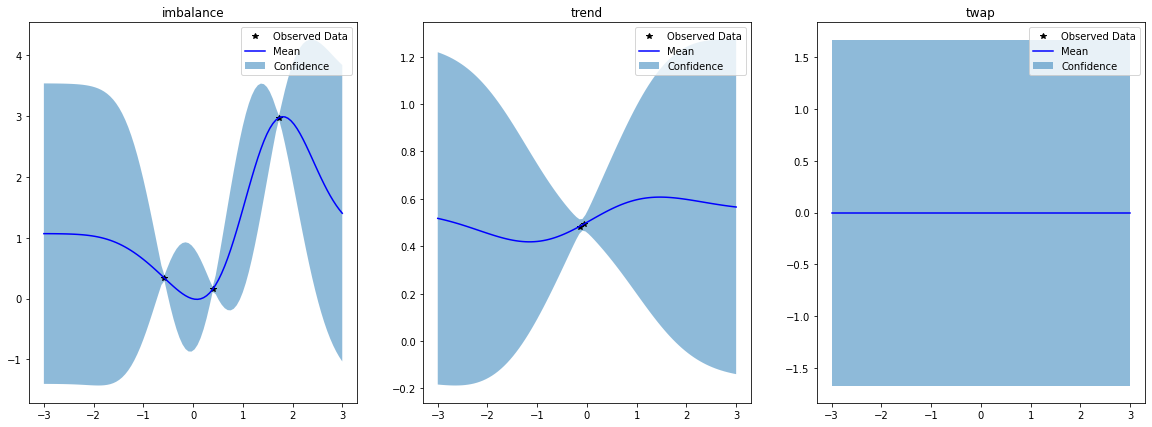

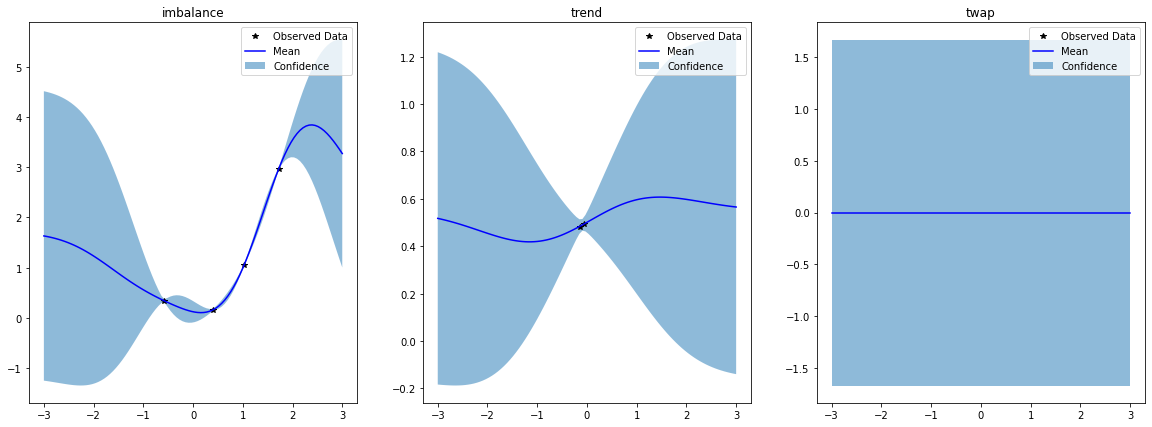

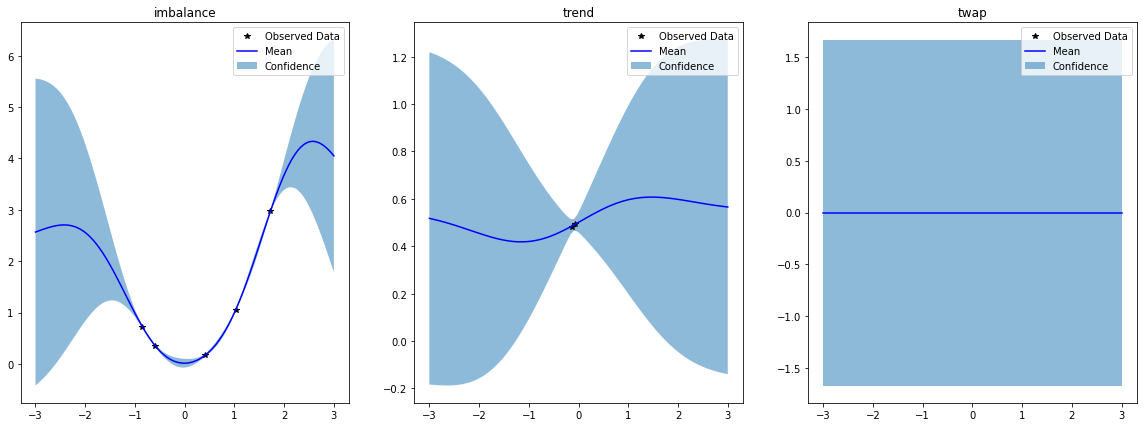

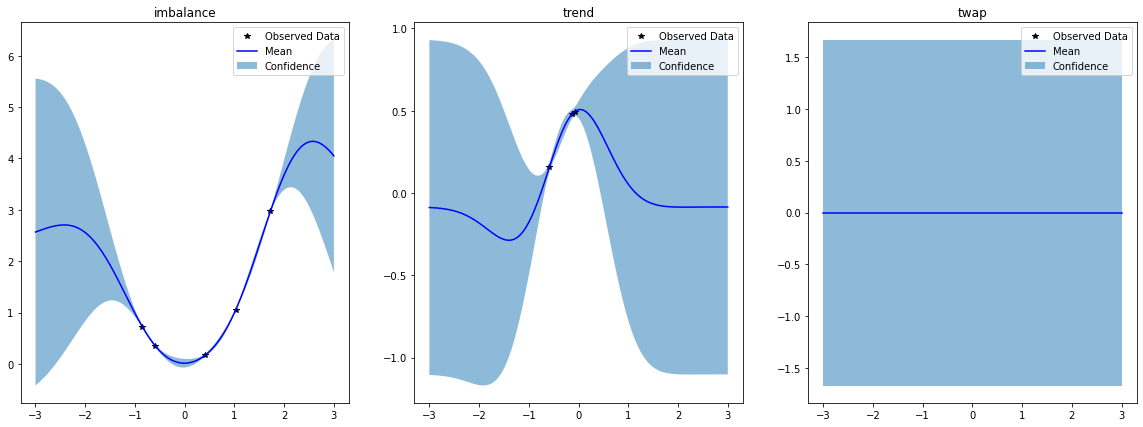

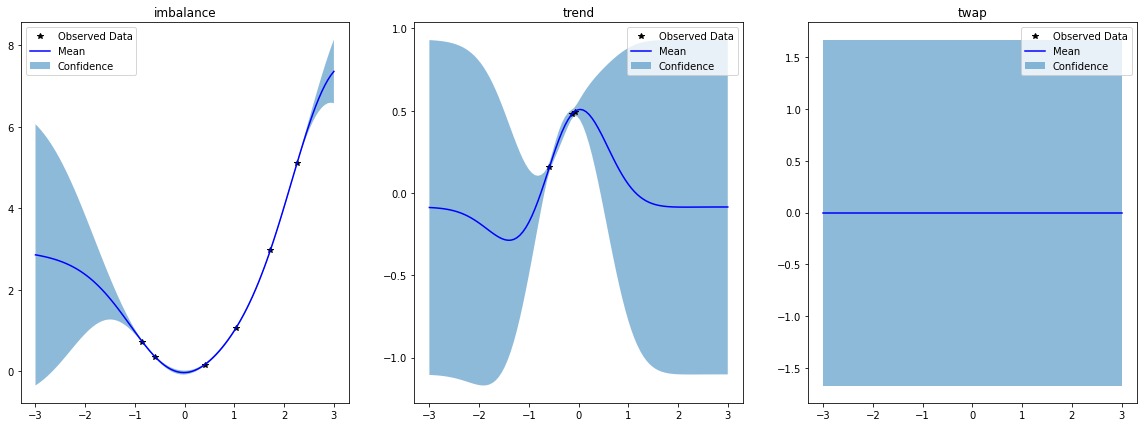

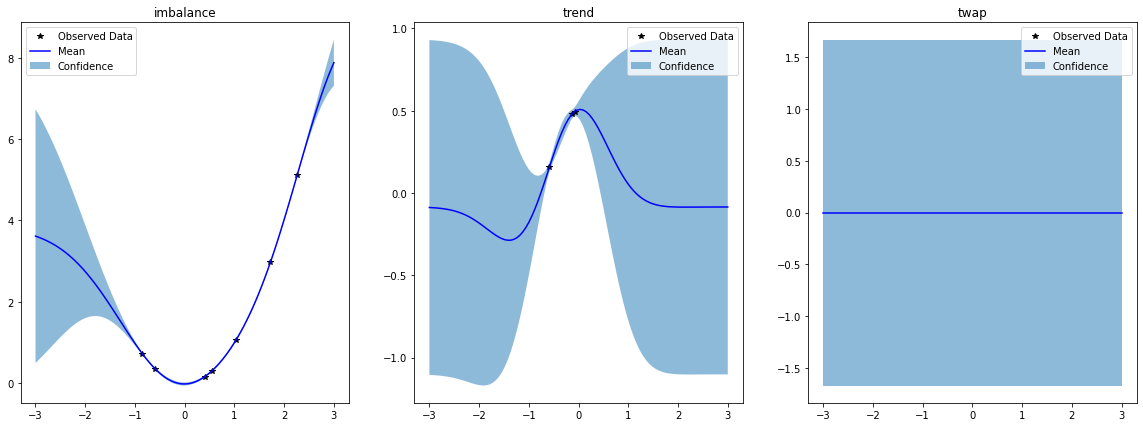

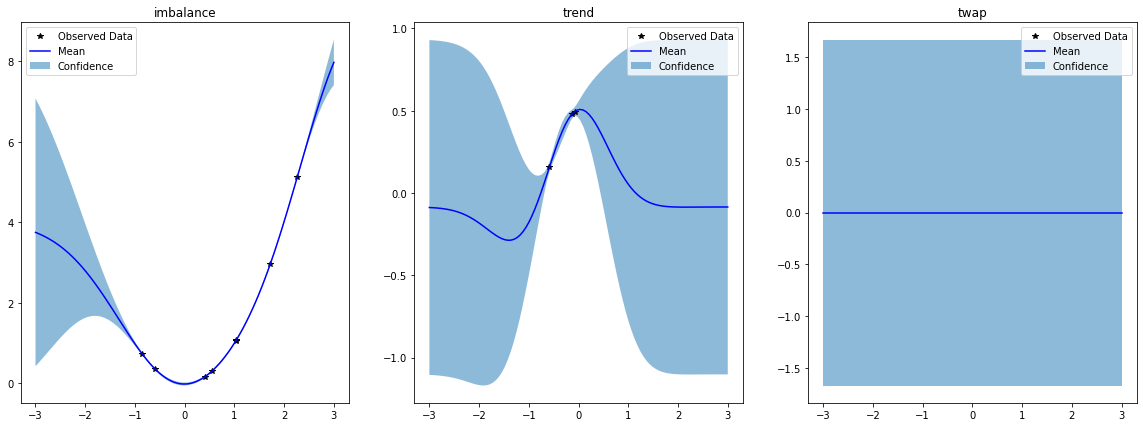

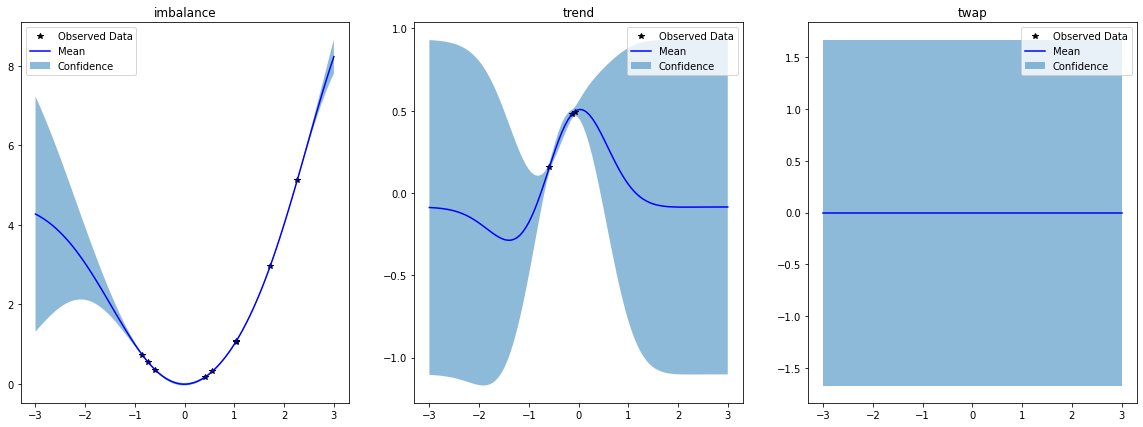

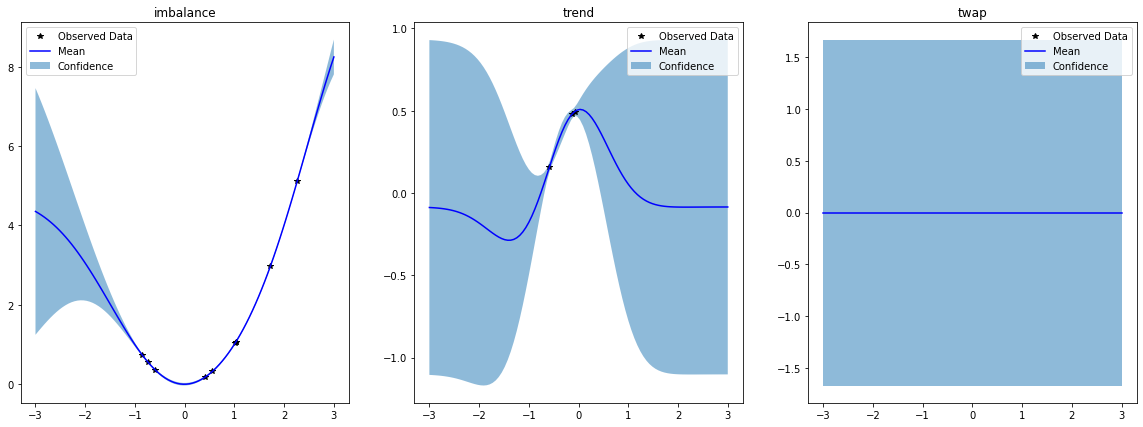

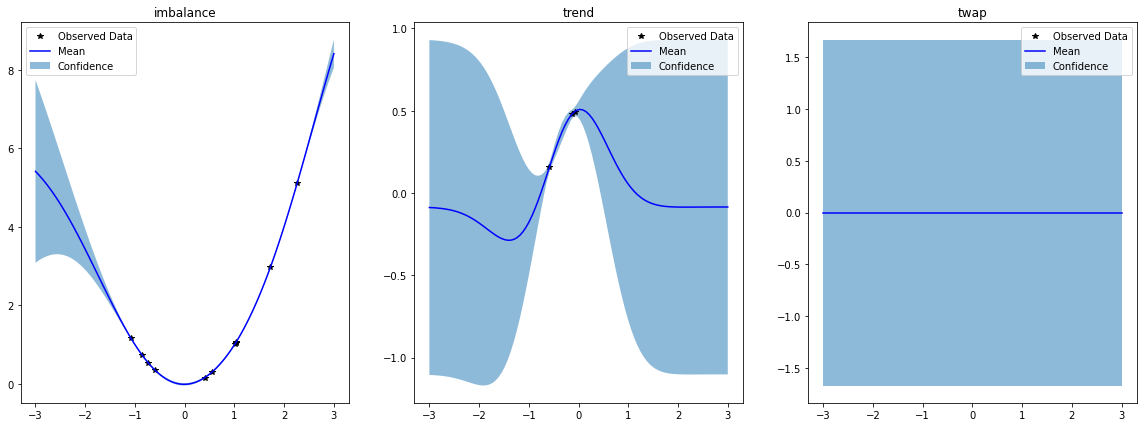

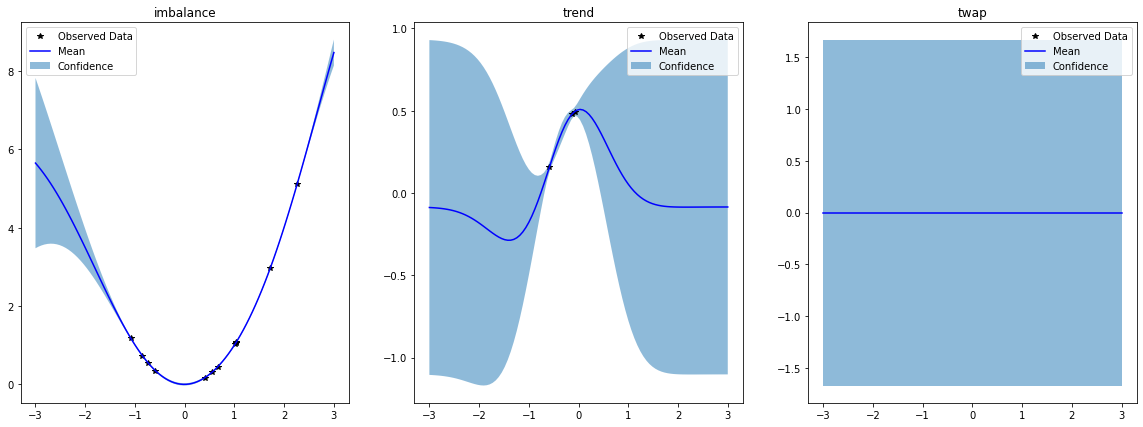

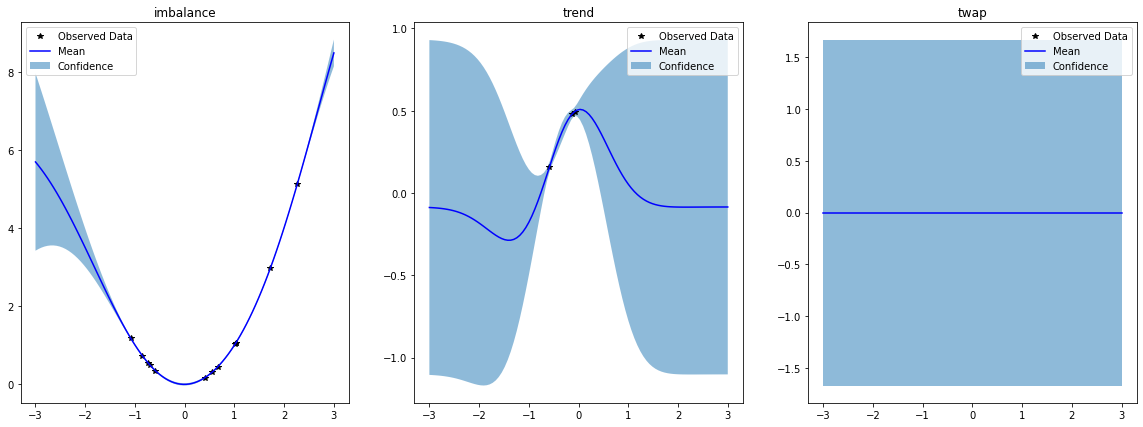

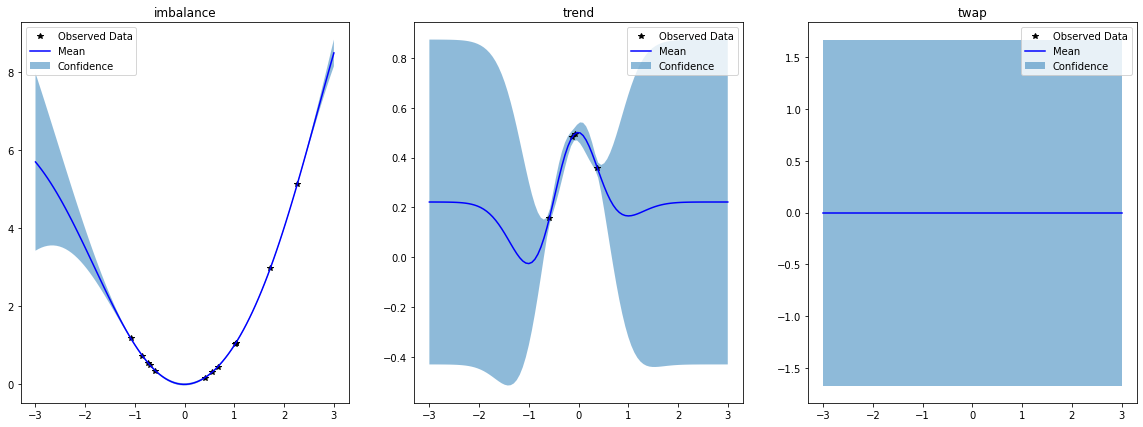

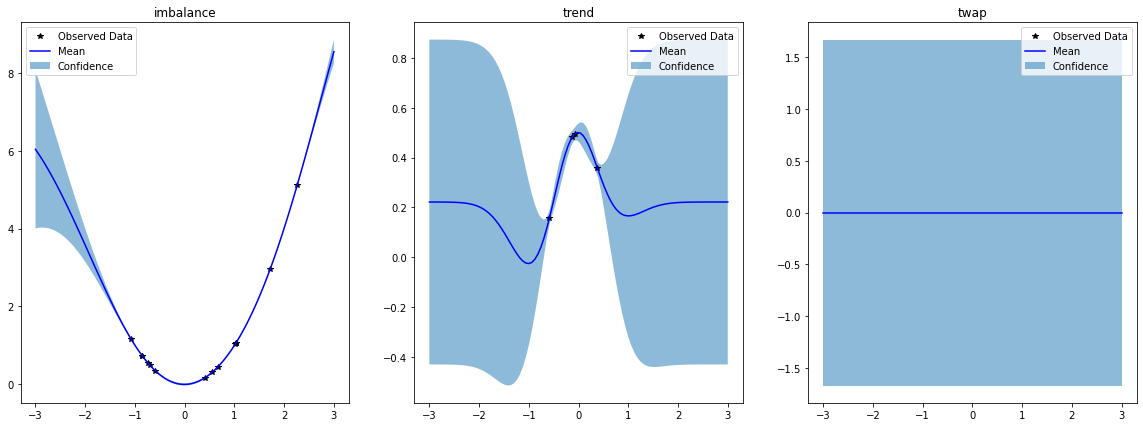

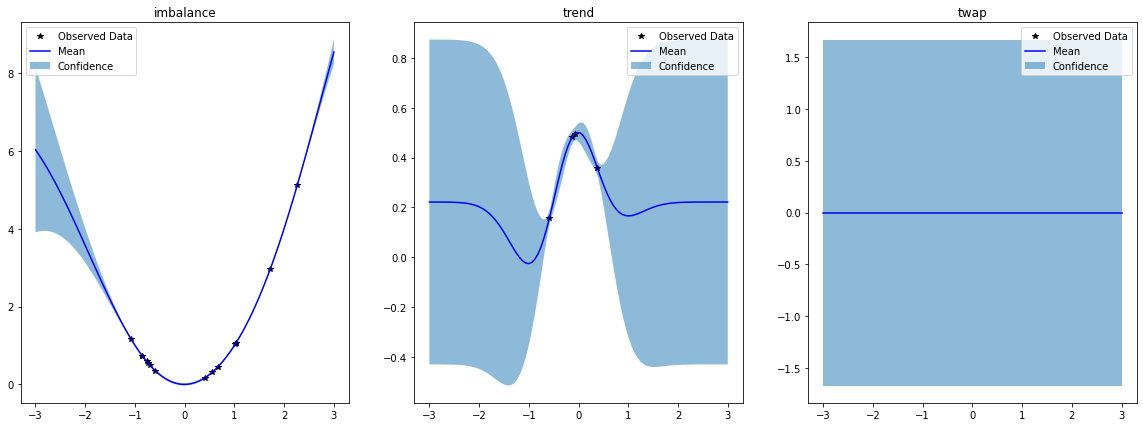

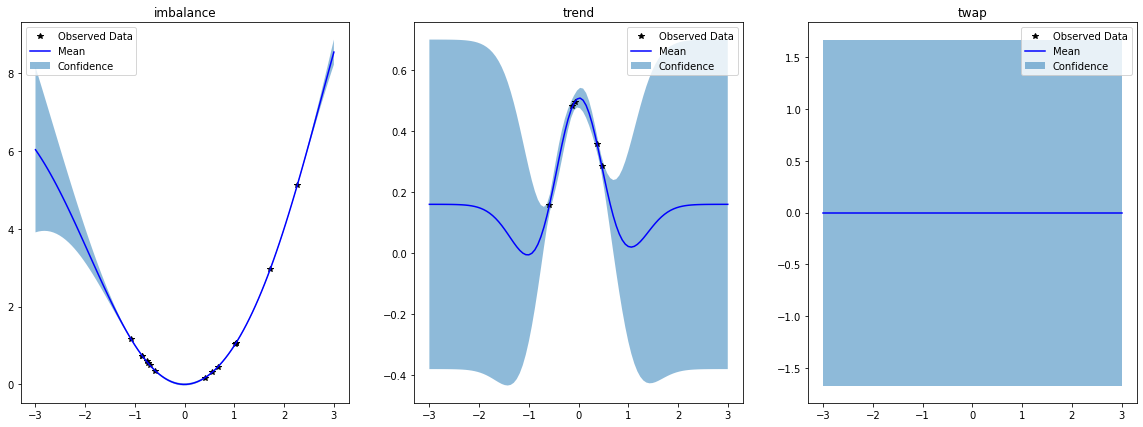

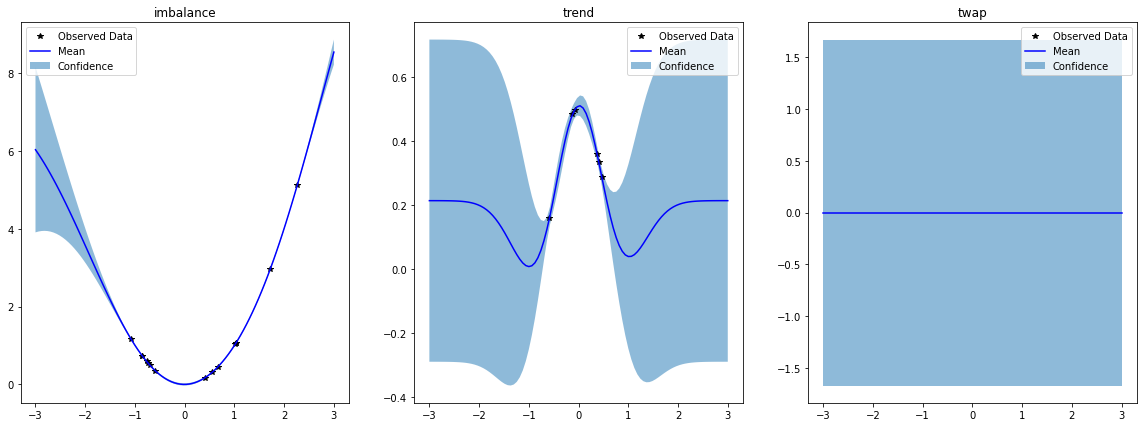

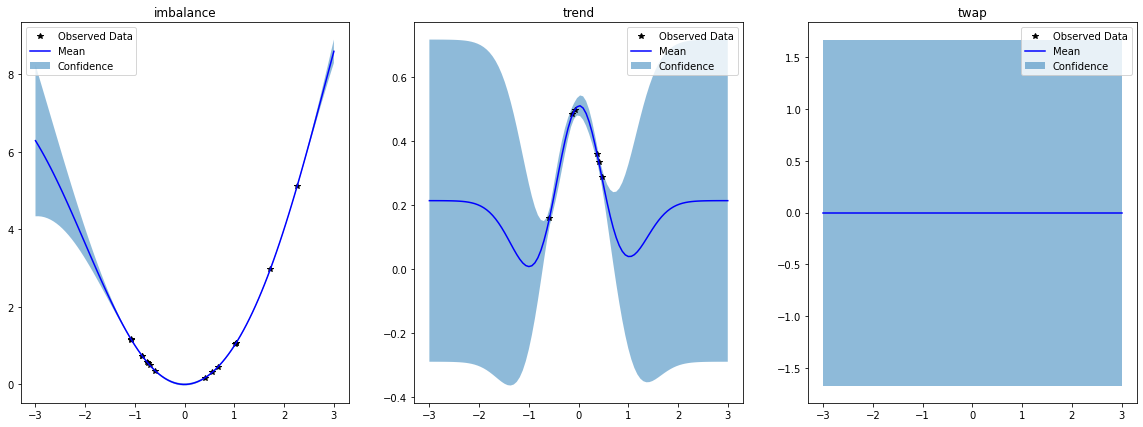

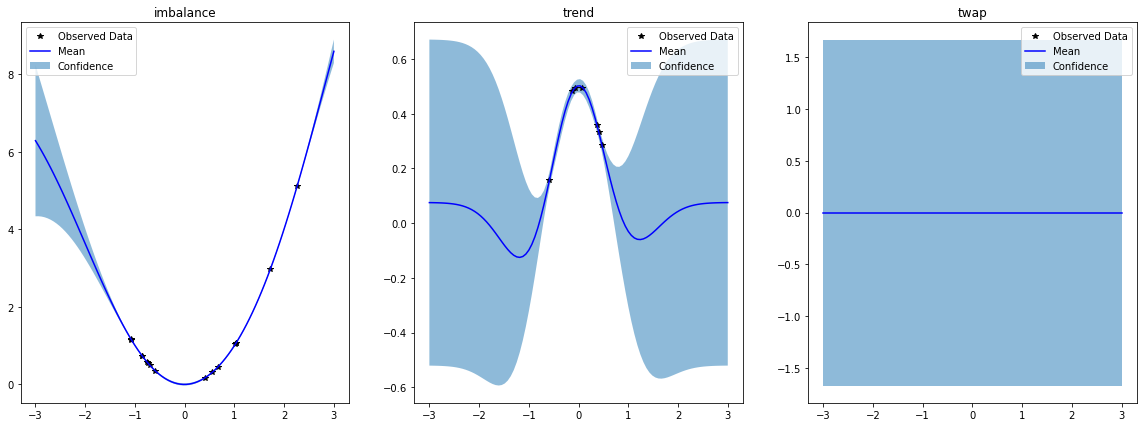

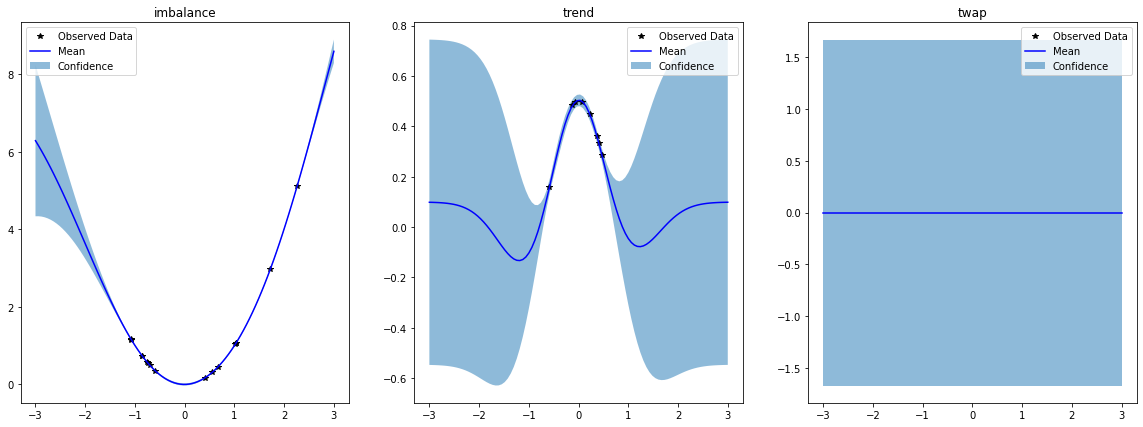

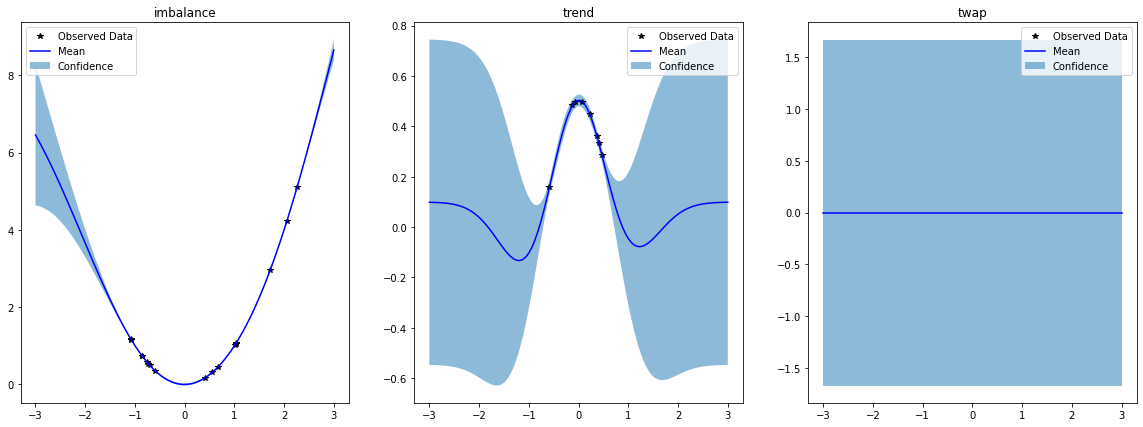

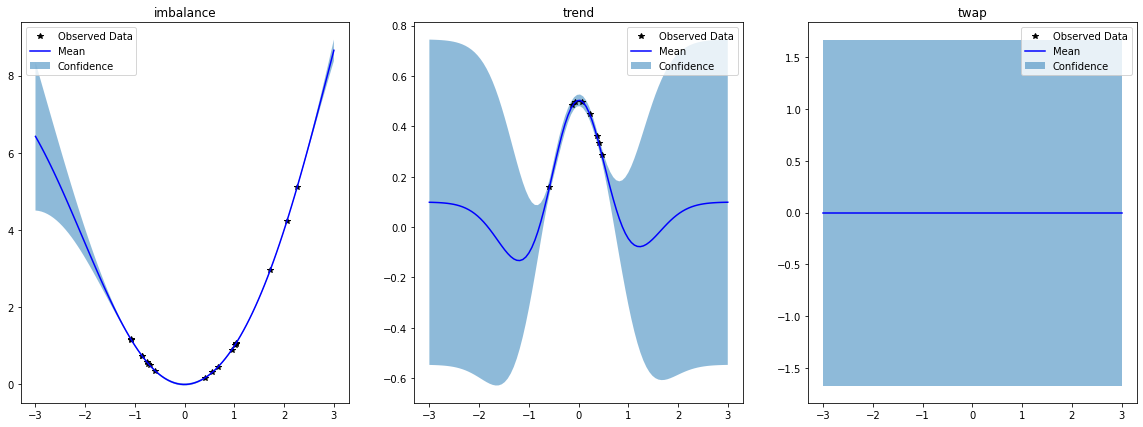

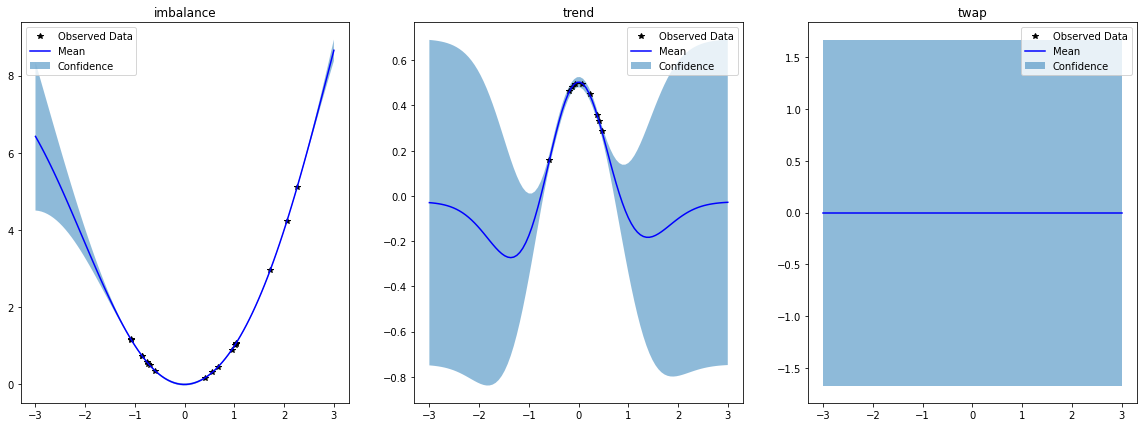

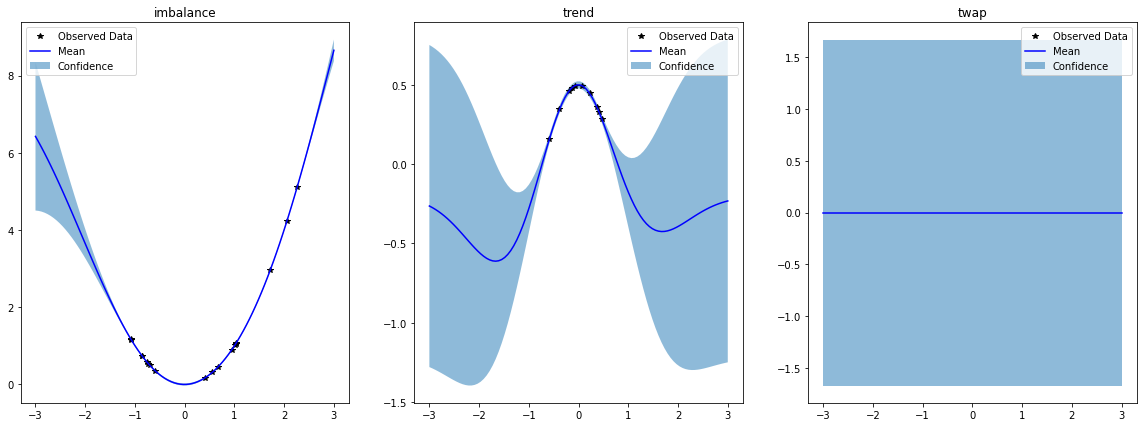

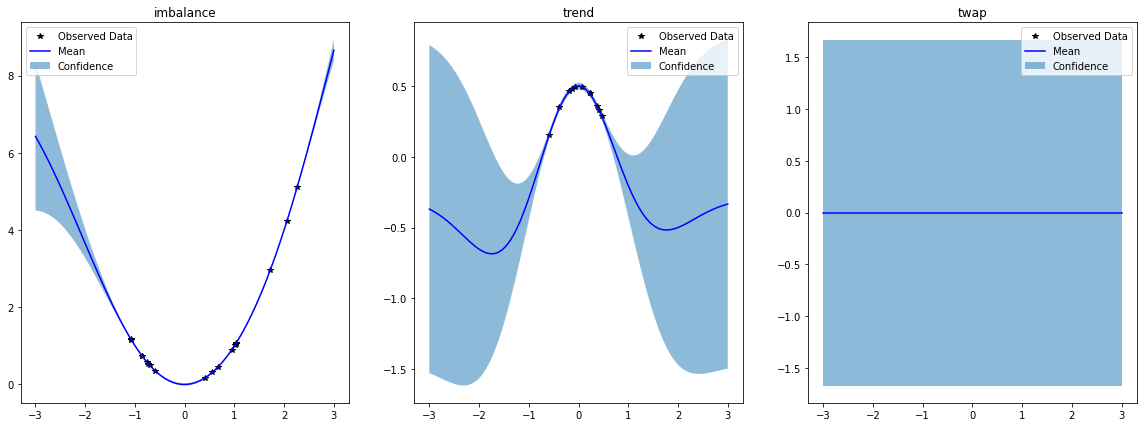

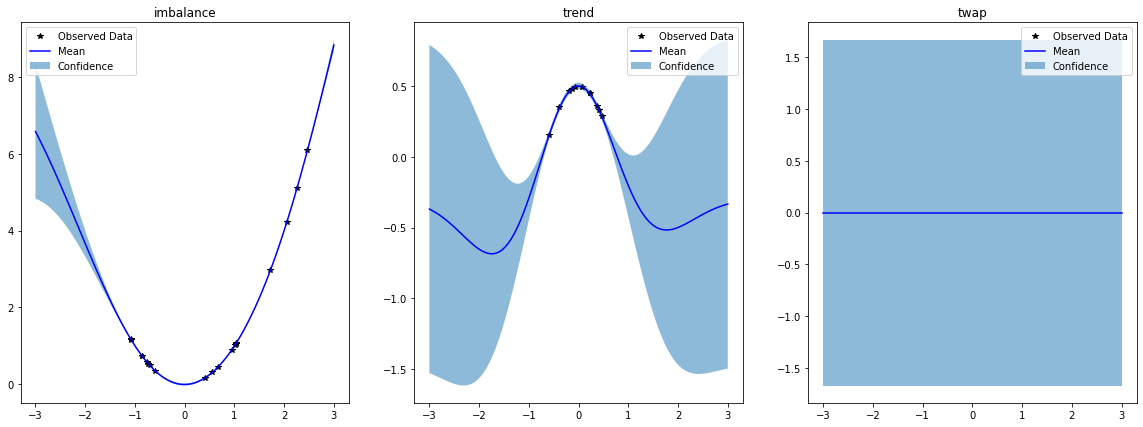

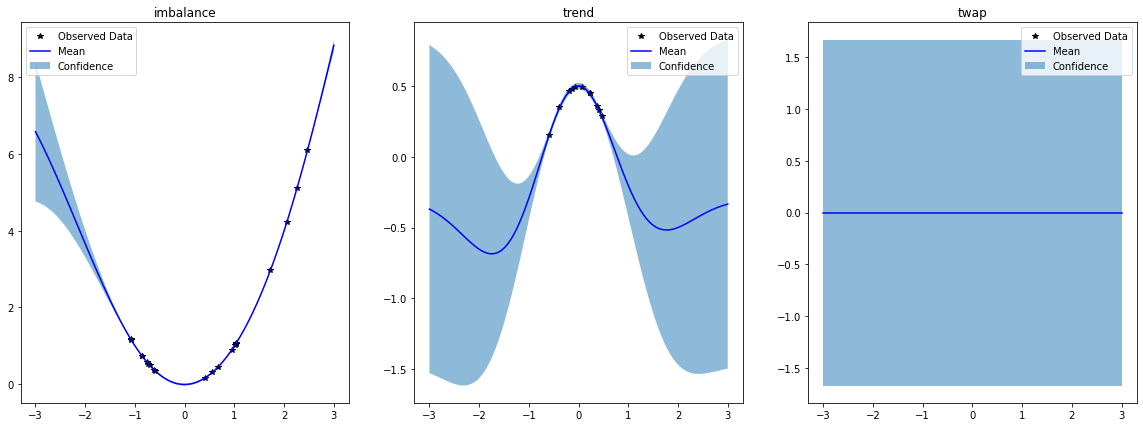

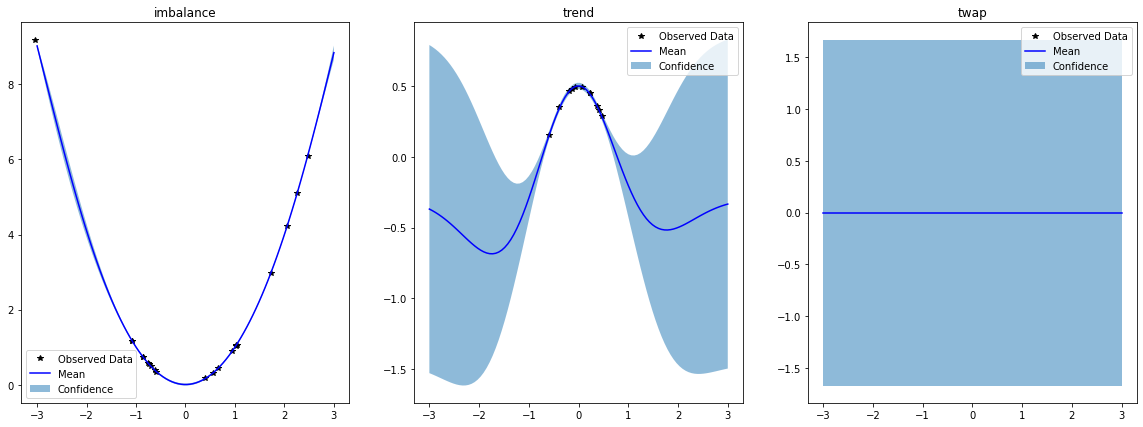

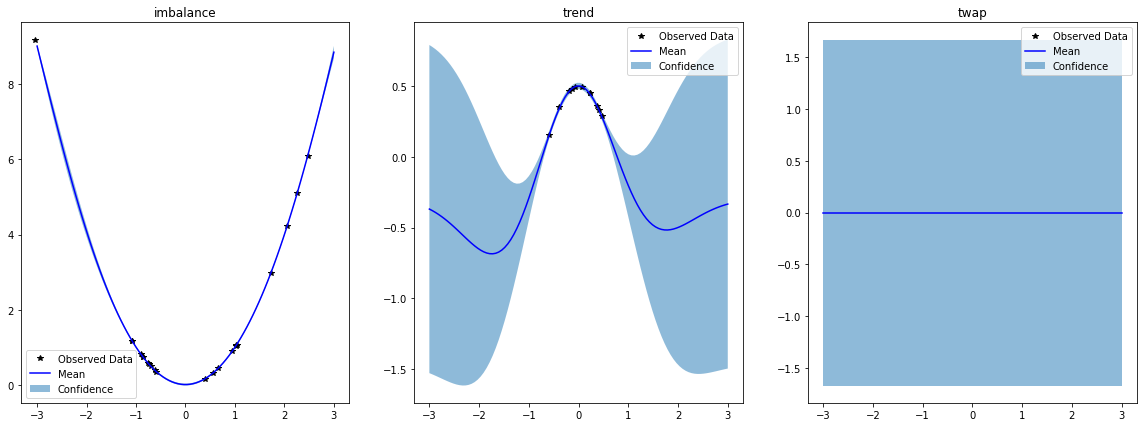

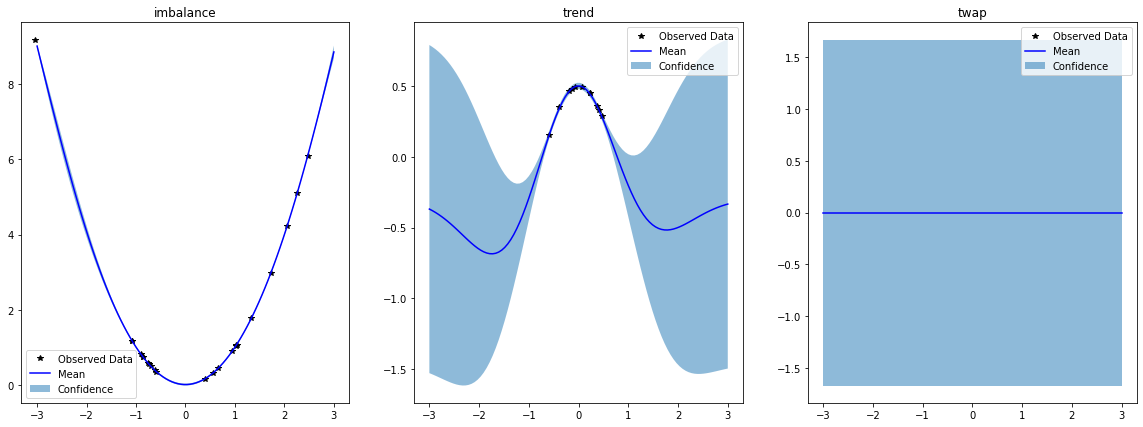

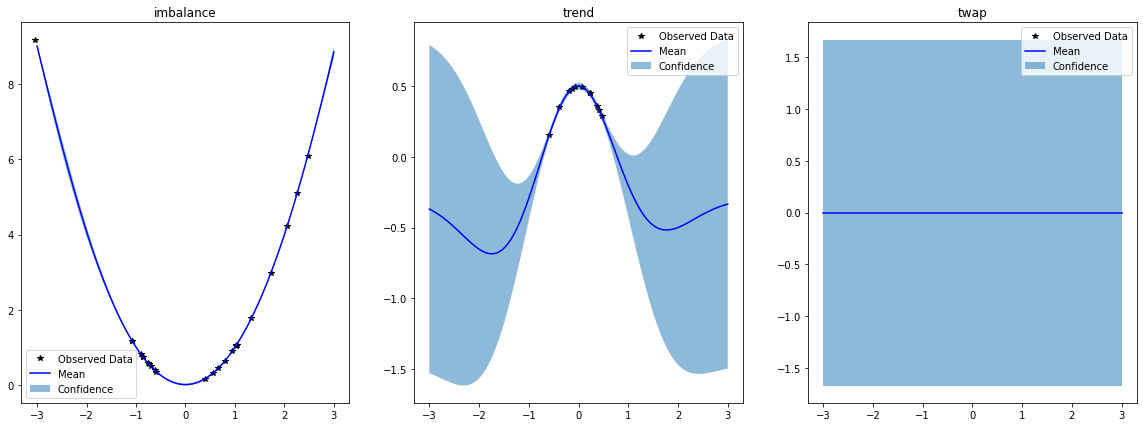

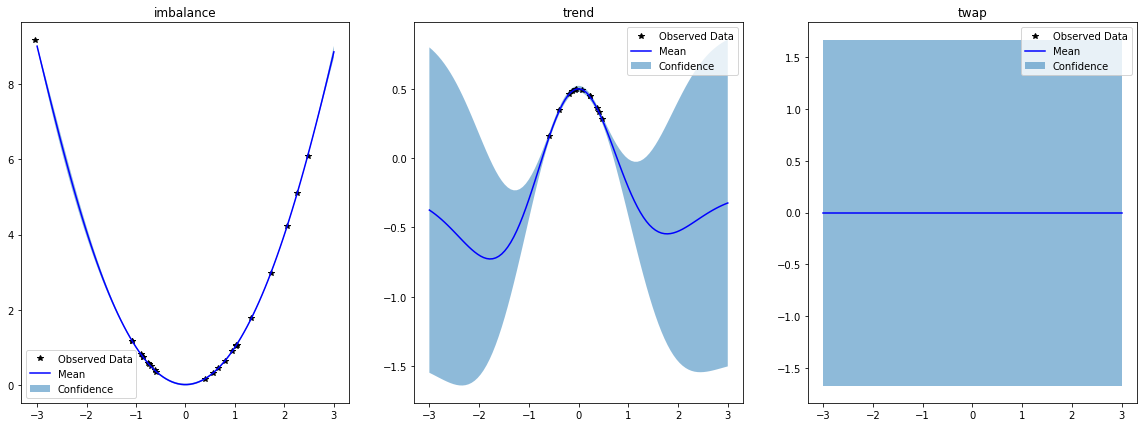

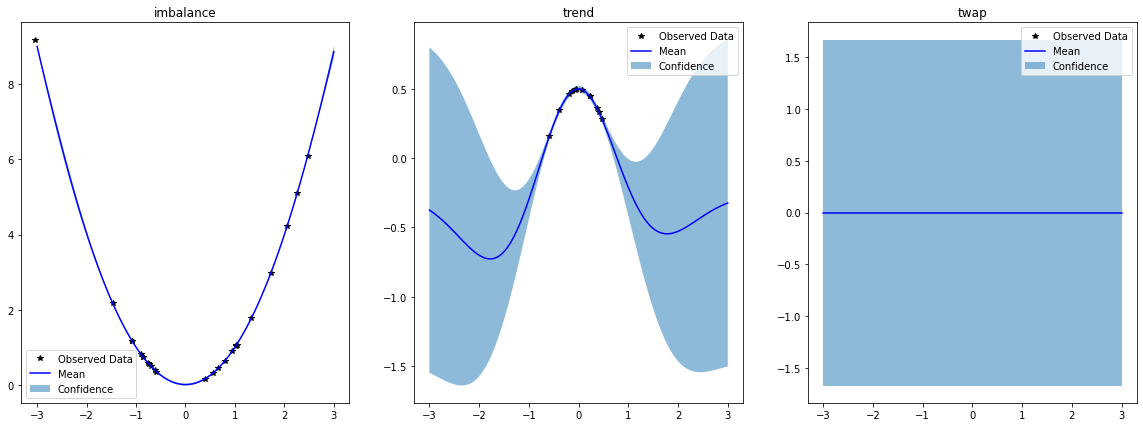

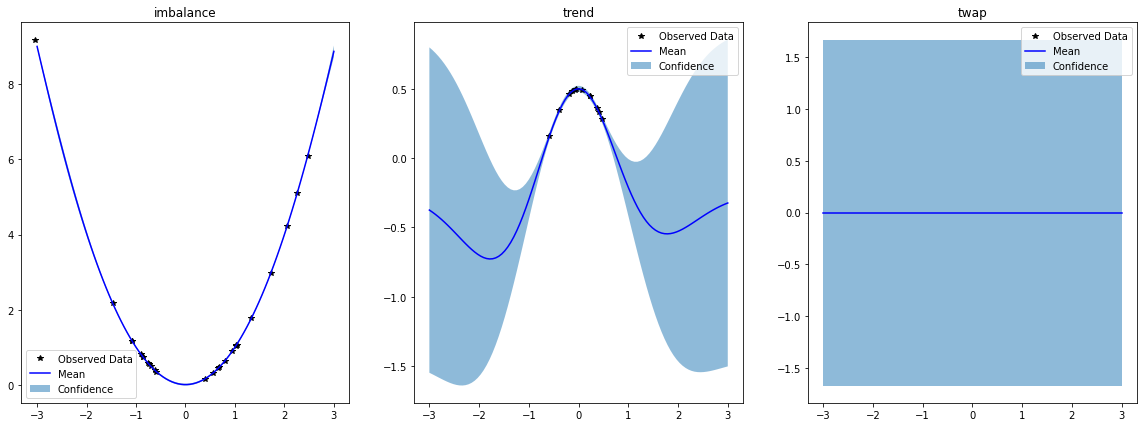

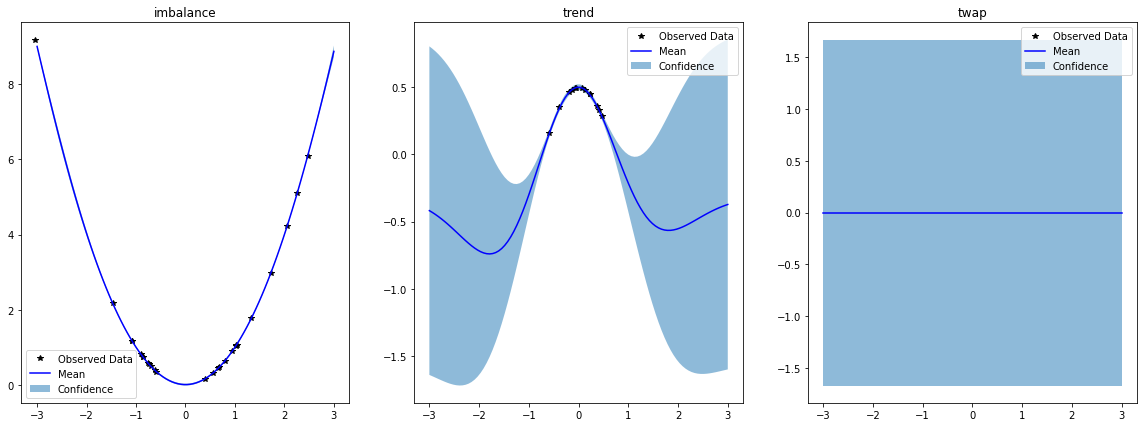

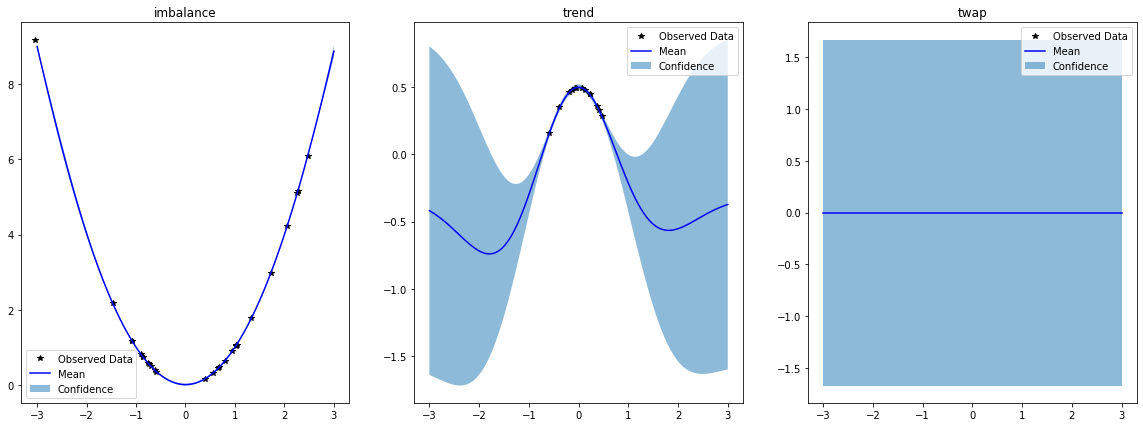

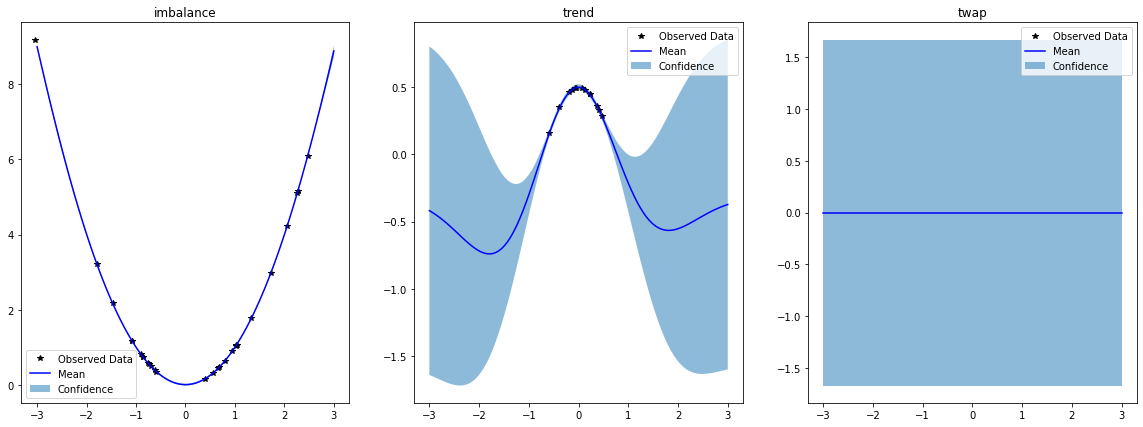

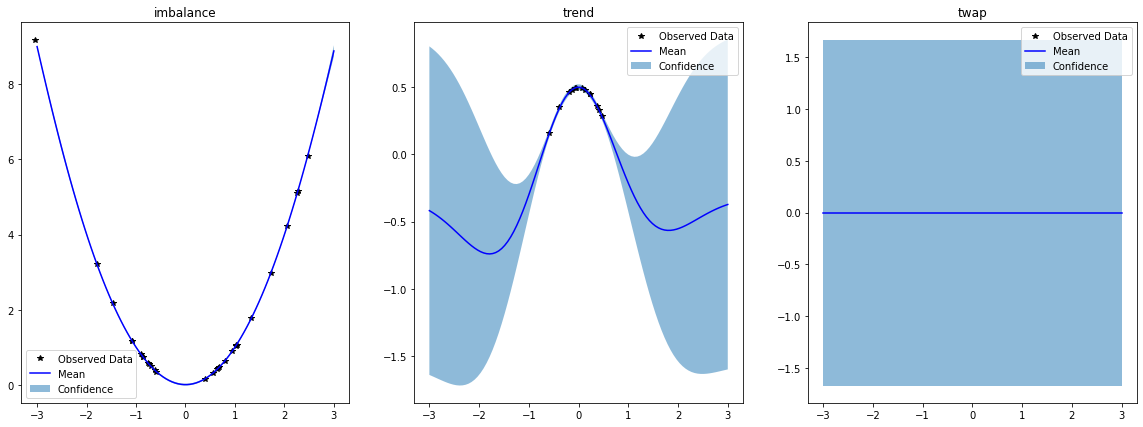

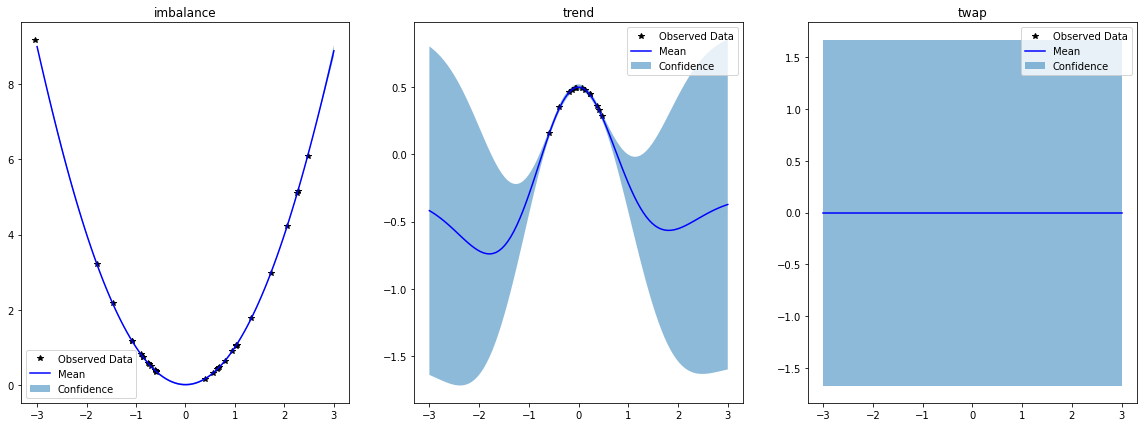

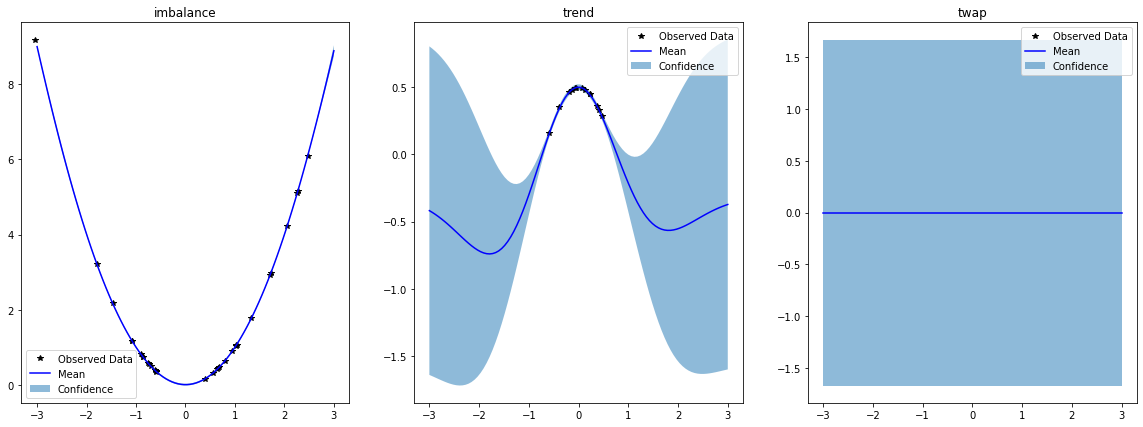

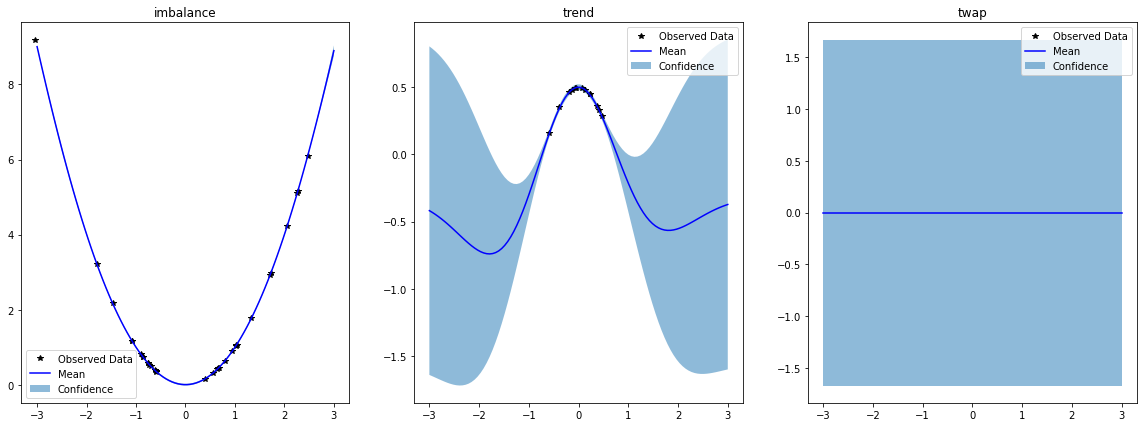

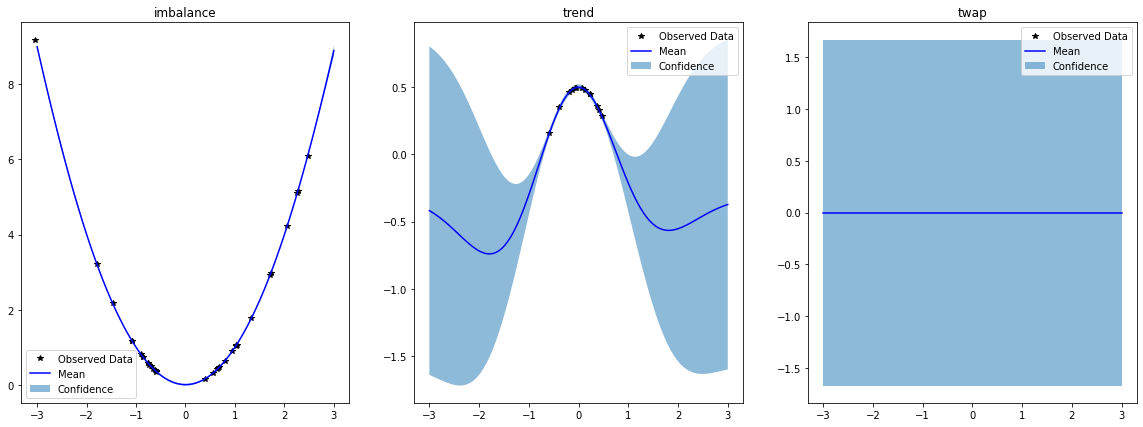

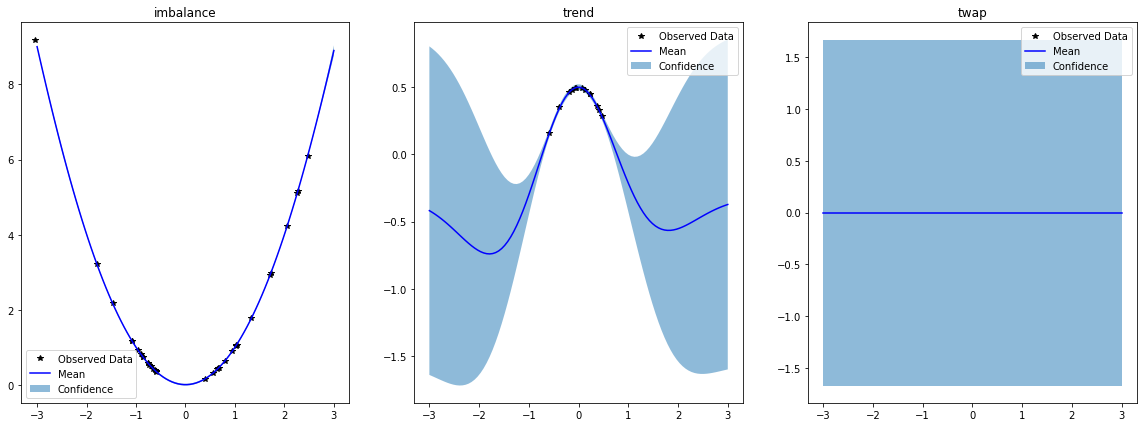

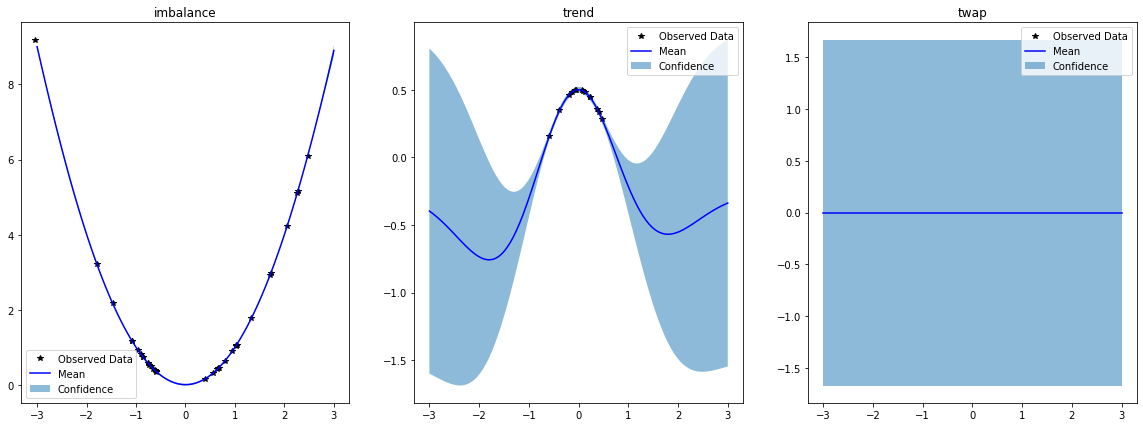

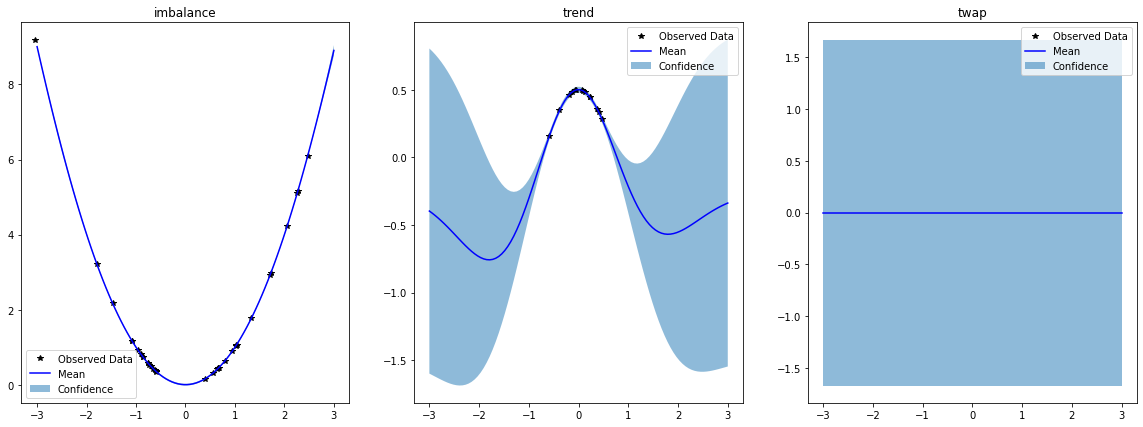

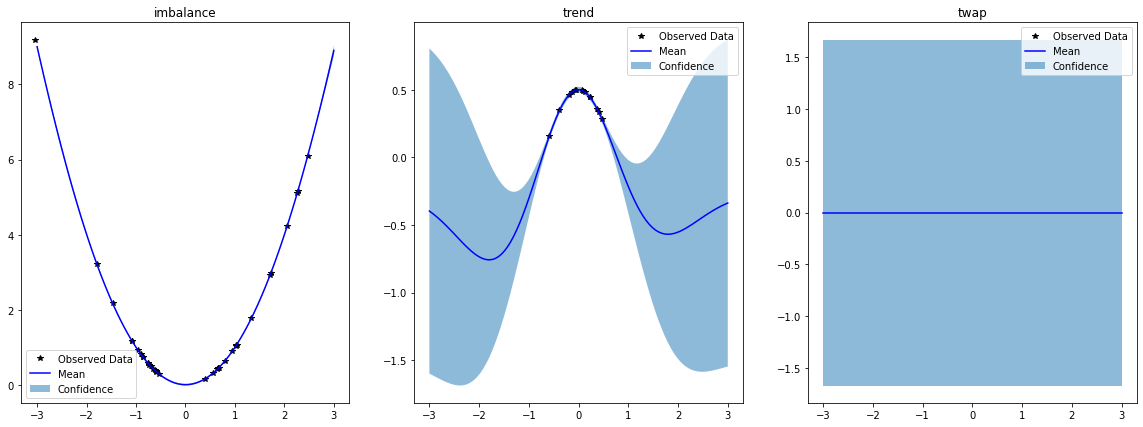

In [19]:
## same with ucb
bandit = gp_bandit(strategies, likelihood, size_buffer, bandit_algo='UCB')
reward_imbalance = lambda x: x**2
reward_trend = lambda x: -x**2 + 0.5
reward_twap = lambda x: -3*x**2 + 1
d = {'vol_50_50000': np.random.normal()}

for i in range(50):
    d['vol_50_50000'] = np.random.normal()
    feature_values = pd.Series(data=d, index=['vol_50_50000'])
    best_strategy_bandit  = bandit.select_best_strategy(feature_values)
    
    if best_strategy_bandit == "imbalance":
        reward = reward_imbalance(d['vol_50_50000'])
    elif best_strategy_bandit == "trend":
        reward = reward_trend(d['vol_50_50000'])
    else:
        reward = reward_twap(d['vol_50_50000']) 
    
    bandit.update_data(feature_values, best_strategy_bandit, reward, retrain_hyperparameters = True)
    
    bandit.plot_fit_all()

/home/pierre/miniconda3/envs/exec/lib/python3.9/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


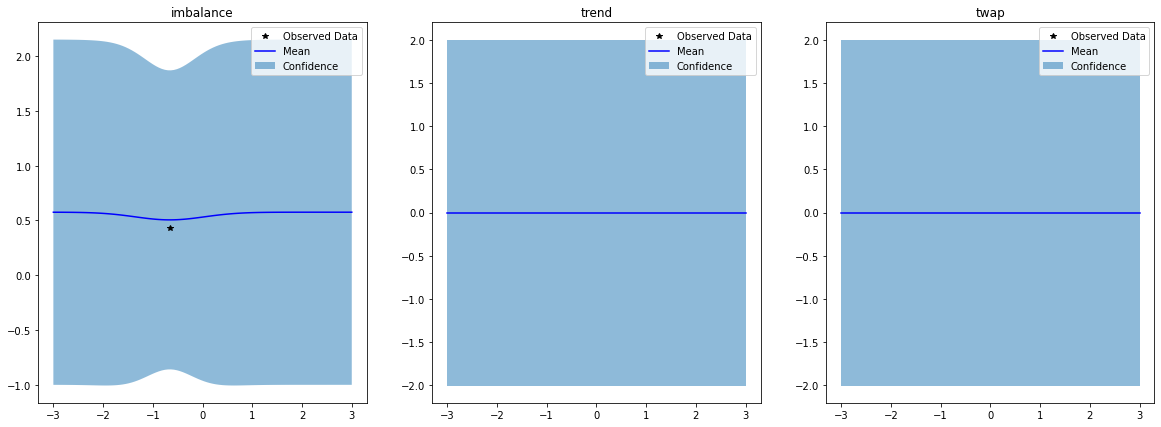

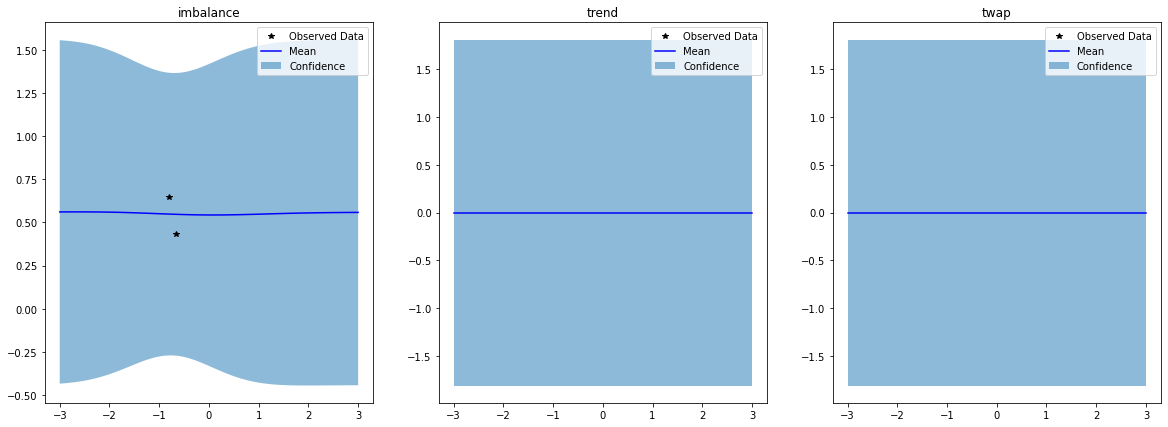

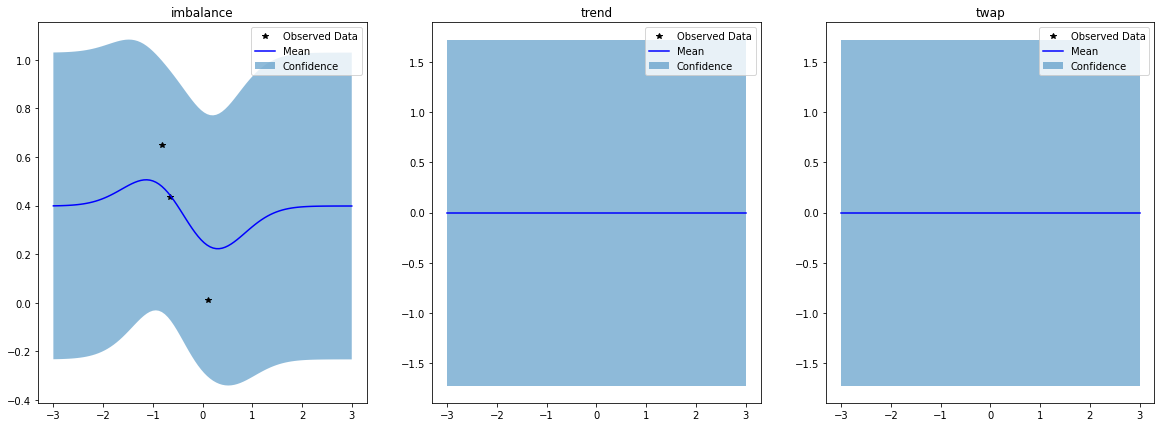

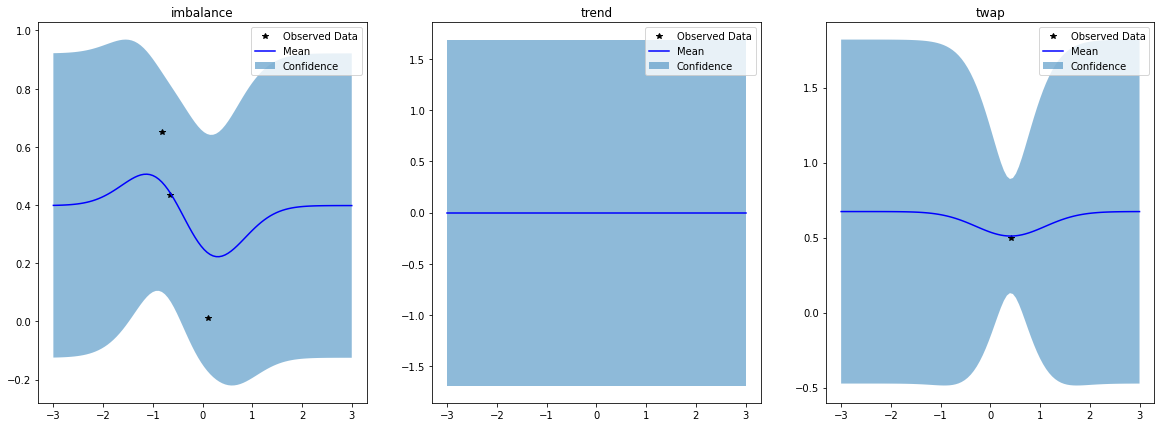

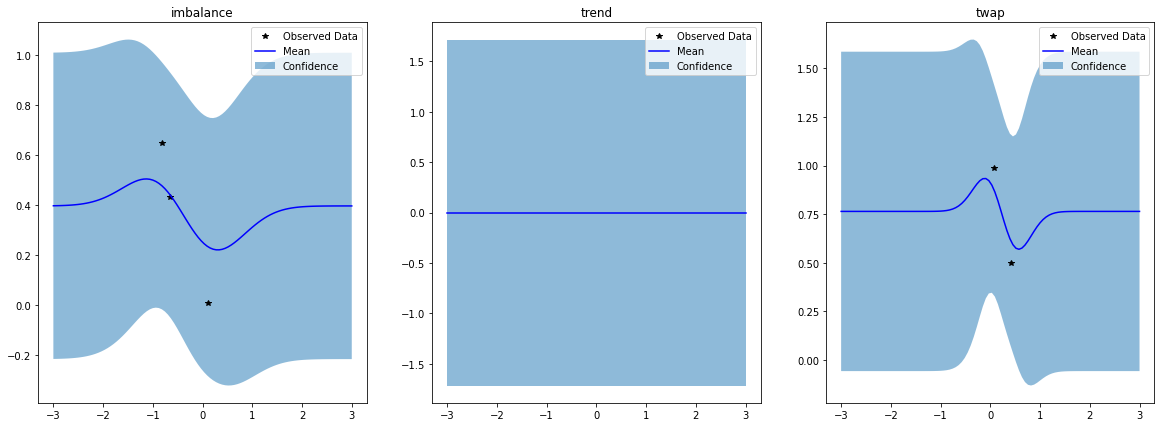

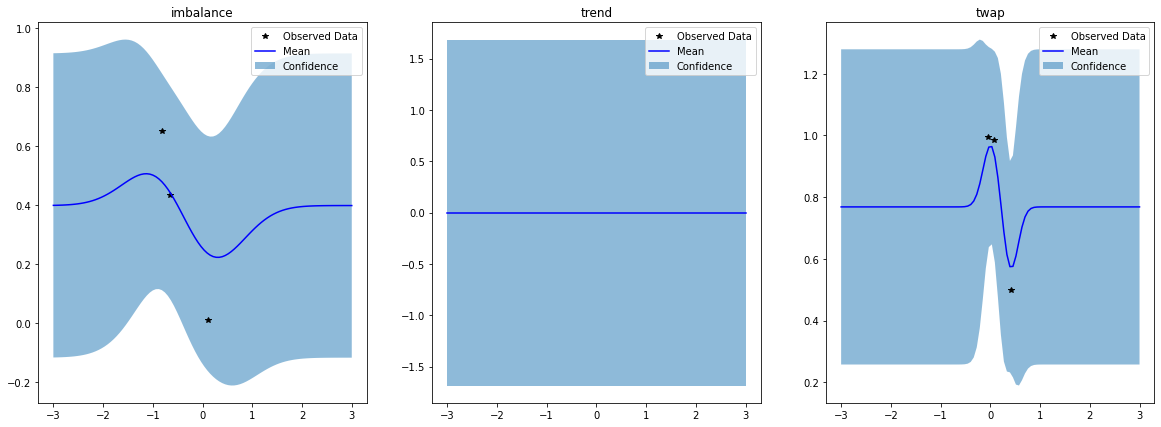

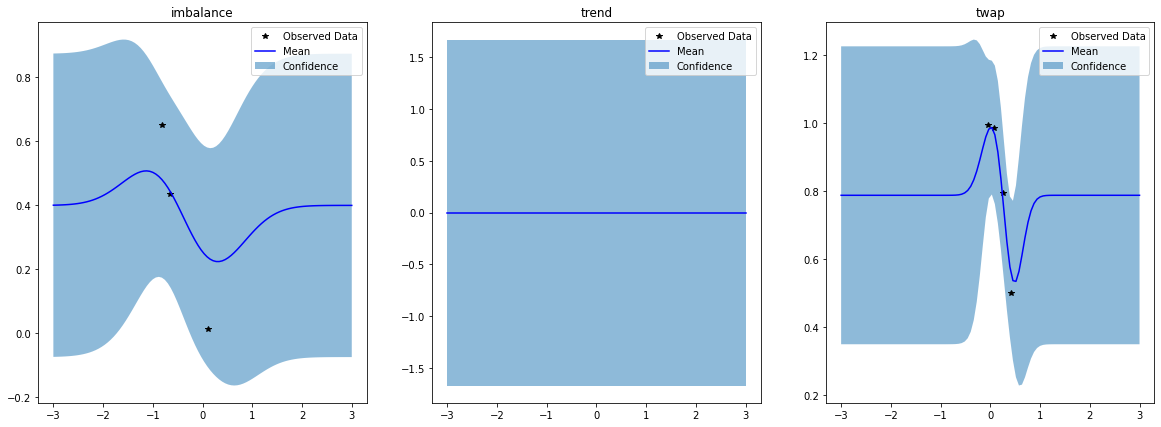

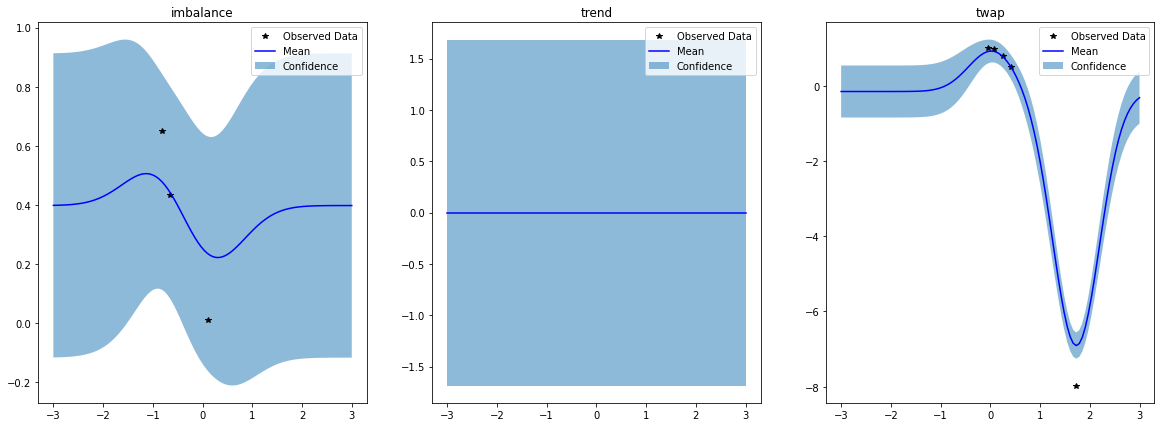

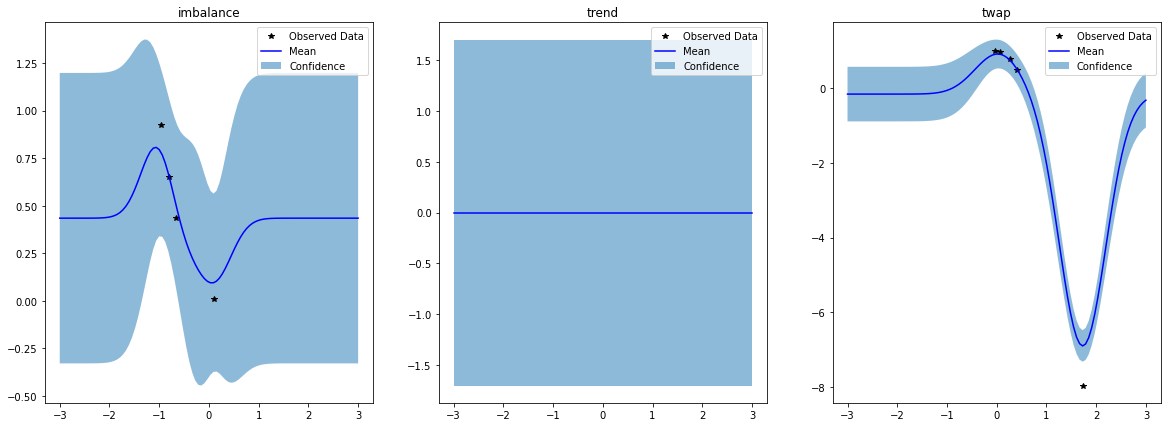

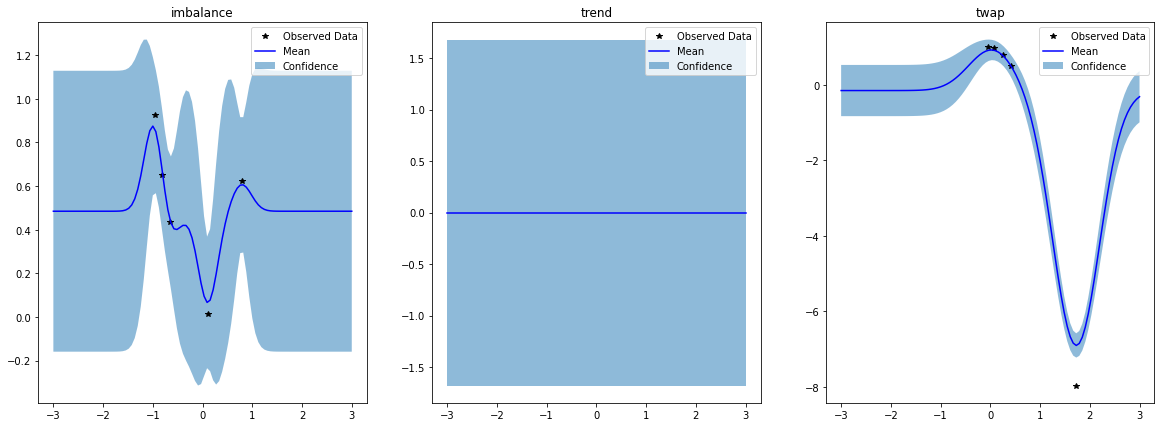

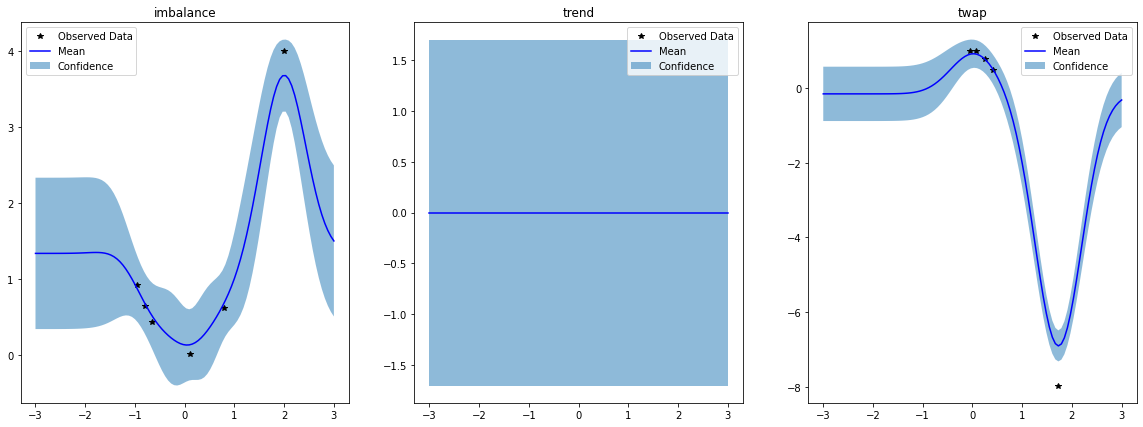

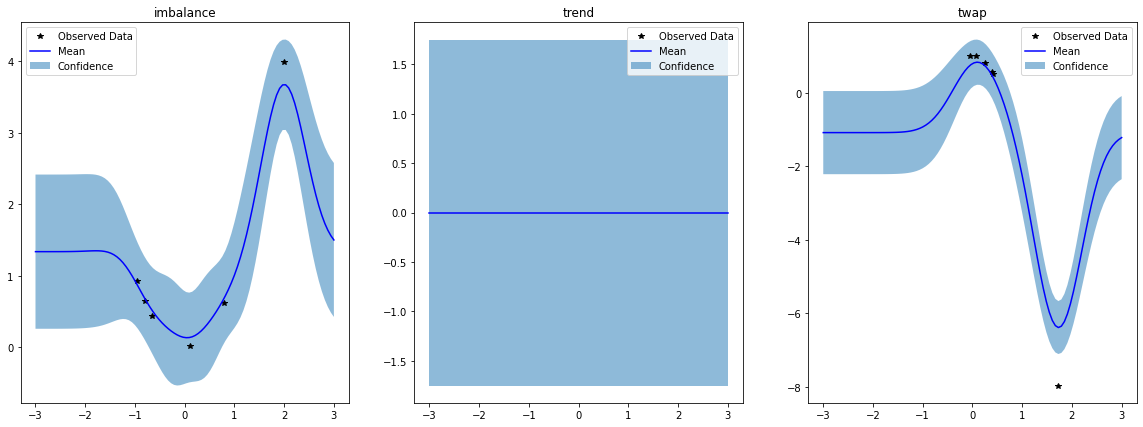

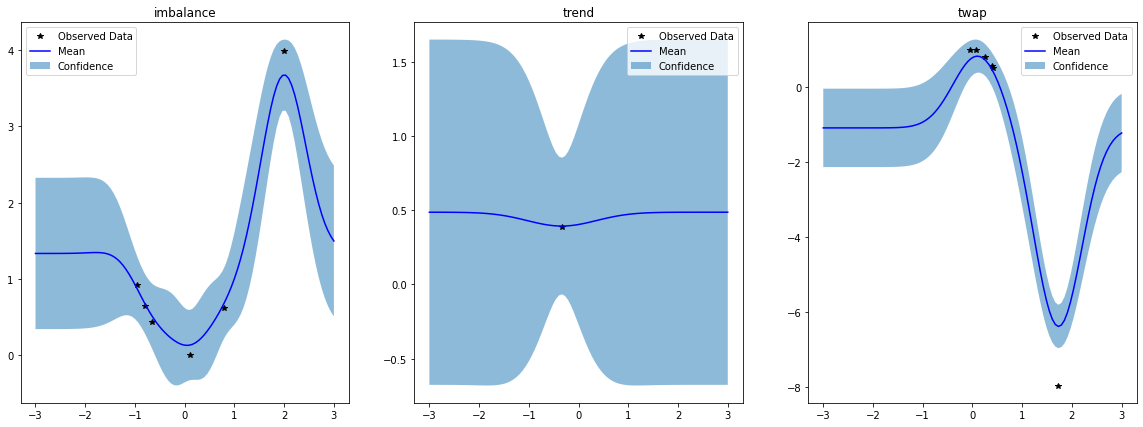

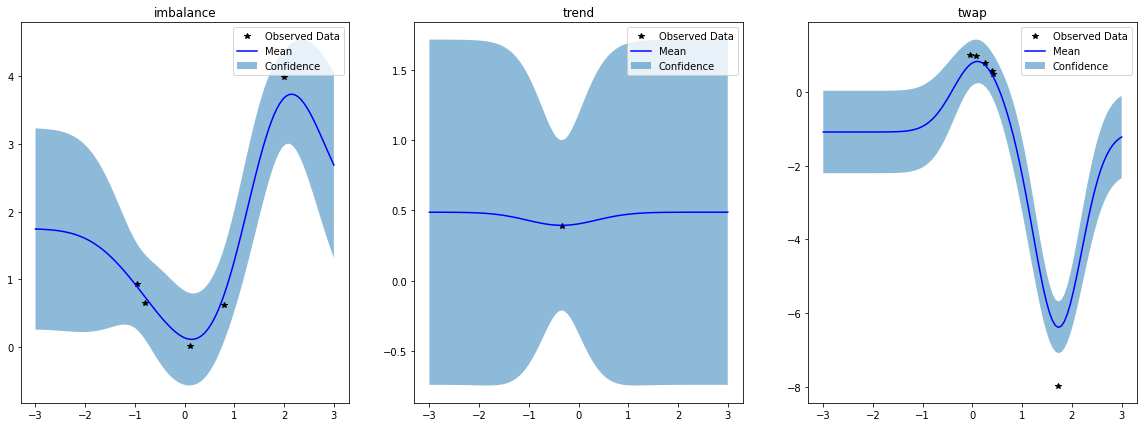

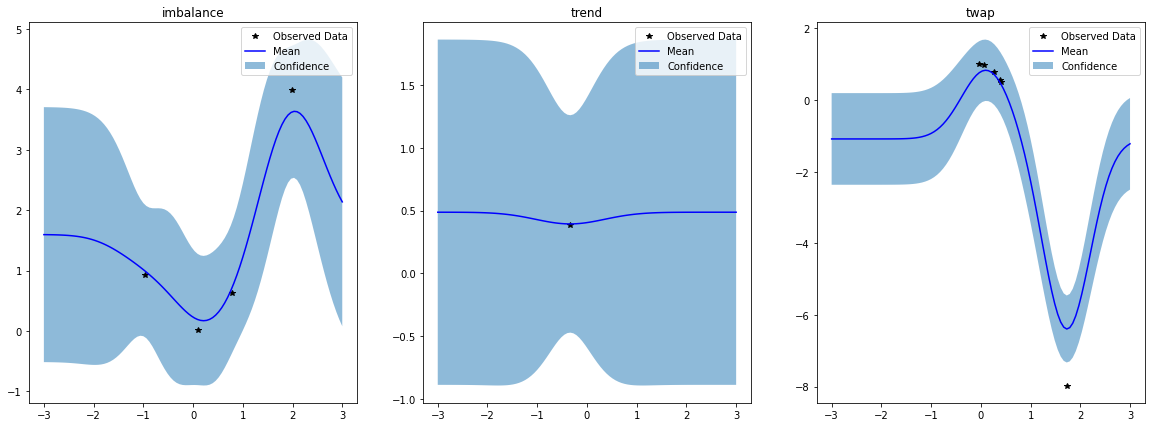

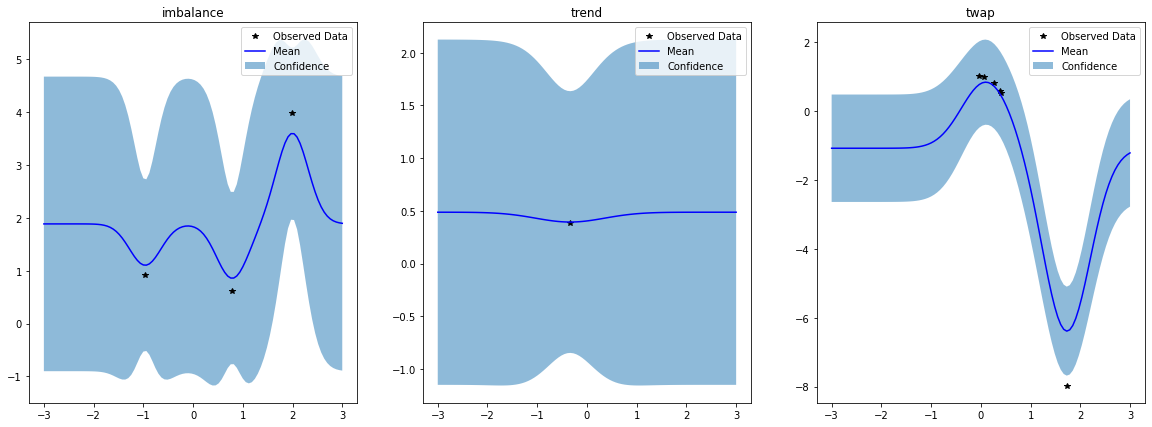

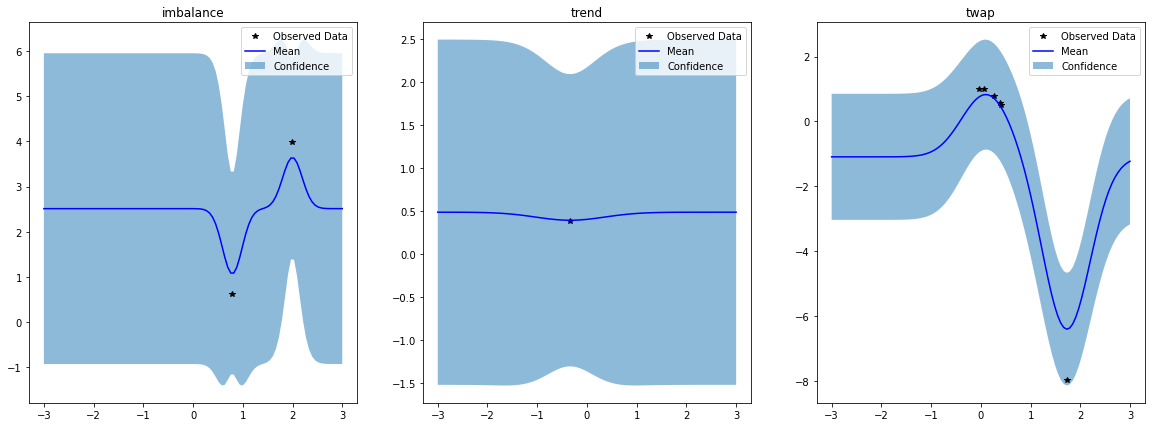

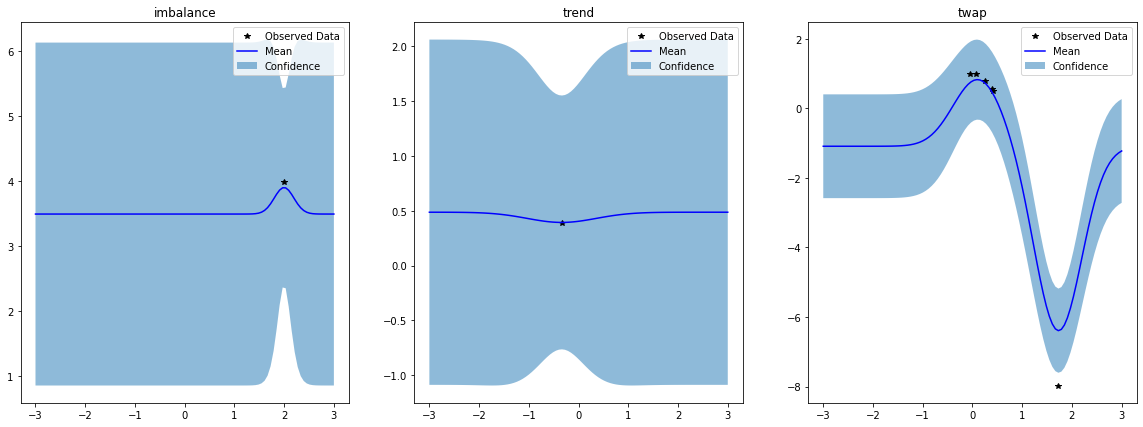

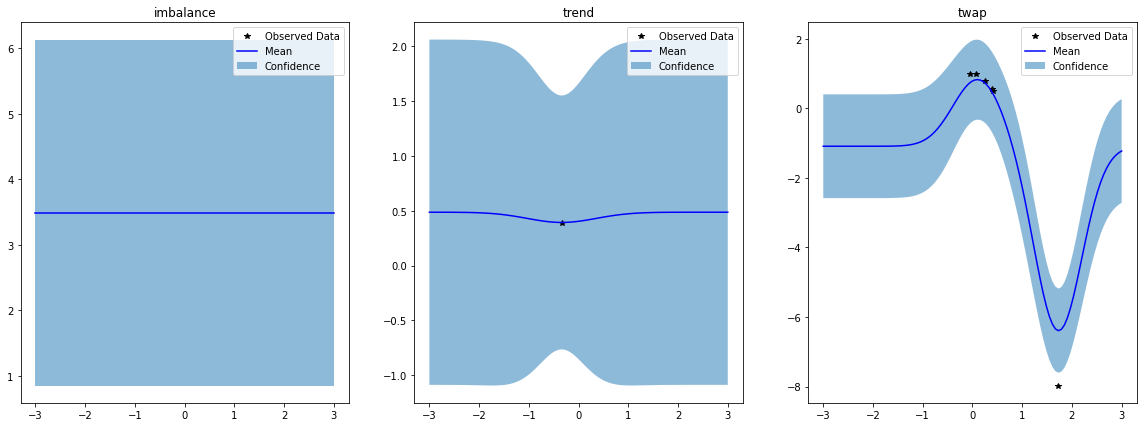

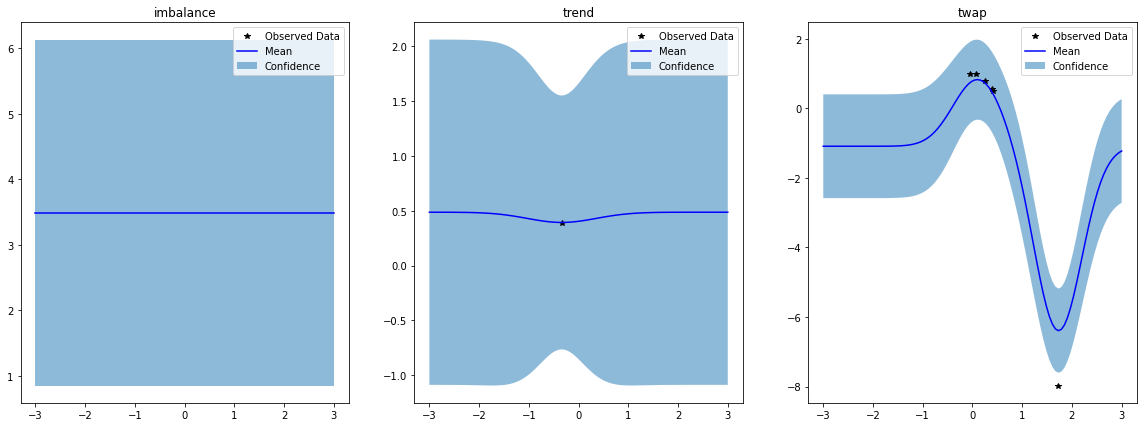

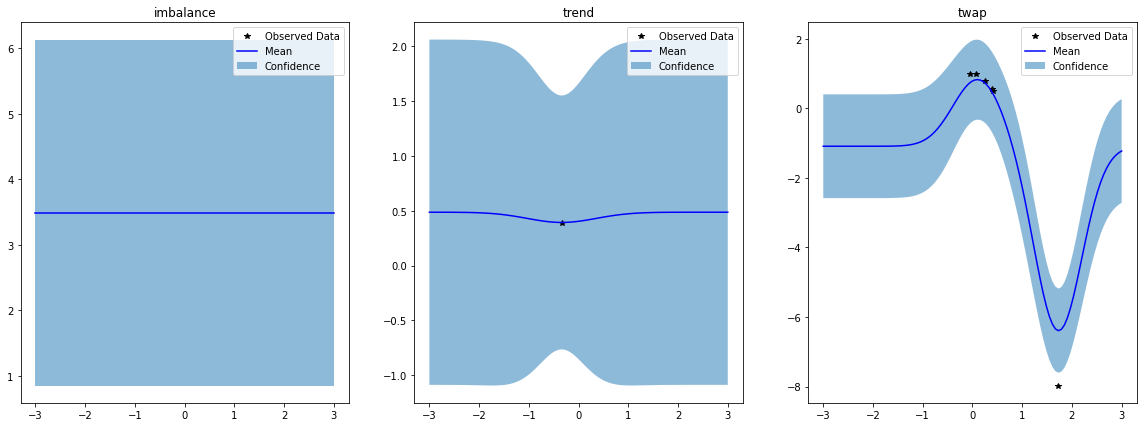

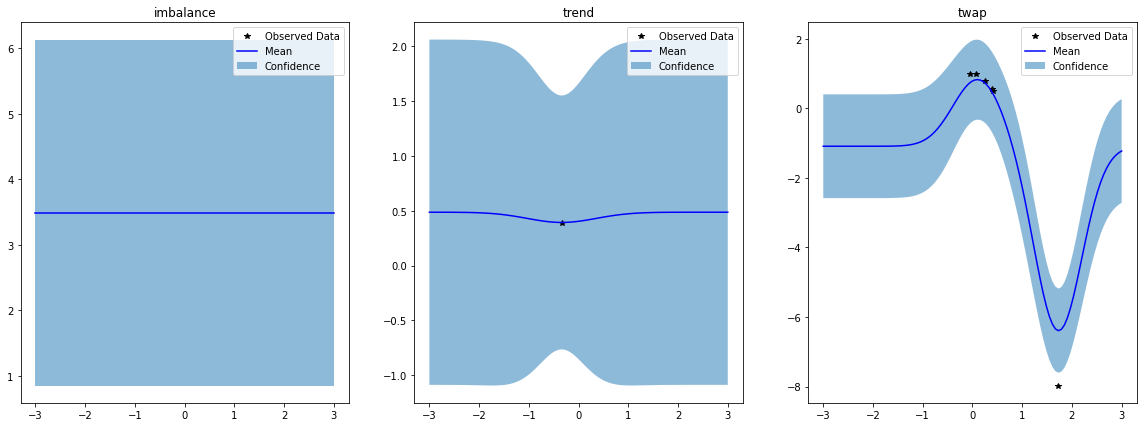

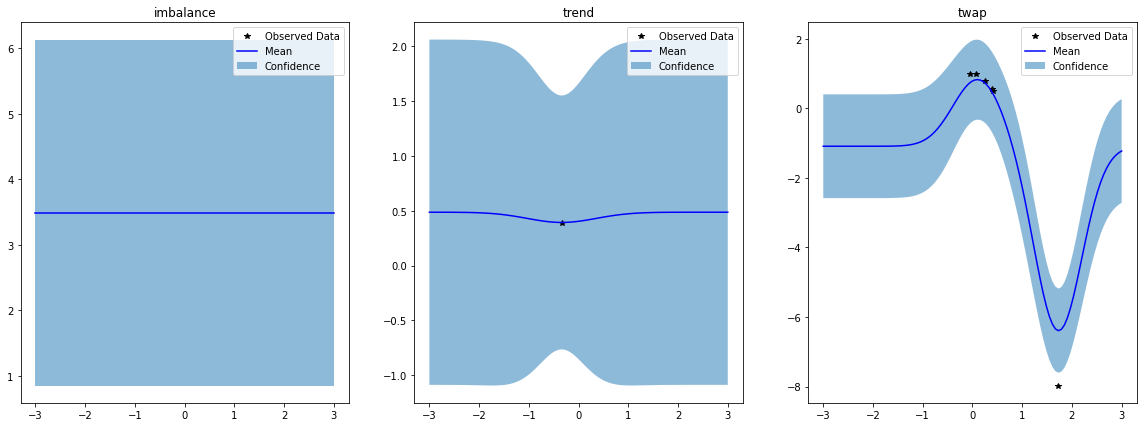

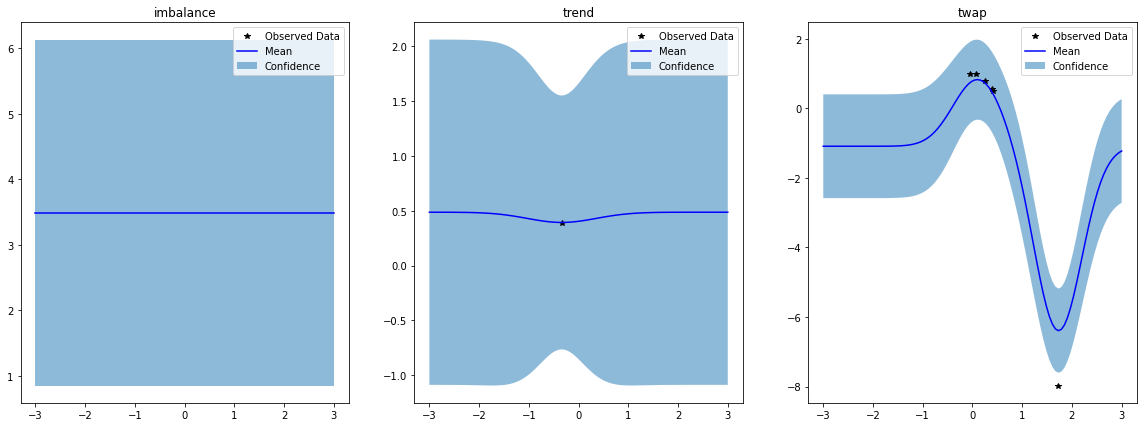

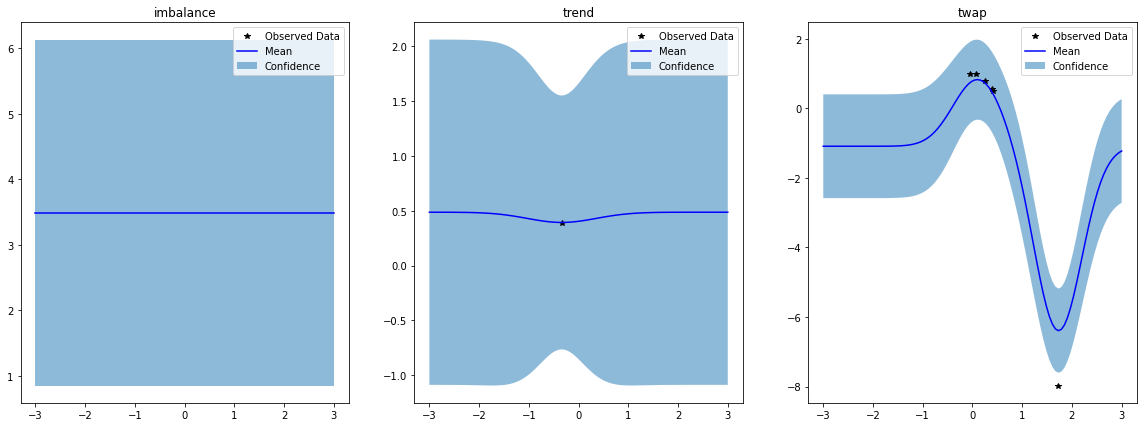

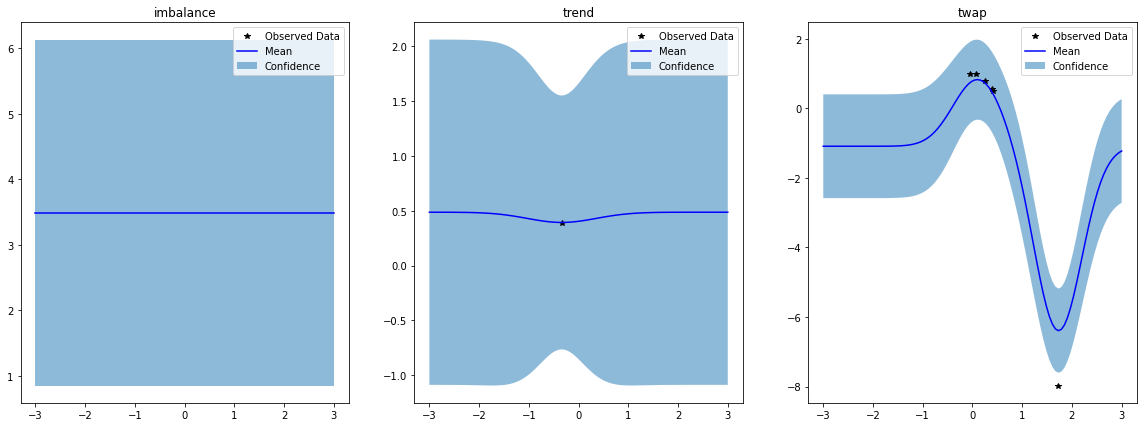

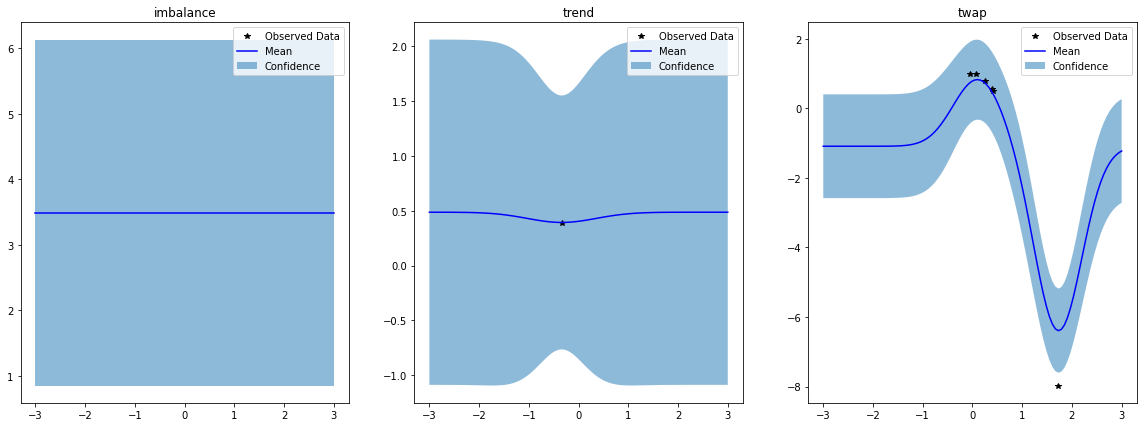

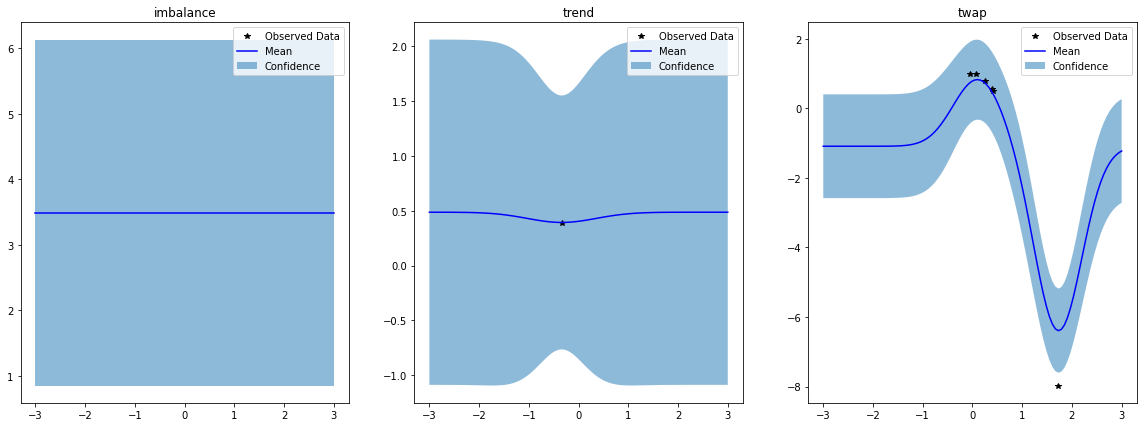

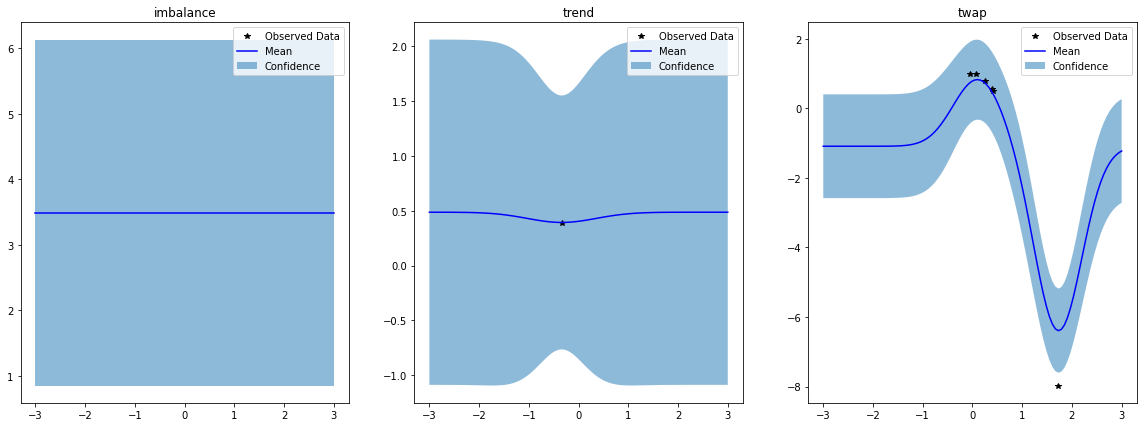

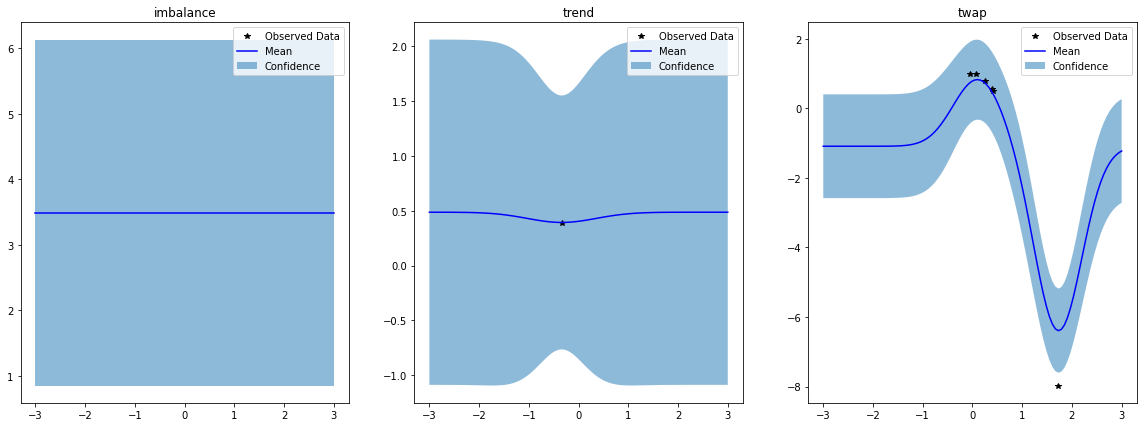

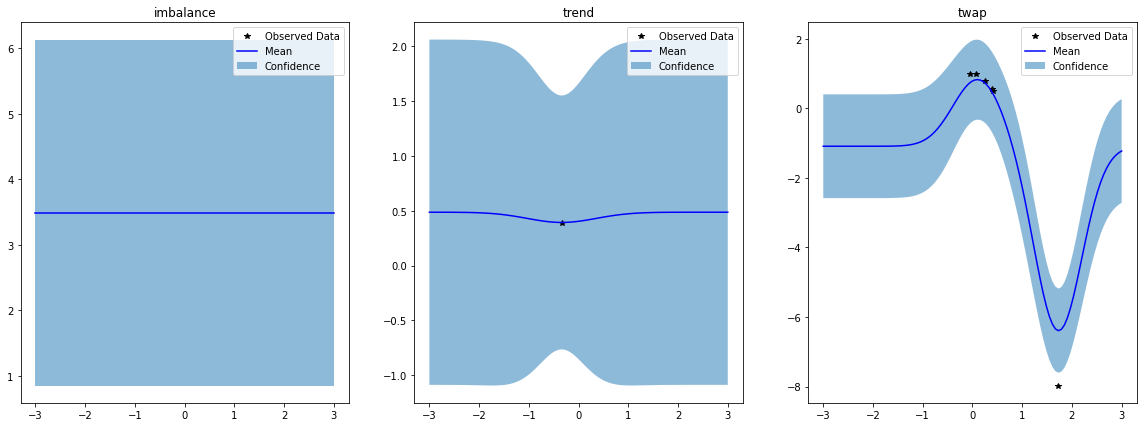

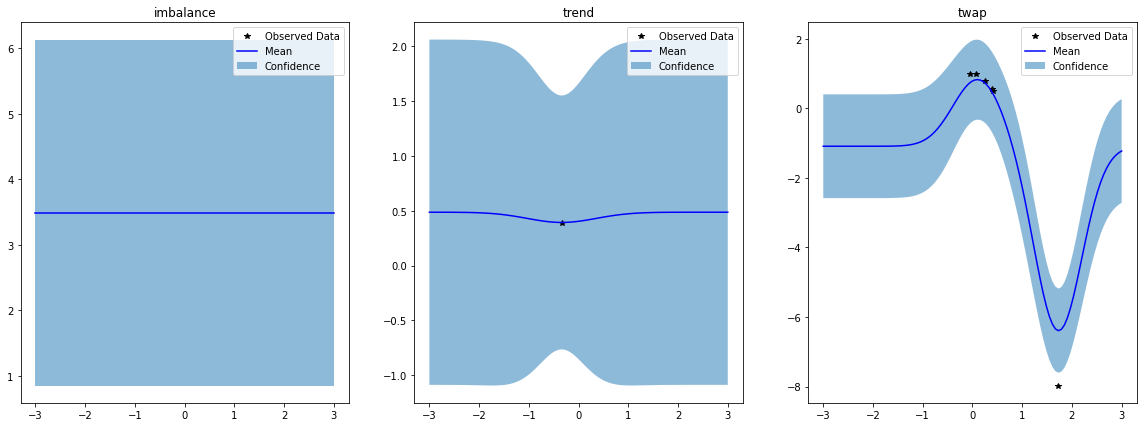

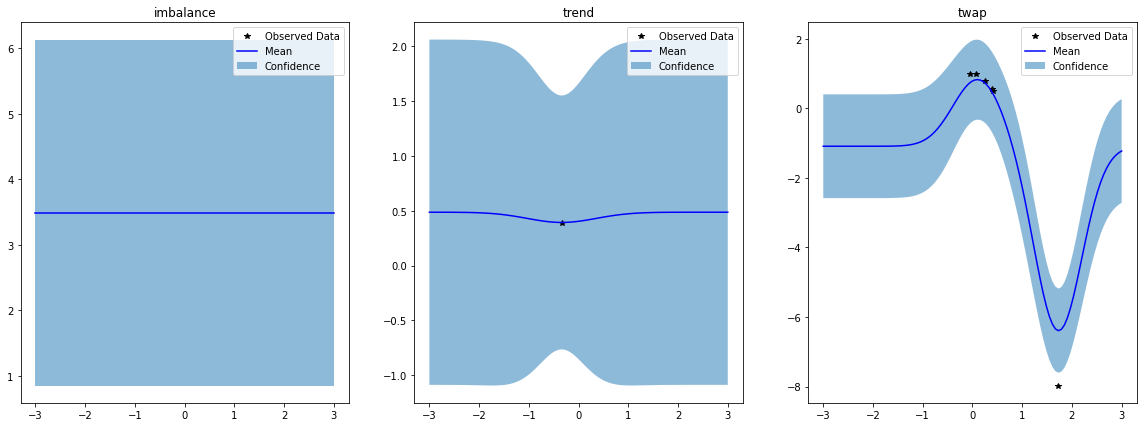

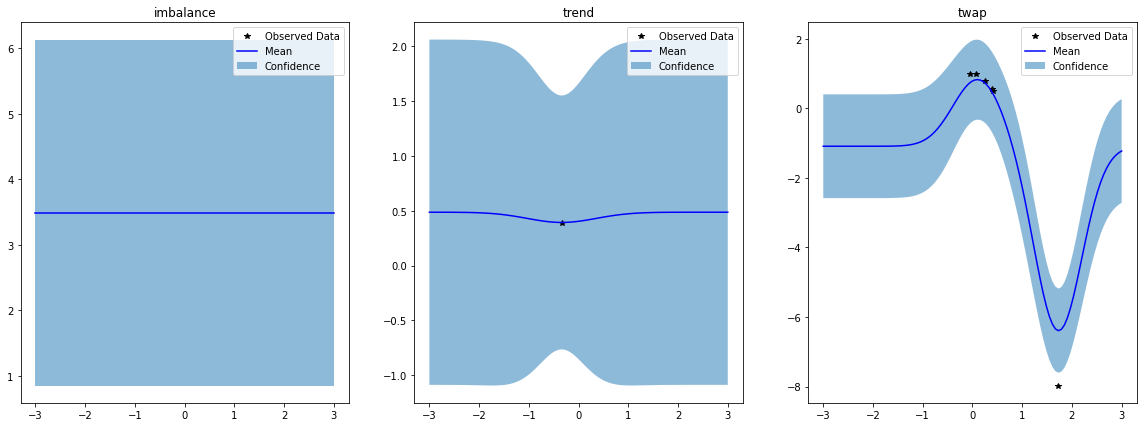

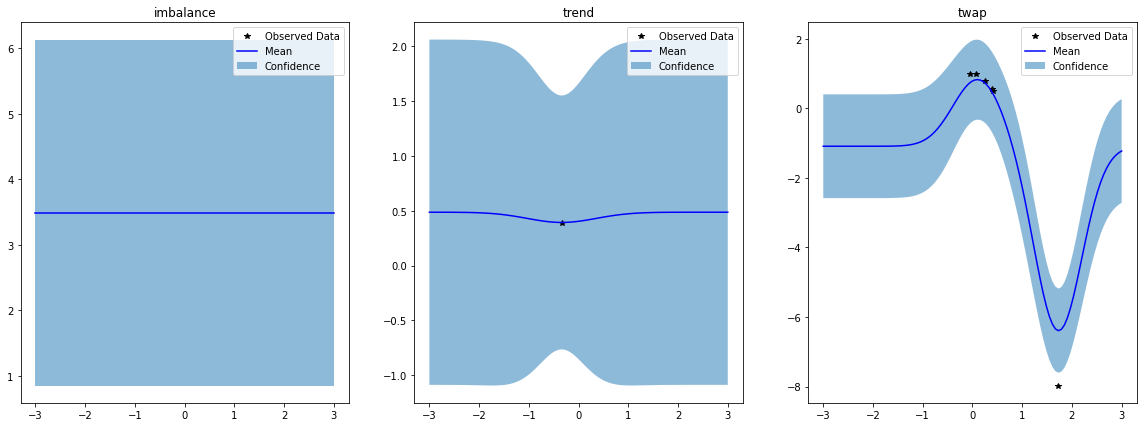

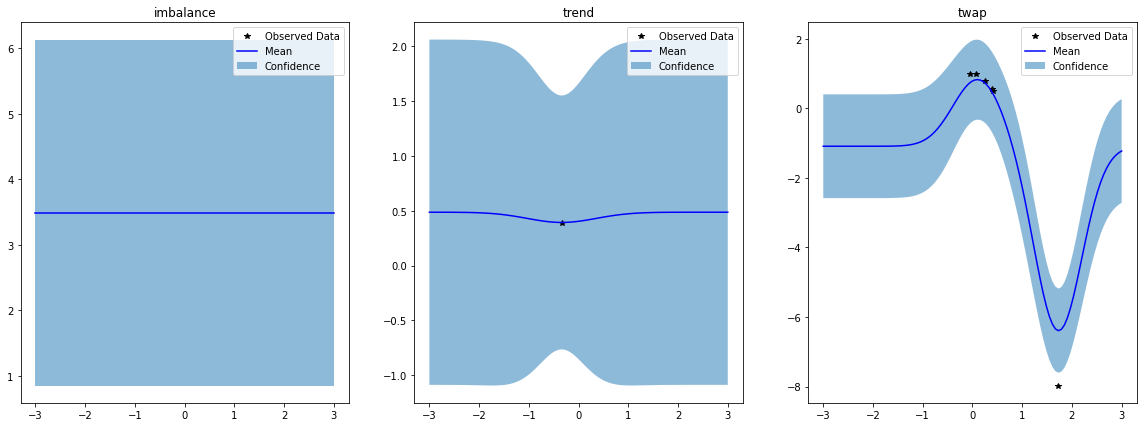

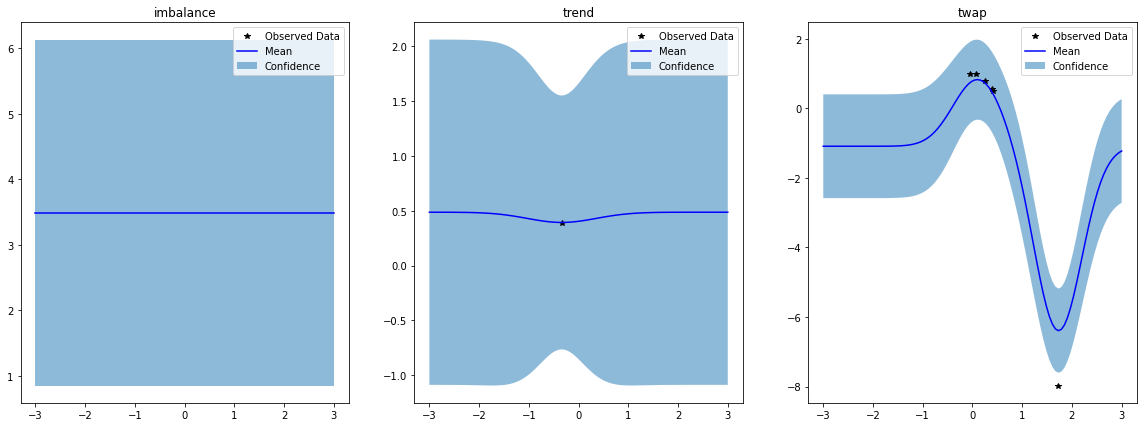

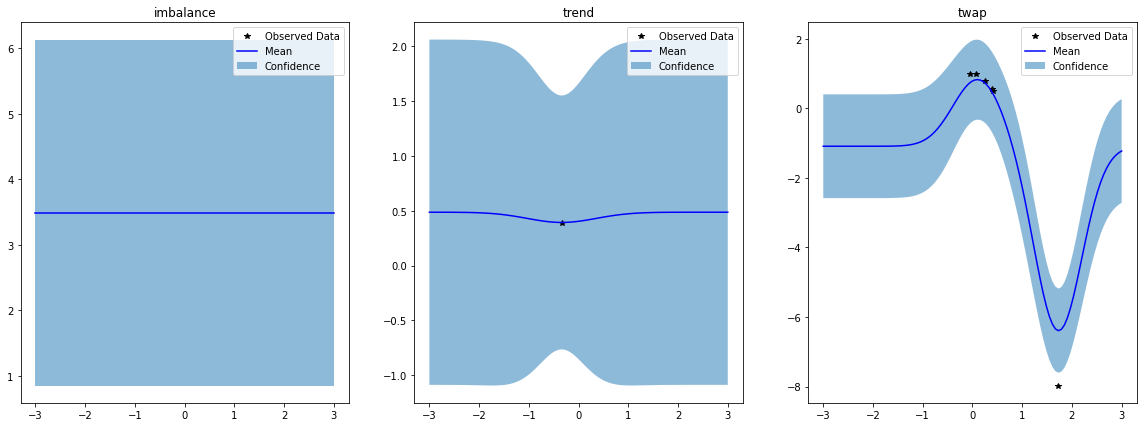

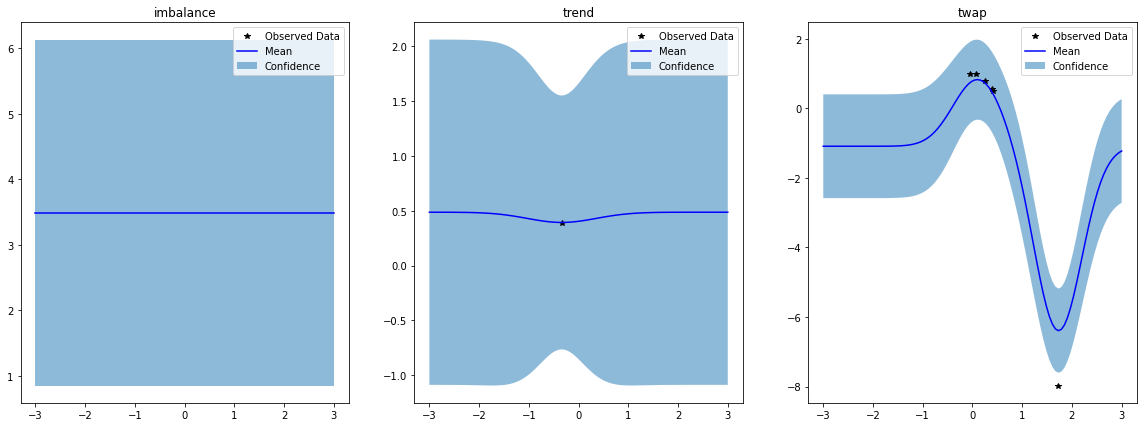

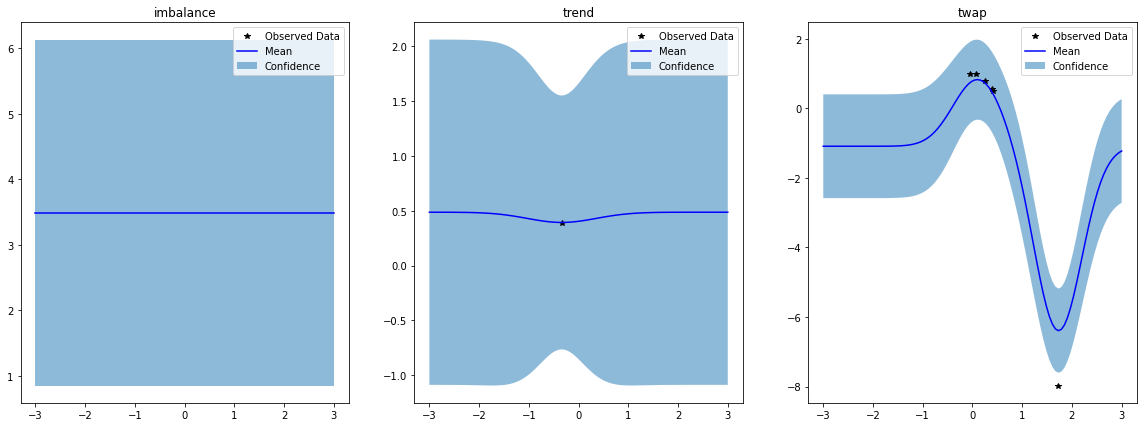

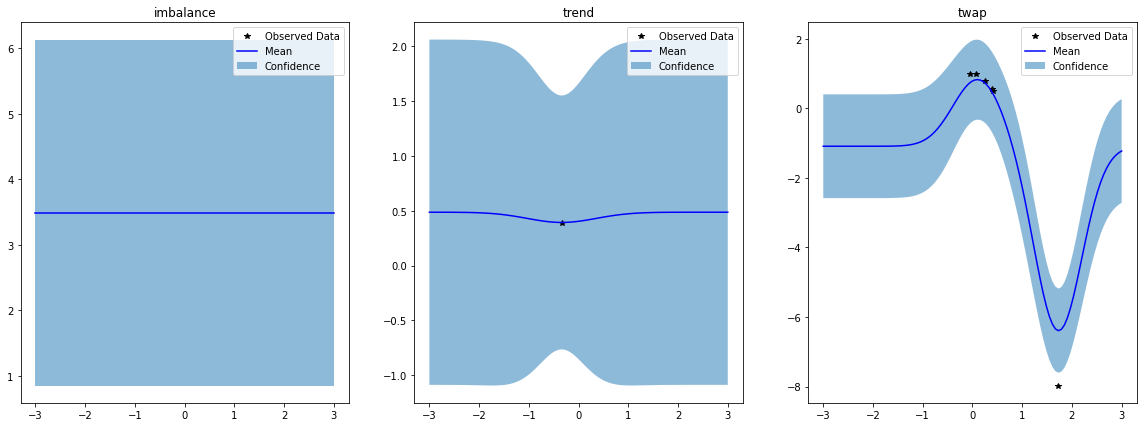

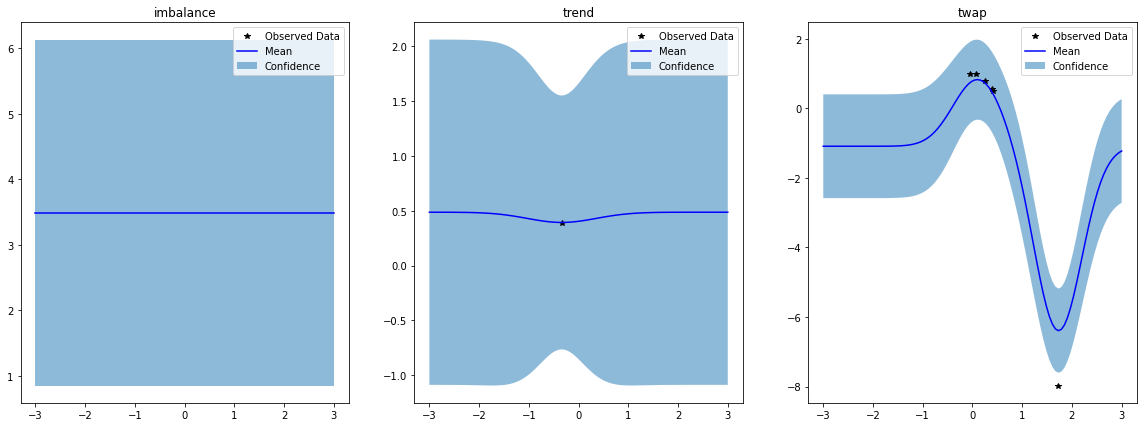

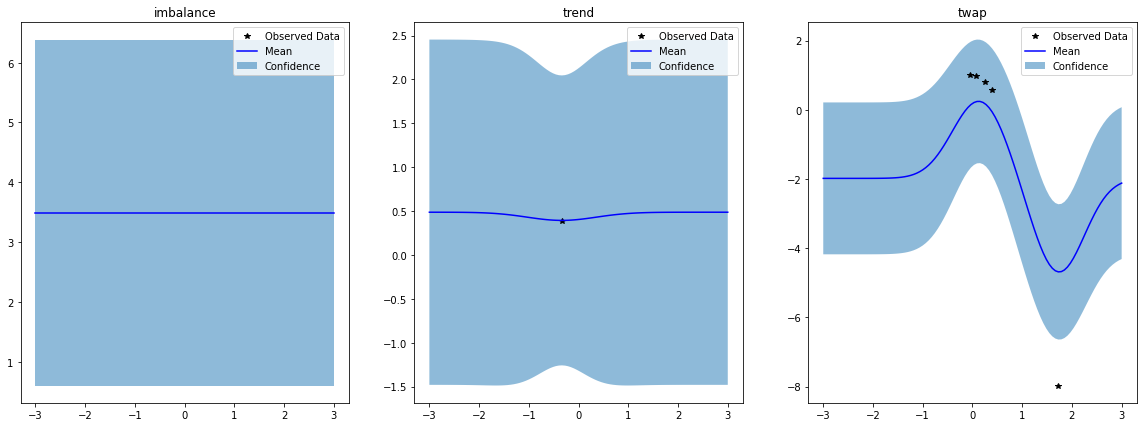

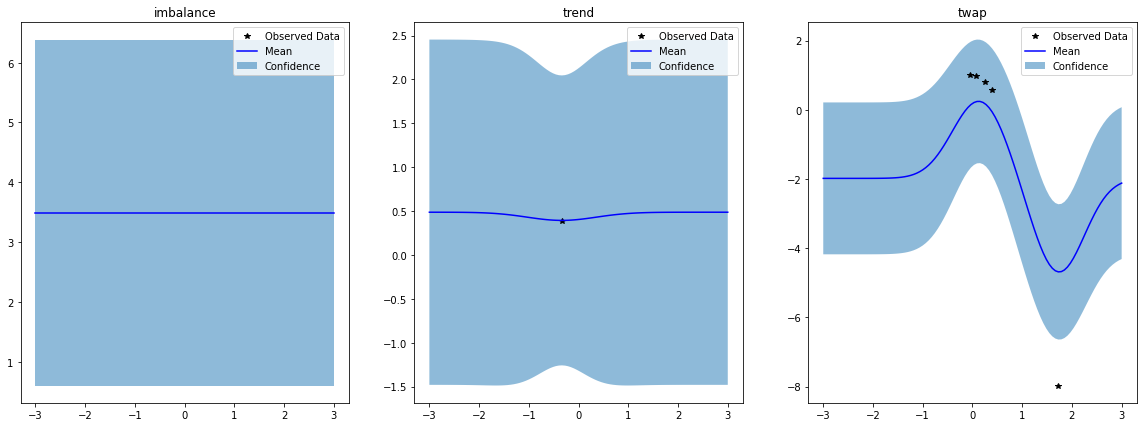

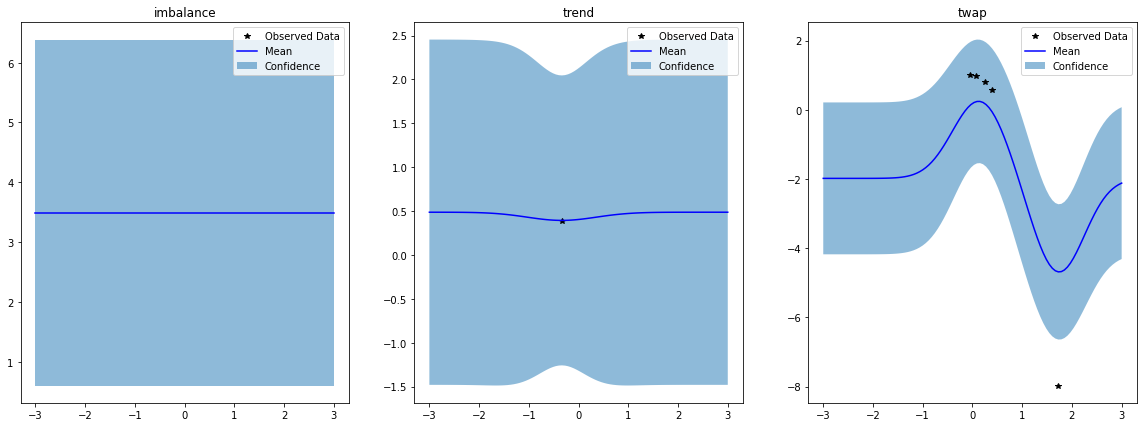

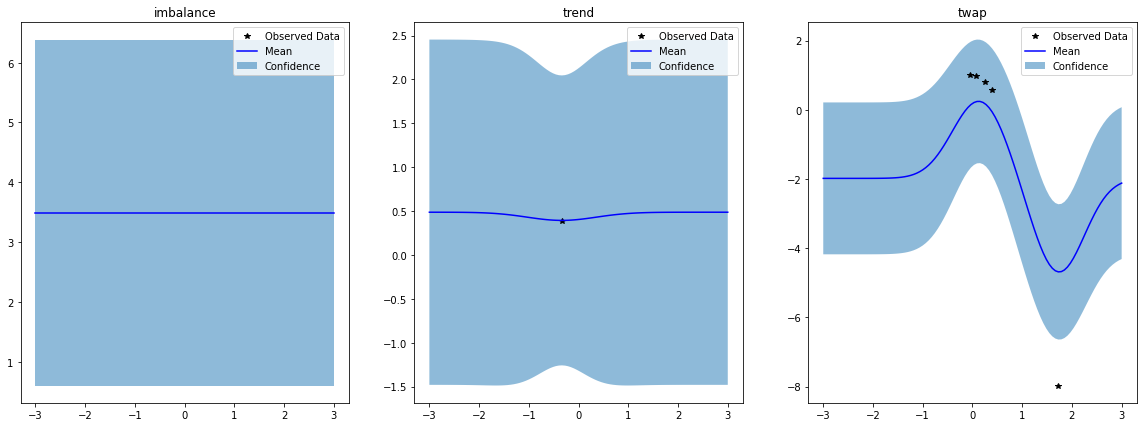

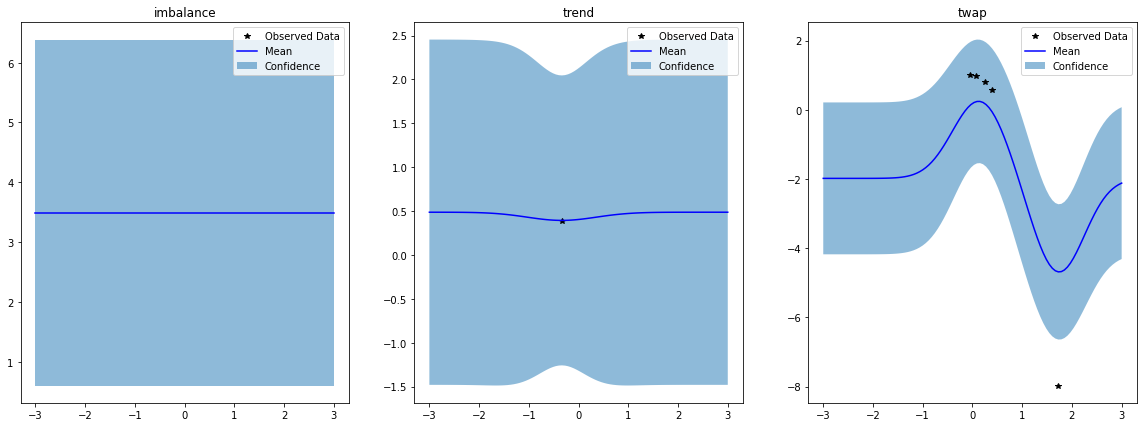

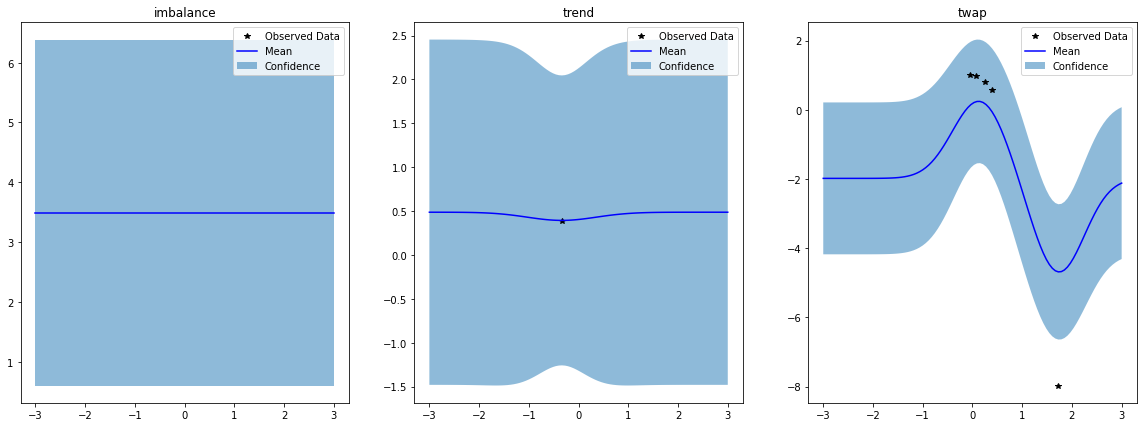

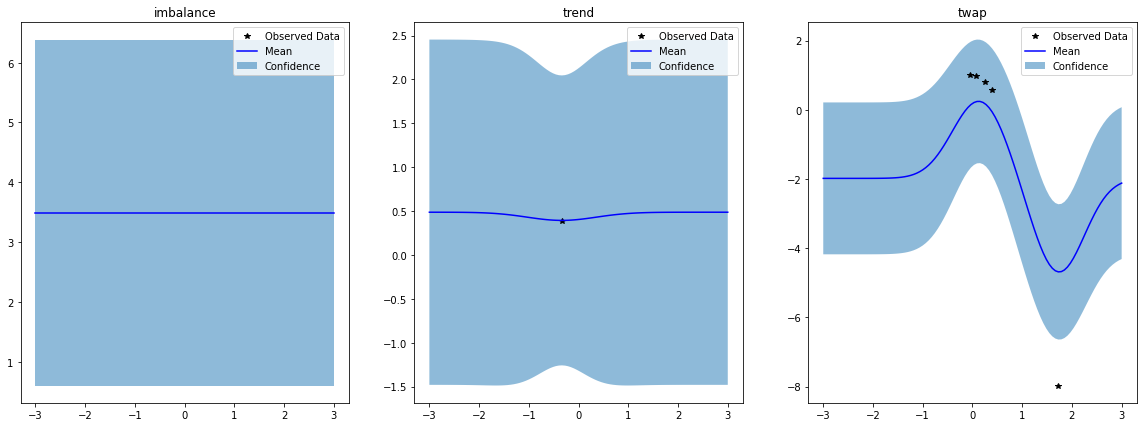

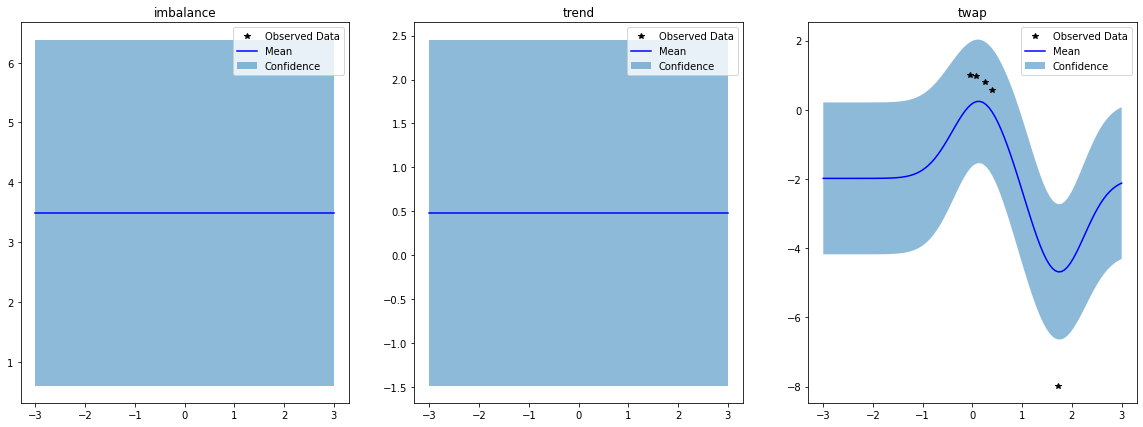

In [16]:
## same with non stationarity
size_buffer_nts = 10
bandit = gp_bandit(strategies, likelihood, size_buffer_nts, bandit_algo='TS')
reward_imbalance = lambda x: x**2
reward_trend = lambda x: -x**2 + 0.5
reward_twap = lambda x: -3*x**2 + 1
d = {'vol_50_50000': np.random.normal()}

for i in range(50):
    
    d['vol_50_50000'] = np.random.normal()
    feature_values = pd.Series(data=d, index=['vol_50_50000'])
    best_strategy_bandit  = bandit.select_best_strategy(feature_values)
    
    if best_strategy_bandit == "imbalance":
        reward = reward_imbalance(d['vol_50_50000'])
    elif best_strategy_bandit == "trend":
        reward = reward_trend(d['vol_50_50000'])
    else:
        reward = reward_twap(d['vol_50_50000']) 
    
    bandit.strat_model_dict[best_strategy_bandit].reward_observation_times.append(i)
    bandit.update_data_nst(feature_values, best_strategy_bandit, reward, i, retrain_hyperparameters = True)
    
    bandit.plot_fit_all()